# Исследование и анализ пользователей маркетплейса. 

Нам представлены данные крупнейшего маркетплейса Бразилии "Olist", который занимается продажей и доставкой широкого ассортимента продовольственных и промышленных товаров. "Olist" объединяет мелкий бизнес по всей Бразилии, чтобы поставщики имели возможность реализовывать свои товары через удобный интерфейс единого интернет-магазина и доставлять свои товары покупателям через централизованную систему логистики.

Представленные для изучения датасеты содержат информацию о порядка 100 тысячах заказов, совершенных покупателями с 2016 по 2018 годы. Так как данные являются реальными, то они были анонимизированы. 

Всего представлено 3 датасета: 

- с информацией о пользователях и их геолокации (содержит уникальный id пользователя), 
- датасет с заказами, которые совершили эти пользователи с полным описанием их характеристик (каждому id пользователя поставлен в соответствие id заказа),
- датасет, содержащий информацию о тех товарах, которые заказал пользователь в определенном заказе, включая цену и вес (каждому уникальному id заказа поставлены в соответствие множественные id товаров).

**Цель исследования**: требуется проанализировать полученные данные и изучить пользователей маркетплейса: провести `когортный анализ` пользователей (выявить показатели `retention` по когортам) и `RFM-сегментацию` для качественного разбиения аудитории на кластеры для последующего более персонифицированного взаимодействия.

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import boxcox 

import matplotlib.pylab as plt
import seaborn as sns
%matplotlib inline

import plotly.graph_objs as go
import plotly.express as px

#!pip install squarify
import squarify

import datetime
from datetime import timedelta
from operator import attrgetter


import requests 
from urllib.parse import urlencode

from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings('ignore')

# plt.style.available
# plt.style.use('Solarize_Light2 (2)')

## 1. Получение данных по внешним ссылкам, загрузка датасетов и изучение данных.

In [2]:
# публичные ссылки на файлы Яндекс.Диск

customers_pk = 'https://disk.yandex.ru/d/FUi5uSd6BfG_ig'
orders_pk = 'https://disk.yandex.ru/d/t9Li4JOfgxuUrg'
items_pk = 'https://disk.yandex.ru/d/Gbt-yAcQrOe3Pw'

In [3]:
def get_yandex_download_url(public_key):
    '''функция принимает публичный ключ и возвращает загрузочную ссылку'''
    
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    
    final_url = base_url + urlencode(dict(public_key=public_key))
    
    response = requests.get(final_url)
    download_url = response.json()['href']
    
    return download_url

In [4]:
# customers = pd.read_csv(get_yandex_download_url(customers_pk))
# orders = pd.read_csv(get_yandex_download_url(orders_pk), parse_dates=[3, 4, 5, 6, 7])
# items = pd.read_csv(get_yandex_download_url(items_pk))

customers = pd.read_csv('data/olist_customers_dataset.csv')
orders = pd.read_csv('data/olist_orders_dataset.csv', parse_dates=[3, 4, 5, 6, 7])
items = pd.read_csv('data/olist_order_items_dataset.csv')

In [5]:
customers.head(3)

customer_id                customer_unique_id  \
0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1  18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2  4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   

   customer_zip_code_prefix          customer_city customer_state  
0                     14409                 franca             SP  
1                      9790  sao bernardo do campo             SP  
2                      1151              sao paulo             SP

In [6]:
orders.head(3)

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   

  order_status order_purchase_timestamp   order_approved_at  \
0    delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   
1    delivered      2018-07-24 20:41:37 2018-07-26 03:24:27   
2    delivered      2018-08-08 08:38:49 2018-08-08 08:55:23   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2018-07-26 14:31:00           2018-08-07 15:27:45   
2          2018-08-08 13:50:00           2018-08-17 18:06:29   

  order_estimated_delivery_date  
0                    2017-10-18  
1                    2018-08-13  
2                    2018-09-04

In [7]:
items.head(3)

order_id  order_item_id  \
0  00010242fe8c5a6d1ba2dd792cb16214              1   
1  00018f77f2f0320c557190d7a144bdd3              1   
2  000229ec398224ef6ca0657da4fc703e              1   

                         product_id                         seller_id  \
0  4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   
1  e5f2d52b802189ee658865ca93d83a8f  dd7ddc04e1b6c2c614352b383efe2d36   
2  c777355d18b72b67abbeef9df44fd0fd  5b51032eddd242adc84c38acab88f23d   

   shipping_limit_date  price  freight_value  
0  2017-09-19 09:45:35   58.9          13.29  
1  2017-05-03 11:05:13  239.9          19.93  
2  2018-01-18 14:48:30  199.0          17.87

Данные получены и загружены корректно, рассмотрим их описание.

### Описание данных

**olist_customers_dataset** - таблица с уникальными идентификаторами пользователей

`customer_id` - позаказный идентификатор пользователя  
`customer_unique_id` - уникальный идентификатор пользователя (аналог номера паспорта)  
`customer_zip_code_prefix` - почтовый индекс пользователя  
`customer_city` - город доставки пользователя  
`customer_state` - штат доставки пользователя

**olist_orders_dataset** - таблица заказов

`order_id` - уникальный идентификатор заказа (номер чека)  
`customer_id` - позаказный идентификатор пользователя  
`order_status` - статус заказа: 

created - создан  
approved - подтверждён  
invoiced - выставлен счёт  
processing - в процессе сборки заказа  
shipped - отгружен со склада  
delivered - доставлен пользователю  
unavailable - недоступен  
canceled - отменён

`order_purchase_timestamp` - время создания заказа  
`order_approved_at` - время подтверждения оплаты заказа  
`order_delivered_carrier_date` - время передачи заказа в логистическую службу  
`order_delivered_customer_date` - время доставки заказа  
`order_estimated_delivery_date` - обещанная дата доставки 

**olist_order_items_dataset** - товарные позиции, входящие в заказы

`order_id` - уникальный идентификатор заказа (номер чека)  
`order_item_id` - идентификатор товара внутри одного заказа  
`product_id` - ид товара (аналог штрихкода)  
`seller_id` - ид производителя товара  
`shipping_limit_date` - максимальная дата доставки продавцом для передачи заказа партнеру по логистике  
`price` - цена за единицу товара  
`freight_value` - вес товара

Выведем случайные 5 строк, общую информацию о каждом датасете (вместе с информацией об абсолютном и относительном количестве пропусков), основные статистики по столбцам и количество явных дубликатов.

Для удобства работы весь процесс реализуем через функции.

In [8]:
def nans(df):
    '''
    функция выводит количество пропусков в каждом столбце 
    и их долю от общего количества данных в столбце
    '''   
    count_missing = df.isna().sum()
    percent_missing = round(df.isna().sum() * 100 / len(df), 2)
    
    missing_value_df = pd.DataFrame({'num_missing': count_missing,
                                     'percent_missing': percent_missing})
    
    return missing_value_df.reset_index().rename(columns={'index':'column'})

In [9]:
def info_dataframe(data, details=False):
    '''функция преобразует df.info() в датафрейм'''
    
    dfInfo = data.columns.to_frame(name='column')
    dfInfo['dtype'] = data.dtypes
    dfInfo['non_null_count'] = data.notna().sum()  
    dfInfo.reset_index(drop=True, inplace=True)
    
    if details:
        rangeIndex = (dfInfo['non_null_count'].min(), dfInfo['non_null_count'].min())
        totalColumns = dfInfo['column'].count()
        dtypesCount = dfInfo['dtype'].value_counts()
        totalMemory = dfInfo.memory_usage().sum()
        return dfInfo, rangeIndex, totalColumns, dtypesCount, totalMemory
    else:
        return dfInfo

In [10]:
def all_info(df):
    '''
    функция выводит случайные 5 строк, информацию по датафрейму, 
    включая пропуски и их долю, статистики и кол-во дубликатов
    '''
    display(df.sample(5))
    print(f'Датафрейм содержит {df.shape[0]} записей и {df.shape[1]} колонок')
    all_info_df = info_dataframe(df).merge(nans(df), on='column')
    display(all_info_df)
    display(df.describe()) 
    print(f'Количество явных дубликатов в датафрейме {df.duplicated().sum()}')

In [11]:
all_info(customers)

customer_id                customer_unique_id  \
51771  27914729140e0b9e30458f92c83baa05  7c846ea8433e8b3160ddb020015c51b3   
60273  b6e3c38be27b21ae7dc366f800e06724  00d76f8bb8df7e07711da4076c52ffe0   
85930  b36cee83a40635fe990ad29c7171f33f  b6c5dc6ddcb93efe16687dc272f74aa3   
42098  d81815d7ddb29da80f4e6c4316520cf6  1508a07c19134ddc099d6161ef9ae4d9   
4185   b1daab0190e21f1b1702791e68fcd940  0fa37740a3371e759a99e0acc2d533c2   

       customer_zip_code_prefix           customer_city customer_state  
51771                     31260          belo horizonte             MG  
60273                     33925      ribeirao das neves             MG  
85930                     47850  luis eduardo magalhaes             BA  
42098                     60864               fortaleza             CE  
4185                      30494          belo horizonte             MG

Датафрейм содержит 99441 записей и 5 колонок


column   dtype  non_null_count  num_missing  \
0               customer_id  object           99441            0   
1        customer_unique_id  object           99441            0   
2  customer_zip_code_prefix   int64           99441            0   
3             customer_city  object           99441            0   
4            customer_state  object           99441            0   

   percent_missing  
0              0.0  
1              0.0  
2              0.0  
3              0.0  
4              0.0

customer_zip_code_prefix
count              99441.000000
mean               35137.474583
std                29797.938996
min                 1003.000000
25%                11347.000000
50%                24416.000000
75%                58900.000000
max                99990.000000

Количество явных дубликатов в датафрейме 0


In [12]:
customers['customer_city'].value_counts()

sao paulo            15540
rio de janeiro        6882
belo horizonte        2773
brasilia              2131
curitiba              1521
                     ...  
bequimao                 1
andarai                  1
vargem grande            1
curvelandia              1
eugenio de castro        1
Name: customer_city, Length: 4119, dtype: int64

In [13]:
print(customers['customer_state'].nunique())
customers['customer_state'].value_counts()

27


SP    41746
RJ    12852
MG    11635
RS     5466
PR     5045
SC     3637
BA     3380
DF     2140
ES     2033
GO     2020
PE     1652
CE     1336
PA      975
MT      907
MA      747
MS      715
PB      536
PI      495
RN      485
AL      413
SE      350
TO      280
RO      253
AM      148
AC       81
AP       68
RR       46
Name: customer_state, dtype: int64

Датасет с информацией о пользователях:
    
- содержит 99441 записей и 5 колонок,
- не содержит пропусков и явных дубликатов,
- типы колонок соответствуют содержимому,
- содержит информацию о пользователях из 27 штатов (наибольшее количество покупателей в штате с меткой SP, их 41746), из 4119 городов (с большим отрывом лидирует sao paulo с 15540 записей).

In [14]:
all_info(orders)

order_id                       customer_id  \
89056  6e8f171a966c53e6442c158fc328eb1a  33cf5d74687e44c099ca607099f8f5ce   
86039  ec6e95dcca4c512f5302ba944bb0e2b4  8509865d572d9f571742875e5a6b41a9   
54433  1300da43ff811b40b28c5c7b8128bf40  bb2f6698ebaced61f5c8d20c2aaabf76   
91725  6635dbf3ae34165800e11b16e937322b  ccf83513ca9850bd456ddcf6ac3bc643   
32713  838e05e4f58ba2fc4a4fe39bcbdc7284  47ef435dfe068181264047c1a392584a   

      order_status order_purchase_timestamp   order_approved_at  \
89056    delivered      2017-12-13 22:20:21 2017-12-15 02:16:01   
86039    delivered      2018-01-26 14:45:19 2018-01-26 14:59:15   
54433    delivered      2018-03-25 21:17:41 2018-03-25 22:00:19   
91725    delivered      2018-04-28 05:58:22 2018-04-28 06:13:14   
32713    delivered      2018-04-12 15:20:03 2018-04-12 15:35:24   

      order_delivered_carrier_date order_delivered_customer_date  \
89056          2017-12-18 17:08:54           2017-12-27 00:58:56   
86039          2018-01-29 21:52:38           2018-02-02 19:24:02   
54433          2018-03-27 05:48:45           2018-04-04 20:28:31   
91725          2018-05-04 11:58:00           2018-05-08 17:43:50   
32713          2018-04-16 19:07:29           2018-04-26 20:33:16   

      order_estimated_delivery_date  
89056                    2018-01-08  
86039                    2018-02-19  
54433                    2018-04-16  
91725                    2018-05-17  
32713                    2018-05-16

Датафрейм содержит 99441 записей и 8 колонок


column           dtype  non_null_count  num_missing  \
0                       order_id          object           99441            0   
1                    customer_id          object           99441            0   
2                   order_status          object           99441            0   
3       order_purchase_timestamp  datetime64[ns]           99441            0   
4              order_approved_at  datetime64[ns]           99281          160   
5   order_delivered_carrier_date  datetime64[ns]           97658         1783   
6  order_delivered_customer_date  datetime64[ns]           96476         2965   
7  order_estimated_delivery_date  datetime64[ns]           99441            0   

   percent_missing  
0             0.00  
1             0.00  
2             0.00  
3             0.00  
4             0.16  
5             1.79  
6             2.98  
7             0.00

order_id                       customer_id  \
count                              99441                             99441   
unique                             99441                             99441   
top     e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
freq                                   1                                 1   
first                                NaN                               NaN   
last                                 NaN                               NaN   

       order_status order_purchase_timestamp    order_approved_at  \
count         99441                    99441                99281   
unique            8                    98875                90733   
top       delivered      2018-04-11 10:48:14  2018-02-27 04:31:10   
freq          96478                        3                    9   
first           NaN      2016-09-04 21:15:19  2016-09-15 12:16:38   
last            NaN      2018-10-17 17:30:18  2018-09-03 17:40:06   

       order_delivered_carrier_date order_delivered_customer_date  \
count                         97658                         96476   
unique                        81018                         95664   
top             2018-05-09 15:48:00           2018-05-08 23:38:46   
freq                             47                             3   
first           2016-10-08 10:34:01           2016-10-11 13:46:32   
last            2018-09-11 19:48:28           2018-10-17 13:22:46   

       order_estimated_delivery_date  
count                          99441  
unique                           459  
top              2017-12-20 00:00:00  
freq                             522  
first            2016-09-30 00:00:00  
last             2018-11-12 00:00:00

Количество явных дубликатов в датафрейме 0


Датасет с информацией о заказах:

- содержит 99441 записей и 8 колонок, 5 из которых представляют собой временные данные, которые мы сразу при загрузке спарсили в тип datetime,
- не содержит явных дубликатов,
- имеет пропуски в колонках с 

временем подтверждения оплаты заказа (0.16% от общего количества записей), 
временем передачи заказа в логистическую службу (1.79% от общего количества записей),
временем доставки заказа (2.98% от общего количества записей).

- типы колонок соответствуют содержимому,
- содержит информацию о заказах, созданных с 11 апреля 2016 года по 17 октября 2018 года.

In [15]:
all_info(items)

order_id  order_item_id  \
51096   741d2cc8f5697d6dad48097792babbe2              2   
59509   879a1b657dd0ac822411797d57cfe29f              1   
82709   bbd8dc7205531e8a4cdaca3a70d1c0bb              1   
109978  f9ec58487d5b17279ea8e6226772ed60              1   
8184    129832042bc2898155b5ebf3b2058585              2   

                              product_id                         seller_id  \
51096   fbd4031ddbc3d02b95834b62769d3ad0  ce7d1888639e6fb06b2749cbfdac1ff7   
59509   99647594018d3d18ef5c6cc75080a150  a0d7fbb07bb5ebc3b05980e750db56f3   
82709   49af4c64c7a13a102a10c4c2d6cd4d91  5cf13accae3222c70a9cac40818ae839   
109978  f1101904aa253b3812582e5df6cc09ee  6fd52c528dcb38be2eea044946b811f8   
8184    cce679660c66e6fbd5c8091dfd29e9cd  d2374cbcbb3ca4ab1086534108cc3ab7   

        shipping_limit_date   price  freight_value  
51096   2018-05-07 05:30:48  138.00          39.26  
59509   2018-05-16 09:11:35  299.00          84.60  
82709   2018-04-23 09:31:16   89.90          19.60  
109978  2018-03-01 20:07:52  168.98          16.94  
8184    2018-08-22 10:25:17   17.90          12.79

Датафрейм содержит 112650 записей и 7 колонок


column    dtype  non_null_count  num_missing  percent_missing
0             order_id   object          112650            0              0.0
1        order_item_id    int64          112650            0              0.0
2           product_id   object          112650            0              0.0
3            seller_id   object          112650            0              0.0
4  shipping_limit_date   object          112650            0              0.0
5                price  float64          112650            0              0.0
6        freight_value  float64          112650            0              0.0

order_item_id          price  freight_value
count  112650.000000  112650.000000  112650.000000
mean        1.197834     120.653739      19.990320
std         0.705124     183.633928      15.806405
min         1.000000       0.850000       0.000000
25%         1.000000      39.900000      13.080000
50%         1.000000      74.990000      16.260000
75%         1.000000     134.900000      21.150000
max        21.000000    6735.000000     409.680000

Количество явных дубликатов в датафрейме 0


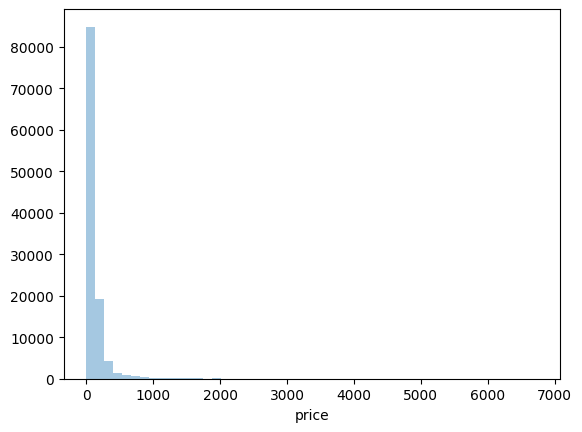

In [16]:
sns.distplot(items['price'], kde=False);

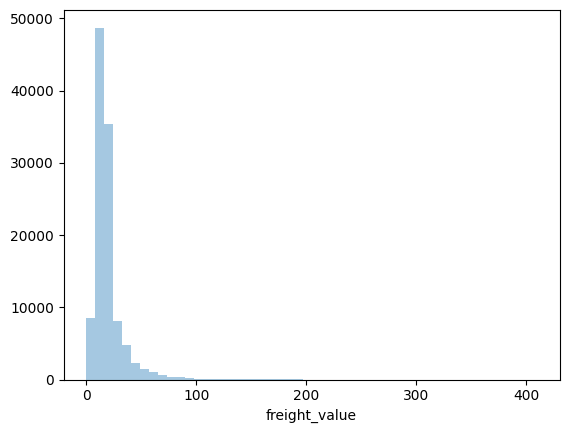

In [17]:
sns.distplot(items['freight_value'], kde=False);

Датасет с товарными позициями, входящими в заказы:

- содержит 112650 записей и 7 колонок,
- не содержит явных дубликатов и пропусков,
- типы колонок соответствуют содержимому,
- имеет большую вариативность по цене и весу заказа, распределения этих признаков сильно скошены влево.

## 2. Выявление пользователей, которые совершили покупку только один раз.

#### Какие заказы считать покупкой?

Сперва нужно понять, что мы будем считаем покупкой. Для этого посмотрим, какие статусы у нас есть и как по ним распределены заказы.

In [18]:
orders['order_status'].value_counts()

delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: order_status, dtype: int64

Мы имеем следующие статусы заказов:
    
- `created` - создан
- `approved` - подтверждён
- `invoiced` - выставлен счёт
- `processing` - в процессе сборки заказа 
- `shipped` - отгружен со склада 
-`delivered` - доставлен пользователю 
- `unavailable` - недоступен 
- `canceled` - отменён 

Статусы  `'created'`, `'approved'`, `'invoiced'`, `'processing'` являются начальными стадиями заказа, то есть на данных этапах у нас нет гарантии того, что клиент получит товар или не оформит возврат. 

Статусы `'unavailable'` и `'canceled'` тоже не подходят, так как клиент точно не получил свой заказ.  

Статус `'shipped'` говорит только о факте отгрузки товара, но не о его дальнейшей судьбе и был ли он получен покупатем.

Таким образом, только статус `'delivered'`, говорит о завершении полного цикла, что товар уже доставлен и принят клиентом.

Рассмотрим, какие статусы имеют заказы с пропусками подтверждения.

In [19]:
# отберём только те, где order_approved_at с пропусками и посмотрим на значения order_status

(
    orders[orders.order_approved_at.isna()]
        .order_status
        .value_counts()
)

canceled     141
delivered     14
created        5
Name: order_status, dtype: int64

- `'canceled'` - заказы с этим статусом нельзя считать покупками,
- `'created'` - созданные, но ещё не оплаченные (и будут ли оплачены неизвестно), а значит они ещё не куплены,
- `'delivered'` - доставленные пользователю, но без даты подтверждения оплаты, возможно, имеет место какой-то сбой в системе.

Взглянем на детали доставленных заказов, но с пропусками даты оплаты.

In [20]:
# отфильтруем orders по пропускам в order_approved_at и order_status == "delivered"

delivered_not_approved = orders.query('order_approved_at.isna() and order_status == "delivered"')
delivered_not_approved

order_id                       customer_id  \
5323   e04abd8149ef81b95221e88f6ed9ab6a  2127dc6603ac33544953ef05ec155771   
16567  8a9adc69528e1001fc68dd0aaebbb54a  4c1ccc74e00993733742a3c786dc3c1f   
19031  7013bcfc1c97fe719a7b5e05e61c12db  2941af76d38100e0f8740a374f1a5dc3   
22663  5cf925b116421afa85ee25e99b4c34fb  29c35fc91fc13fb5073c8f30505d860d   
23156  12a95a3c06dbaec84bcfb0e2da5d228a  1e101e0daffaddce8159d25a8e53f2b2   
26800  c1d4211b3dae76144deccd6c74144a88  684cb238dc5b5d6366244e0e0776b450   
38290  d69e5d356402adc8cf17e08b5033acfb  68d081753ad4fe22fc4d410a9eb1ca01   
39334  d77031d6a3c8a52f019764e68f211c69  0bf35cac6cc7327065da879e2d90fae8   
48401  7002a78c79c519ac54022d4f8a65e6e8  d5de688c321096d15508faae67a27051   
61743  2eecb0d85f281280f79fa00f9cec1a95  a3d3c38e58b9d2dfb9207cab690b6310   
63052  51eb2eebd5d76a24625b31c33dd41449  07a2a7e0f63fd8cb757ed77d4245623c   
67697  88083e8f64d95b932164187484d90212  f67cd1a215aae2a1074638bbd35a223a   
72407  3c0b8706b065f9919d0505d3b3343881  d85919cb3c0529589c6fa617f5f43281   
84999  2babbb4b15e6d2dfe95e2de765c97bce  74bebaf46603f9340e3b50c6b086f992   

      order_status order_purchase_timestamp order_approved_at  \
5323     delivered      2017-02-18 14:40:00               NaT   
16567    delivered      2017-02-18 12:45:31               NaT   
19031    delivered      2017-02-18 13:29:47               NaT   
22663    delivered      2017-02-18 16:48:35               NaT   
23156    delivered      2017-02-17 13:05:55               NaT   
26800    delivered      2017-01-19 12:48:08               NaT   
38290    delivered      2017-02-19 01:28:47               NaT   
39334    delivered      2017-02-18 11:04:19               NaT   
48401    delivered      2017-01-19 22:26:59               NaT   
61743    delivered      2017-02-17 17:21:55               NaT   
63052    delivered      2017-02-18 15:52:27               NaT   
67697    delivered      2017-02-18 22:49:19               NaT   
72407    delivered      2017-02-17 15:53:27               NaT   
84999    delivered      2017-02-18 17:15:03               NaT   

      order_delivered_carrier_date order_delivered_customer_date  \
5323           2017-02-23 12:04:47           2017-03-01 13:25:33   
16567          2017-02-23 09:01:52           2017-03-02 10:05:06   
19031          2017-02-22 16:25:25           2017-03-01 08:07:38   
22663          2017-02-22 11:23:10           2017-03-09 07:28:47   
23156          2017-02-22 11:23:11           2017-03-02 11:09:19   
26800          2017-01-25 14:56:50           2017-01-30 18:16:01   
38290          2017-02-23 03:11:48           2017-03-02 03:41:58   
39334          2017-02-23 07:23:36           2017-03-02 16:15:23   
48401          2017-01-27 11:08:05           2017-02-06 14:22:19   
61743          2017-02-22 11:42:51           2017-03-03 12:16:03   
63052          2017-02-23 03:09:14           2017-03-07 13:57:47   
67697          2017-02-22 11:31:06           2017-03-02 12:06:06   
72407          2017-02-22 11:31:30           2017-03-03 11:47:47   
84999          2017-02-22 11:23:11           2017-03-03 18:43:43   

      order_estimated_delivery_date  
5323                     2017-03-17  
16567                    2017-03-21  
19031                    2017-03-17  
22663                    2017-03-31  
23156                    2017-03-20  
26800                    2017-03-01  
38290                    2017-03-27  
39334                    2017-03-22  
48401                    2017-03-16  
61743                    2017-03-20  
63052                    2017-03-29  
67697                    2017-03-21  
72407                    2017-03-23  
84999                    2017-03-31

In [21]:
# отфильтруем order_items по значениям order_id из предыдущего шага

delivered_not_approved_items = items.query('order_id in @delivered_not_approved.order_id')
delivered_not_approved_items

order_id  order_item_id  \
8204   12a95a3c06dbaec84bcfb0e2da5d228a              1   
19005  2babbb4b15e6d2dfe95e2de765c97bce              1   
20473  2eecb0d85f281280f79fa00f9cec1a95              1   
26393  3c0b8706b065f9919d0505d3b3343881              1   
36128  51eb2eebd5d76a24625b31c33dd41449              1   
40822  5cf925b116421afa85ee25e99b4c34fb              1   
49309  7002a78c79c519ac54022d4f8a65e6e8              1   
49336  7013bcfc1c97fe719a7b5e05e61c12db              1   
59699  88083e8f64d95b932164187484d90212              1   
59700  88083e8f64d95b932164187484d90212              2   
60815  8a9adc69528e1001fc68dd0aaebbb54a              1   
85300  c1d4211b3dae76144deccd6c74144a88              1   
94630  d69e5d356402adc8cf17e08b5033acfb              1   
94999  d77031d6a3c8a52f019764e68f211c69              1   
98863  e04abd8149ef81b95221e88f6ed9ab6a              1   

                             product_id                         seller_id  \
8204   c6dd917a0be2a704582055949915ab32  7a67c85e85bb2ce8582c35f2203ad736   
19005  c6dd917a0be2a704582055949915ab32  7a67c85e85bb2ce8582c35f2203ad736   
20473  4fd676d9c4723d475026e40aeae56957  5fd924b4836098a5be0ecf81ba054ce0   
26393  db8ed3d08891d16a2438a67ab3acb740  004c9cd9d87a3c30c522c48c4fc07416   
36128  7868a64aa111bbb4f41f8e1146c0becb  cca3071e3e9bb7d12640c9fbe2301306   
40822  c6dd917a0be2a704582055949915ab32  7a67c85e85bb2ce8582c35f2203ad736   
49309  c3b271f47e73d0c9ccf1b43b7606c705  cca3071e3e9bb7d12640c9fbe2301306   
49336  583916a5dae918f5e89baec139141c54  3481aa57cd91f9f9d3fa1fa12d9a3bf7   
59699  8c5876b1c7768217964f353bc7e64393  0db783cfcd3b73998abc6e10e59a102f   
59700  8c5876b1c7768217964f353bc7e64393  0db783cfcd3b73998abc6e10e59a102f   
60815  2c2b6a28924791234bd386bddb17512e  a4b6b9b992b46e9ef863637af96e04bc   
85300  5ab02ca028398131a5ae91401eb49788  80e6699fe29150b372a0c8a1ebf7dcc8   
94630  cae2e38942c8489d9d7a87a3f525c06b  cca3071e3e9bb7d12640c9fbe2301306   
94999  02a79d79e818ad0be36cfc843a6af7ad  cb3dd9ce66268c7a3ca7241ac70ab58c   
98863  0e20a07ca1714df21f9b07ca3bf7c682  4e7c18b98d84e05cbae3ff0ff03846c2   

       shipping_limit_date   price  freight_value  
8204   2017-02-21 12:05:55   79.99          15.77  
19005  2017-02-22 16:15:03   79.99          26.82  
20473  2017-02-21 16:21:55  135.00          19.23  
26393  2017-02-22 14:53:27  133.99          23.20  
36128  2017-02-28 14:52:27   59.90          17.16  
40822  2017-02-22 15:48:35   79.99          26.82  
49309  2017-01-29 22:26:59   45.90          14.52  
49336  2017-02-22 12:29:47   49.99          15.53  
59699  2017-02-22 21:49:19   49.00          14.52  
59700  2017-02-22 21:49:19   49.00          14.52  
60815  2017-02-22 11:45:31  379.00          17.86  
85300  2017-01-23 12:48:08   39.99          14.52  
94630  2017-02-26 01:28:47  149.80          13.63  
94999  2017-02-25 10:04:19   28.99          10.96  
98863  2017-02-22 13:40:00  309.90          39.11

По всем параметрам эти записи похожи на покупки, то есть покупками будем считать в том числе и доставленные заказы без указания даты оплаты.

In [22]:
# сравним количество строк отфильтрованных датафрэймов

print('Число строк в delivered_not_approved:      ', delivered_not_approved.shape[0])
print('Число строк в delivered_not_approved_items:', delivered_not_approved_items.shape[0])

Число строк в delivered_not_approved:       14
Число строк в delivered_not_approved_items: 15


In [23]:
# найдём повторы order_id

order_id_duplicated = (
    delivered_not_approved_items
        .loc[
            delivered_not_approved_items
                .duplicated(subset='order_id', keep=False)
        ]
)
order_id_duplicated

order_id  order_item_id  \
59699  88083e8f64d95b932164187484d90212              1   
59700  88083e8f64d95b932164187484d90212              2   

                             product_id                         seller_id  \
59699  8c5876b1c7768217964f353bc7e64393  0db783cfcd3b73998abc6e10e59a102f   
59700  8c5876b1c7768217964f353bc7e64393  0db783cfcd3b73998abc6e10e59a102f   

       shipping_limit_date  price  freight_value  
59699  2017-02-22 21:49:19   49.0          14.52  
59700  2017-02-22 21:49:19   49.0          14.52

У этих записей совпадает всё, кроме `order_item_id` (идентификатор товара внутри одного заказа). Видимо, это 2 одинаковых товара в одном заказе.

Теперь рассмотрим статусы заказов с подтверждением оплаты.

In [24]:
# отберём только те, где order_approved_at без пропусков и посмотрим на значения order_status

(
    orders[orders.order_approved_at.isna() == False]
        .order_status
        .value_counts()
)

delivered      96464
shipped         1107
unavailable      609
canceled         484
invoiced         314
processing       301
approved           2
Name: order_status, dtype: int64

**Вывод**

В итоге, покупкой будем считать все статусы, кроме:
    
- `'created'` (встречается только в заказах с пропусками оплаты),  
- `'unavailable'` (скорее всего выполнить не удастся),   
- `'canceled'` (отменён).  

In [25]:
# список статусов, которые не будем считать покупками

no_purchases_statuses = ['created', 'unavailable', 'canceled']

Теперь, когда мы определились, что покупкой не является, рассмотрим айди клиентов и их заказов.

In [26]:
# сначала проверим сколько у нас всего уникальных пользователей

customers.customer_unique_id.nunique()

96096

In [27]:
# количество уникальных позаказных идентификаторов пользователя (в том и другом датасете)

print(customers.customer_id.nunique())
print(orders.customer_id.nunique())

99441
99441


In [28]:
# количество уникальных идентификаторов заказа (номер чека)

orders.order_id.nunique()

99441

Так как количество уникальных позаказных идентификаторов пользователя и количество уникальных идентификаторов заказа (номер чека) совпадают, для данного случая рассматриваем как одну и туже информацию для подсчета количества покупок (один чек - одна покупка). 

Однако, часть `customer_unique_id` приходится по несколько `customer_id`. Убедимся в этом визуально, показав дубликаты `customer_unique_id`. 

In [29]:
(
    customers
        .loc[customers
                .duplicated(keep=False, subset='customer_unique_id')]
        .sort_values('customer_unique_id')
        .head()
)

customer_id                customer_unique_id  \
35608  24b0e2bd287e47d54d193e7bbb51103f  00172711b30d52eea8b313a7f2cced02   
19299  1afe8a9c67eec3516c09a8bdcc539090  00172711b30d52eea8b313a7f2cced02   
20023  1b4a75b3478138e99902678254b260f4  004288347e5e88a27ded2bb23747066c   
22066  f6efe5d5c7b85e12355f9d5c3db46da2  004288347e5e88a27ded2bb23747066c   
72451  49cf243e0d353cd418ca77868e24a670  004b45ec5c64187465168251cd1c9c2f   

       customer_zip_code_prefix customer_city customer_state  
35608                     45200        jequie             BA  
19299                     45200        jequie             BA  
20023                     26220   nova iguacu             RJ  
22066                     26220   nova iguacu             RJ  
72451                     57055        maceio             AL

Следовательно при оценке покупок необходимо ориетнироваться на `customer_unique_id`.

Для удобства дальнейшей работы датафреймы `customers` и `orders` могут быть объединены по общему полю `customer_id`.

In [30]:
customers_orders_merged = customers.merge(orders, on='customer_id')
customers_orders_merged.shape

(99441, 12)

In [31]:
customers_orders_merged.head()

customer_id                customer_unique_id  \
0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1  18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2  4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   
3  b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   
4  4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066   

   customer_zip_code_prefix          customer_city customer_state  \
0                     14409                 franca             SP   
1                      9790  sao bernardo do campo             SP   
2                      1151              sao paulo             SP   
3                      8775        mogi das cruzes             SP   
4                     13056               campinas             SP   

                           order_id order_status order_purchase_timestamp  \
0  00e7ee1b050b8499577073aeb2a297a1    delivered      2017-05-16 15:05:35   
1  29150127e6685892b6eab3eec79f59c7    delivered      2018-01-12 20:48:24   
2  b2059ed67ce144a36e2aa97d2c9e9ad2    delivered      2018-05-19 16:07:45   
3  951670f92359f4fe4a63112aa7306eba    delivered      2018-03-13 16:06:38   
4  6b7d50bd145f6fc7f33cebabd7e49d0f    delivered      2018-07-29 09:51:30   

    order_approved_at order_delivered_carrier_date  \
0 2017-05-16 15:22:12          2017-05-23 10:47:57   
1 2018-01-12 20:58:32          2018-01-15 17:14:59   
2 2018-05-20 16:19:10          2018-06-11 14:31:00   
3 2018-03-13 17:29:19          2018-03-27 23:22:42   
4 2018-07-29 10:10:09          2018-07-30 15:16:00   

  order_delivered_customer_date order_estimated_delivery_date  
0           2017-05-25 10:35:35                    2017-06-05  
1           2018-01-29 12:41:19                    2018-02-06  
2           2018-06-14 17:58:51                    2018-06-13  
3           2018-03-28 16:04:25                    2018-04-10  
4           2018-08-09 20:55:48                    2018-08-15

Количество строк у объединённого датафрэйма осталось таким же - значит все значения `customer_id` в обоих датафрэймах полностью совпадают и никакие значения при объединении не потеряны.

Теперь мы можем посчитать число пользователей, совершивших покупку только один раз.

In [32]:
(
    customers_orders_merged
        .query('order_status not in @no_purchases_statuses')  # убираем строки со статусами-непокупками
        .groupby('customer_unique_id', as_index=False)        # группируем по customer_unique_id
        .agg({'order_id': 'count'})                        # подсчитываем количество покупок на каждого уник. пользователя
        .query('order_id == 1')                            # отбираем тех, у кого количество покупок = 1
        .shape[0]
)

92099

**Вывод**

Таким образом, количество клиентов с одним заказом - 92099. Это составляет 92,6% от общего количества пользователей.

## 3. Подсчет среднего количества недоставленных заказов в месяц с детализацией причин.

#### Какие заказы считать недоставленными?

Проверим как согласуются колонки со статусом и временем доставки.

In [33]:
# уникальные значения статуса среди непропущенных значений order_delivered_customer_date в orders

(
    orders
        .query('order_delivered_customer_date.isna() == False')
        .order_status
        .value_counts()
)

delivered    96470
canceled         6
Name: order_status, dtype: int64

Таким образом, 6 заказов с существующей датой доставки имеют статус "отменён".

In [34]:
# значения order_status при пропущенных датах доставки в orders

(
    orders
        .query('order_delivered_customer_date.isna() == True')
        .order_status
        .value_counts()
)

shipped        1107
canceled        619
unavailable     609
invoiced        314
processing      301
delivered         8
created           5
approved          2
Name: order_status, dtype: int64

Из данных видно, что 8 заказов со статусом "доставлено" не имеют дат доставки клиенту.

In [35]:
# orders с пропущенными датами достаки, при этом имеющие статус "доставлен"

(
    orders
        .query('order_delivered_customer_date.isna() == True and order_status == "delivered"')
)

order_id                       customer_id  \
3002   2d1e2d5bf4dc7227b3bfebb81328c15f  ec05a6d8558c6455f0cbbd8a420ad34f   
20618  f5dd62b788049ad9fc0526e3ad11a097  5e89028e024b381dc84a13a3570decb4   
43834  2ebdfc4f15f23b91474edf87475f108e  29f0540231702fda0cfdee0a310f11aa   
79263  e69f75a717d64fc5ecdfae42b2e8e086  cfda40ca8dd0a5d486a9635b611b398a   
82868  0d3268bad9b086af767785e3f0fc0133  4f1d63d35fb7c8999853b2699f5c7649   
92643  2d858f451373b04fb5c984a1cc2defaf  e08caf668d499a6d643dafd7c5cc498a   
97647  ab7c89dc1bf4a1ead9d6ec1ec8968a84  dd1b84a7286eb4524d52af4256c0ba24   
98038  20edc82cf5400ce95e1afacc25798b31  28c37425f1127d887d7337f284080a0f   

      order_status order_purchase_timestamp   order_approved_at  \
3002     delivered      2017-11-28 17:44:07 2017-11-28 17:56:40   
20618    delivered      2018-06-20 06:58:43 2018-06-20 07:19:05   
43834    delivered      2018-07-01 17:05:11 2018-07-01 17:15:12   
79263    delivered      2018-07-01 22:05:55 2018-07-01 22:15:14   
82868    delivered      2018-07-01 21:14:02 2018-07-01 21:29:54   
92643    delivered      2017-05-25 23:22:43 2017-05-25 23:30:16   
97647    delivered      2018-06-08 12:09:39 2018-06-08 12:36:39   
98038    delivered      2018-06-27 16:09:12 2018-06-27 16:29:30   

      order_delivered_carrier_date order_delivered_customer_date  \
3002           2017-11-30 18:12:23                           NaT   
20618          2018-06-25 08:05:00                           NaT   
43834          2018-07-03 13:57:00                           NaT   
79263          2018-07-03 13:57:00                           NaT   
82868          2018-07-03 09:28:00                           NaT   
92643                          NaT                           NaT   
97647          2018-06-12 14:10:00                           NaT   
98038          2018-07-03 19:26:00                           NaT   

      order_estimated_delivery_date  
3002                     2017-12-18  
20618                    2018-07-16  
43834                    2018-07-30  
79263                    2018-07-30  
82868                    2018-07-24  
92643                    2017-06-23  
97647                    2018-06-26  
98038                    2018-07-19

В силу неизвестных нам причин заказы одновременно имеют статус `delivered` и пропущенные значения `order_delivered_customer_date`.

**Вывод**

НЕдоставленными будем считать те заказы, у которых отсутствует `order_delivered_customer_date`.

Итак, теперь когда мы определились с терминологией, оценим общую динамику количества доставленных и недоставленных заказов с течением времени.

In [36]:
# переводим колонку с датой заказа в индекс для применения метода "resample"

customers_orders_monthly = customers_orders_merged.set_index('order_purchase_timestamp')

In [37]:
# отбираем только доставленные заказы и считаем их количество по месяцам

order_on = customers_orders_monthly.loc[customers_orders_monthly.order_delivered_customer_date.notna()] \
                                  .resample(rule='M') \
                                  .order_id.count().reset_index() \
                                  .rename(columns={'order_purchase_timestamp': 'month', 
                                                   'order_id': 'value_order_on'})

In [38]:
# отбираем только не доставленные заказы и считаем их количество по месяцам

order_off = customers_orders_monthly.loc[customers_orders_monthly.order_delivered_customer_date.isna()] \
                                  .resample(rule='M') \
                                  .order_id.count().reset_index() \
                                  .rename(columns={'order_purchase_timestamp': 'month', 
                                                   'order_id': 'value_order_off'})

In [39]:
# построим график количества доставленных и не доставленных заказов по месяцам

fig = go.Figure()
fig.add_trace(go.Scatter(x=order_on.month, y=order_on.value_order_on, name='Доставлено'))
fig.add_trace(go.Scatter(x=order_off.month, y=order_off.value_order_off, name='Не доставлено'))
fig.update_layout(legend_orientation='h',
                  title='Количество доставленных и не доставленных заказов по месяцам',
                  xaxis_title='Месяц',
                  yaxis_title='Количество заказов',
                  margin=dict(l=0, r=20, t=40, b=0))
fig.show()

In [40]:
print('Не доставленных заказоз за месяц в среднем:', round(order_off.value_order_off.mean(), 2))

Не доставленных заказоз за месяц в среднем: 114.04


Подобным же образом можно визуализировать данные по недоставленным заказам и в разрезе статусов с динамикой по времени.

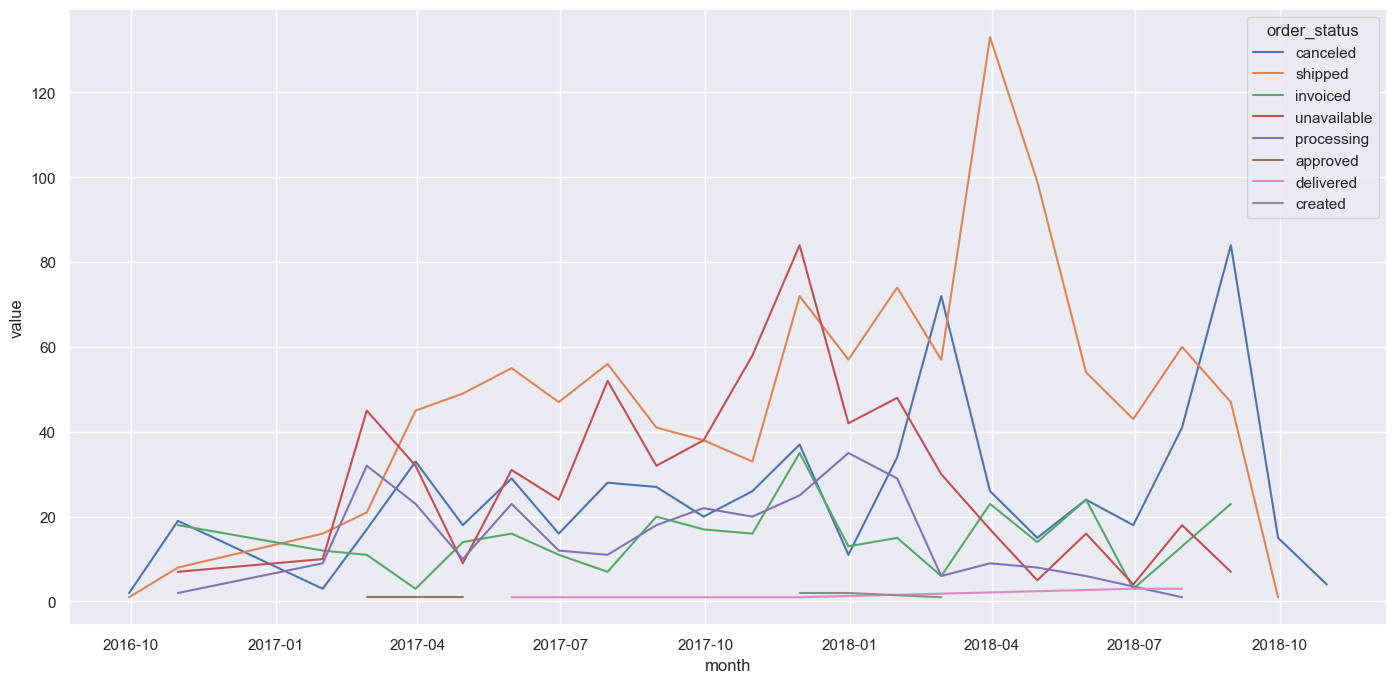

In [41]:
order_off_status = pd.DataFrame(customers_orders_monthly.loc[customers_orders_monthly.order_delivered_customer_date.isna()] \
                                    .resample(rule='M').order_status.value_counts()) \
                                    .rename(columns={'order_status': 'value'}) \
                                    .reset_index() \
                                    .rename(columns={'order_purchase_timestamp': 'month'})

sns.set(rc={'figure.figsize': (17, 8)})
sns.lineplot(x=order_off_status.month, y=order_off_status.value, hue=order_off_status.order_status);

Теперь для удобства создадим датафрейм только с заказами, которые не были доставлены, и рассмотрим их статусы.

In [42]:
# датафрэйм с не доставленными заказами

not_delivered_orders = orders.copy().query('order_status != "delivered"')

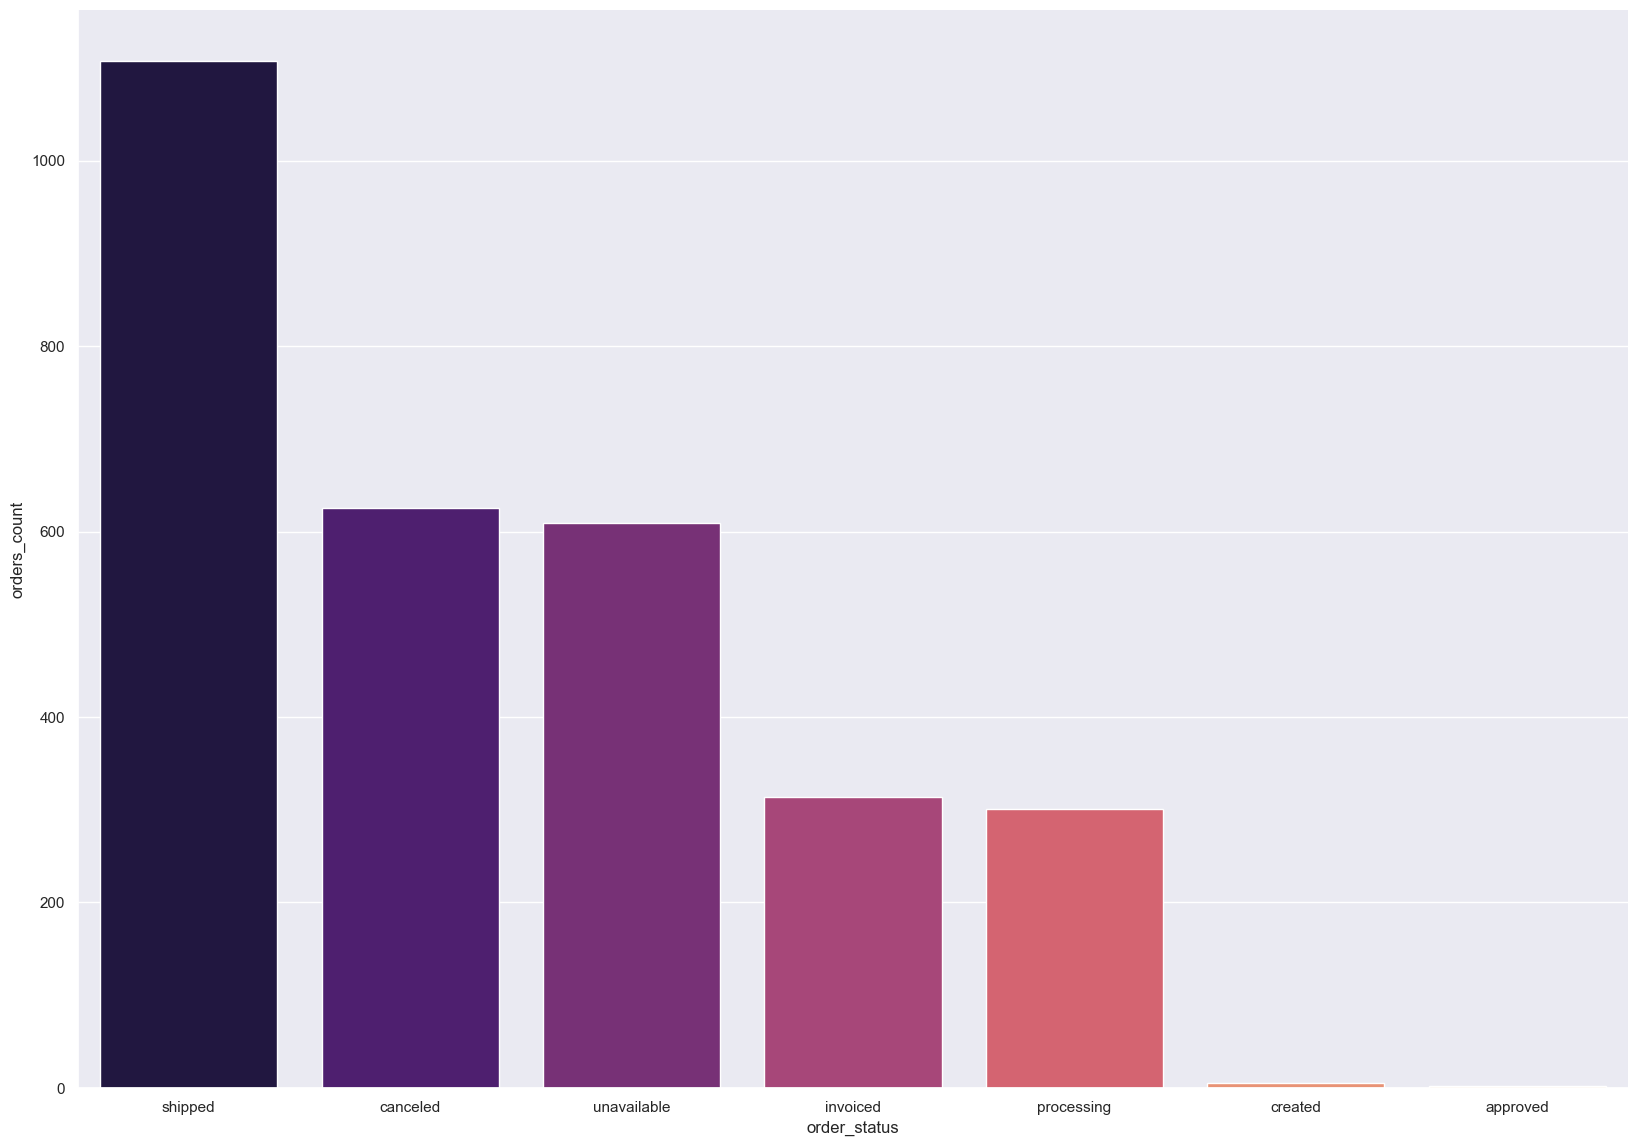

In [43]:
# визуализируем статусы недоставленных заказов

not_delivered_orders_status = not_delivered_orders.groupby('order_status') \
                                                .agg({'order_id' : 'count'}) \
                                                .rename(columns={'order_id' : 'orders_count'}) \
                                                .sort_values(by='orders_count', ascending=False) \
                                                .reset_index()

fig = plt.figure(figsize=(20, 14))

sns.barplot(x=not_delivered_orders_status['order_status'], 
            y=not_delivered_orders_status['orders_count'], 
            data=not_delivered_orders_status, 
            palette='magma')
sns.despine()

Как видим, больше всего недоставленных заказов имеют статус `shipped` (отгружен со склада) - это может быть связано как с незавершенностью процесса доставки по плану, так и с проблемами логистики.

На втором и третем месте заказы со статусом `unavailable` (недоступен) и `canceled` (отменён), то есть заказы не были доставлены по причинам, связанным с заказчиком.

In [44]:
# количество не доставленных заказов в разрезе статуса заказа в среднем

(
    order_off_status.groupby('order_status', as_index=False)
                     .agg({'value': 'mean'})
                     .round(2)
                     .rename(columns={'value' : 'mean_undelivered'})
                     .sort_values(by='mean_undelivered', ascending=False)
)

order_status  mean_undelivered
6      shipped             48.13
7  unavailable             29.00
1     canceled             25.79
5   processing             15.84
4     invoiced             14.95
3    delivered              2.00
2      created              1.67
0     approved              1.00

Лидирует в списке статус `shipped`. Сравним для этих заказов дату передачи в логистическую службу с обещаной датой доставки.

In [45]:
# недоставленные со статусом shipped

shipped = (
    not_delivered_orders
        .copy()
        .query('order_status == "shipped"')
)

In [46]:
# разница во времени обещаной датой доставки и датой передачи в логистическую службу

shipped['delta_time'] = (
    shipped
        .order_estimated_delivery_date
            .sub(shipped
                 .order_delivered_carrier_date)
)

In [47]:
# недоставленные shipped с отрицательной разницей во времени

shipped.query('delta_time < @pd.to_timedelta(0)')

order_id                       customer_id  \
6997   1b76802b72eb5517c97481ee2f7b7037  85ac32af92e4e38adeaeb0653a085dfd   
8813   cb503219f1a73d8a4dfe8561be373c99  921822ed81e9c094d7908db16164a270   
19637  c108072ab31ec90a754129c171577f5f  a979b3cbd898fd8be91a290a667fd0d4   
22143  38541d08d4eb7d571b5b80cb6ca9be03  937682b4176cf634c443714be31b5ca7   
40266  19802314932831a78e4f0e3dead30f83  cc825baf36814fe3b4354455ef9a2335   
55472  dd0e00343af091774fc1399707418777  fa4cd2e67f0e9eb36f86d4b1413b059d   
66818  18c89078cd21364b7ad7f4d652e0cb84  2d86160611127e9ccc6c5e70ea08f065   
78402  28bc8f33c194dd4f636717ef490d0921  64ebc89fe827e44bf4c57f7e22676e12   

      order_status order_purchase_timestamp   order_approved_at  \
6997       shipped      2017-02-08 08:48:43 2017-02-08 08:55:11   
8813       shipped      2017-11-25 11:22:09 2017-11-25 11:35:20   
19637      shipped      2017-10-16 21:13:03 2017-10-16 21:28:13   
22143      shipped      2017-11-24 21:36:30 2017-11-25 01:31:42   
40266      shipped      2017-11-20 11:46:03 2017-11-20 12:10:25   
55472      shipped      2017-03-06 19:54:12 2017-03-07 04:25:28   
66818      shipped      2017-10-17 17:16:34 2017-10-17 17:46:06   
78402      shipped      2018-02-26 12:08:26 2018-02-27 10:48:37   

      order_delivered_carrier_date order_delivered_customer_date  \
6997           2017-03-14 11:00:52                           NaT   
8813           2018-01-04 21:41:39                           NaT   
19637          2017-10-26 20:40:20                           NaT   
22143          2018-01-04 21:07:51                           NaT   
40266          2017-12-14 21:35:17                           NaT   
55472          2017-04-03 14:32:54                           NaT   
66818          2017-11-01 22:07:45                           NaT   
78402          2018-03-17 00:11:31                           NaT   

      order_estimated_delivery_date         delta_time  
6997                     2017-03-10  -5 days +12:59:08  
8813                     2017-12-21 -15 days +02:18:21  
19637                    2017-10-26  -1 days +03:19:40  
22143                    2017-12-20 -16 days +02:52:09  
40266                    2017-12-13  -2 days +02:24:43  
55472                    2017-03-29  -6 days +09:27:06  
66818                    2017-10-27  -6 days +01:52:15  
78402                    2018-03-12  -6 days +23:48:29

Как видим, среди `shipped` есть заказы, которые были переданы в логистическую службу уже после срока, отведённого на доставку.

Подробную статистику по месяцам и статусам мы можем получить с помощью пивот-таблицы.

In [48]:
# добавим колонку содержащую только год и месяц на основе order_estimated_delivery_date

not_delivered_orders['year_month_estimated'] = (
    not_delivered_orders
        .order_estimated_delivery_date
        .dt
        .strftime("%Y-%m")
)

In [49]:
undelivered_pivot = not_delivered_orders.pivot_table(index='year_month_estimated', 
                                                     columns='order_status', 
                                                     values='order_id', 
                                                     aggfunc='count', 
                                                     fill_value = 0,
                                                     margins=True,
                                                     margins_name='total')

undelivered_pivot

order_status          approved  canceled  created  invoiced  processing  \
year_month_estimated                                                      
2016-09                      0         1        0         0           0   
2016-10                      0         3        0         0           0   
2016-11                      0        14        0         9           0   
2016-12                      0         8        0         9           2   
2017-02                      0         2        0         1           1   
2017-03                      1        26        0        21          38   
2017-04                      0        22        0         5          23   
2017-05                      1        23        0        19          12   
2017-06                      0        29        0        11          22   
2017-07                      0        21        0        10          13   
2017-08                      0        29        0        11          13   
2017-09                      0        26        0        21          17   
2017-10                      0        18        0        17          25   
2017-11                      0        35        0        13          17   
2017-12                      0        27        2        38          28   
2018-01                      0         7        2        10          28   
2018-02                      0        32        0        11          34   
2018-03                      0        88        1        11           6   
2018-04                      0        17        0        24          10   
2018-05                      0        26        0        12           6   
2018-06                      0        11        0        24           5   
2018-07                      0        26        0         3           0   
2018-08                      0        72        0        34           1   
2018-09                      0        49        0         0           0   
2018-10                      0        12        0         0           0   
2018-11                      0         1        0         0           0   
total                        2       625        5       314         301   

order_status          shipped  unavailable  total  
year_month_estimated                               
2016-09                     0            0      1  
2016-10                     1            0      4  
2016-11                     1            5     29  
2016-12                     7            2     28  
2017-02                     6            2     12  
2017-03                    41           66    193  
2017-04                    35           19    104  
2017-05                    60           16    131  
2017-06                    52           29    143  
2017-07                    51           34    129  
2017-08                    48           43    144  
2017-09                    49           35    148  
2017-10                    33           40    133  
2017-11                    37           72    174  
2017-12                    75           69    239  
2018-01                    51           44    142  
2018-02                    58           40    175  
2018-03                    83           34    223  
2018-04                   126           11    188  
2018-05                   112           12    168  
2018-06                    36            7     83  
2018-07                    51            7     87  
2018-08                    90           22    219  
2018-09                     4            0     53  
2018-10                     0            0     12  
2018-11                     0            0      1  
total                    1107          609   2963

In [50]:
round(undelivered_pivot.iloc[:-1, -1].sum() / (undelivered_pivot.shape[0] - 1), 2)

113.96

**Вывод**

- Таким образом, за все время наблюдений было недоставлено 2963 заказа, то есть среднее количество недоставленных заказов в месяц примерно 114 штук. 
- Больше всего недоставленных заказов имеют статус `shipped` (в среднем 48 заказов), `unavailable` (в среднем 29 заказов)	и `canceled` (в среднем 25 заказов).
- Вместе на эти 3 статуса приходится 89% от всего числа недоставленных заказов.
- Меньше всего НЕдоставленных заказов со статусами `delivered`, `created` и `approved` - суммарно на них приходится всего 4,7% случаев.

## 4. По каждому товару определяем, в какой день недели он покупается чаще всего.

Для решения этой задачи нам нужно обратиться к двум датафреймам: `orders` и `items`. Для этого их нужно будет объединить правильным способом. Посмотрим на количество уникальных строк в каждом из них.

In [51]:
print('Общее количество строк в orders:          ', orders.shape[0])
print('Общее количество строк в items:           ', items.shape[0])
print('Количество уникальных значений order_id в orders:       ', orders.order_id.nunique())
print('Количество уникальных значений order_id в items:        ', items.order_id.nunique())

Общее количество строк в orders:           99441
Общее количество строк в items:            112650
Количество уникальных значений order_id в orders:        99441
Количество уникальных значений order_id в items:         98666


Общее количество строк `items` больше, чем в `orders` (как мы уже выяснили, на каждый `order_id` может приходиться несколько записей товаров), а уникальных значений `order_id` - меньше.

Это означает, что соединение датафреймов должно произойти по колонке `order_id`методом right join, чтобы сопоставить уникальные айдишники заказов и входящие в них товары без потерь.

In [52]:
# уникальное количество товаров в items

items.product_id.nunique()

32951

In [53]:
orders_items = pd.merge(orders, items, how='right', on='order_id')
orders_items

order_id                       customer_id  \
0       00010242fe8c5a6d1ba2dd792cb16214  3ce436f183e68e07877b285a838db11a   
1       00018f77f2f0320c557190d7a144bdd3  f6dd3ec061db4e3987629fe6b26e5cce   
2       000229ec398224ef6ca0657da4fc703e  6489ae5e4333f3693df5ad4372dab6d3   
3       00024acbcdf0a6daa1e931b038114c75  d4eb9395c8c0431ee92fce09860c5a06   
4       00042b26cf59d7ce69dfabb4e55b4fd9  58dbd0b2d70206bf40e62cd34e84d795   
...                                  ...                               ...   
112645  fffc94f6ce00a00581880bf54a75a037  b51593916b4b8e0d6f66f2ae24f2673d   
112646  fffcd46ef2263f404302a634eb57f7eb  84c5d4fbaf120aae381fad077416eaa0   
112647  fffce4705a9662cd70adb13d4a31832d  29309aa813182aaddc9b259e31b870e6   
112648  fffe18544ffabc95dfada21779c9644f  b5e6afd5a41800fdf401e0272ca74655   
112649  fffe41c64501cc87c801fd61db3f6244  96d649da0cc4ff33bb408b199d4c7dcf   

       order_status order_purchase_timestamp   order_approved_at  \
0         delivered      2017-09-13 08:59:02 2017-09-13 09:45:35   
1         delivered      2017-04-26 10:53:06 2017-04-26 11:05:13   
2         delivered      2018-01-14 14:33:31 2018-01-14 14:48:30   
3         delivered      2018-08-08 10:00:35 2018-08-08 10:10:18   
4         delivered      2017-02-04 13:57:51 2017-02-04 14:10:13   
...             ...                      ...                 ...   
112645    delivered      2018-04-23 13:57:06 2018-04-25 04:11:01   
112646    delivered      2018-07-14 10:26:46 2018-07-17 04:31:48   
112647    delivered      2017-10-23 17:07:56 2017-10-24 17:14:25   
112648    delivered      2017-08-14 23:02:59 2017-08-15 00:04:32   
112649    delivered      2018-06-09 17:00:18 2018-06-09 17:10:13   

       order_delivered_carrier_date order_delivered_customer_date  \
0               2017-09-19 18:34:16           2017-09-20 23:43:48   
1               2017-05-04 14:35:00           2017-05-12 16:04:24   
2               2018-01-16 12:36:48           2018-01-22 13:19:16   
3               2018-08-10 13:28:00           2018-08-14 13:32:39   
4               2017-02-16 09:46:09           2017-03-01 16:42:31   
...                             ...                           ...   
112645          2018-04-25 12:09:00           2018-05-10 22:56:40   
112646          2018-07-17 08:05:00           2018-07-23 20:31:55   
112647          2017-10-26 15:13:14           2017-10-28 12:22:22   
112648          2017-08-15 19:02:53           2017-08-16 21:59:40   
112649          2018-06-11 14:11:00           2018-06-14 17:56:26   

       order_estimated_delivery_date  order_item_id  \
0                         2017-09-29              1   
1                         2017-05-15              1   
2                         2018-02-05              1   
3                         2018-08-20              1   
4                         2017-03-17              1   
...                              ...            ...   
112645                    2018-05-18              1   
112646                    2018-08-01              1   
112647                    2017-11-10              1   
112648                    2017-08-25              1   
112649                    2018-06-28              1   

                              product_id                         seller_id  \
0       4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   
1       e5f2d52b802189ee658865ca93d83a8f  dd7ddc04e1b6c2c614352b383efe2d36   
2       c777355d18b72b67abbeef9df44fd0fd  5b51032eddd242adc84c38acab88f23d   
3       7634da152a4610f1595efa32f14722fc  9d7a1d34a5052409006425275ba1c2b4   
4       ac6c3623068f30de03045865e4e10089  df560393f3a51e74553ab94004ba5c87   
...                                  ...                               ...   
112645  4aa6014eceb682077f9dc4bffebc05b0  b8bc237ba3788b23da09c0f1f3a3288c   
112646  32e07fd915822b0765e448c4dd74c828  f3c38ab652836d21de61fb8314b69182   
112647  72a30483855e2eafc67aee5dc2560482  c3cfdc648177fdbbbb35635a37472c53   
112648  

In [54]:
# уникальное количество товаров в объединенном датасете

orders_items.product_id.nunique()

32951

In [55]:
# проверим пропуски

orders_items.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                  15
order_delivered_carrier_date     1194
order_delivered_customer_date    2454
order_estimated_delivery_date       0
order_item_id                       0
product_id                          0
seller_id                           0
shipping_limit_date                 0
price                               0
freight_value                       0
dtype: int64

В датафрейме присутствуют 15 неоплаченных заказов, их учитывать не будем.

In [56]:
orders_items = orders_items[orders_items.order_approved_at.isna() == False]

In [57]:
# столько уникальных товаров после преобразования

orders_items.product_id.nunique()

32948

В нашем датафрейме 98652 уникальных заказа с базой из 32948 товарных единиц.

Введем для всех товаров дополнительную колонку с указанием дня недели, в который они были заказаны.

In [58]:
orders_items['purchase_weekday'] = orders_items['order_purchase_timestamp'].dt.day_name()
orders_items.head()

order_id                       customer_id  \
0  00010242fe8c5a6d1ba2dd792cb16214  3ce436f183e68e07877b285a838db11a   
1  00018f77f2f0320c557190d7a144bdd3  f6dd3ec061db4e3987629fe6b26e5cce   
2  000229ec398224ef6ca0657da4fc703e  6489ae5e4333f3693df5ad4372dab6d3   
3  00024acbcdf0a6daa1e931b038114c75  d4eb9395c8c0431ee92fce09860c5a06   
4  00042b26cf59d7ce69dfabb4e55b4fd9  58dbd0b2d70206bf40e62cd34e84d795   

  order_status order_purchase_timestamp   order_approved_at  \
0    delivered      2017-09-13 08:59:02 2017-09-13 09:45:35   
1    delivered      2017-04-26 10:53:06 2017-04-26 11:05:13   
2    delivered      2018-01-14 14:33:31 2018-01-14 14:48:30   
3    delivered      2018-08-08 10:00:35 2018-08-08 10:10:18   
4    delivered      2017-02-04 13:57:51 2017-02-04 14:10:13   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-09-19 18:34:16           2017-09-20 23:43:48   
1          2017-05-04 14:35:00           2017-05-12 16:04:24   
2          2018-01-16 12:36:48           2018-01-22 13:19:16   
3          2018-08-10 13:28:00           2018-08-14 13:32:39   
4          2017-02-16 09:46:09           2017-03-01 16:42:31   

  order_estimated_delivery_date  order_item_id  \
0                    2017-09-29              1   
1                    2017-05-15              1   
2                    2018-02-05              1   
3                    2018-08-20              1   
4                    2017-03-17              1   

                         product_id                         seller_id  \
0  4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   
1  e5f2d52b802189ee658865ca93d83a8f  dd7ddc04e1b6c2c614352b383efe2d36   
2  c777355d18b72b67abbeef9df44fd0fd  5b51032eddd242adc84c38acab88f23d   
3  7634da152a4610f1595efa32f14722fc  9d7a1d34a5052409006425275ba1c2b4   
4  ac6c3623068f30de03045865e4e10089  df560393f3a51e74553ab94004ba5c87   

   shipping_limit_date   price  freight_value purchase_weekday  
0  2017-09-19 09:45:35   58.90          13.29        Wednesday  
1  2017-05-03 11:05:13  239.90          19.93        Wednesday  
2  2018-01-18 14:48:30  199.00          17.87           Sunday  
3  2018-08-15 10:10:18   12.99          12.79        Wednesday  
4  2017-02-13 13:57:51  199.90          18.14         Saturday

Аггрегируем данные в pivot, чтобы получить по каждому товару день недели, в который его чаще всего заказывают.

In [59]:
purchase_weekday_by_product = orders_items.groupby(['product_id', 'purchase_weekday']) \
                                          .agg({'price': 'count'}) \
                                          .reset_index()

purchase_weekday_pivot = purchase_weekday_by_product.pivot(index='product_id', columns='purchase_weekday', values='price') \
                           .idxmax(axis=1) \
                           .to_frame() \
                           .reset_index() \
                           .rename(columns={0:'most_popular_day'})
purchase_weekday_pivot

product_id most_popular_day
0      00066f42aeeb9f3007548bb9d3f33c38           Sunday
1      00088930e925c41fd95ebfe695fd2655          Tuesday
2      0009406fd7479715e4bef61dd91f2462         Thursday
3      000b8f95fcb9e0096488278317764d19           Friday
4      000d9be29b5207b54e86aa1b1ac54872          Tuesday
...                                 ...              ...
32943  fff6177642830a9a94a0f2cba5e476d1         Saturday
32944  fff81cc3158d2725c0655ab9ba0f712c           Monday
32945  fff9553ac224cec9d15d49f5a263411f           Friday
32946  fffdb2d0ec8d6a61f0a0a0db3f25b441          Tuesday
32947  fffe9eeff12fcbd74a2f2b007dde0c58        Wednesday

[32948 rows x 2 columns]

Однако, в такой виде данные дают нам мало статистического понимания, поэтому можно визуализировать, сгруппировавсе товары по самым популярным для них дням недели и посмотреть на распределение дней недели для покупок. 

In [60]:
cats = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

In [61]:
products_to_weekday = purchase_weekday_pivot.groupby('most_popular_day') \
                                            .agg({'product_id': 'count'}) \
                                            .rename(columns={'product_id': 'product_counts'}) \
                                            .reset_index() 

# для корректного отображения дней недели на графике

products_to_weekday['most_popular_day'] = pd.Categorical(products_to_weekday['most_popular_day'], categories=cats, ordered=True)
products_to_weekday = products_to_weekday.sort_values('most_popular_day')

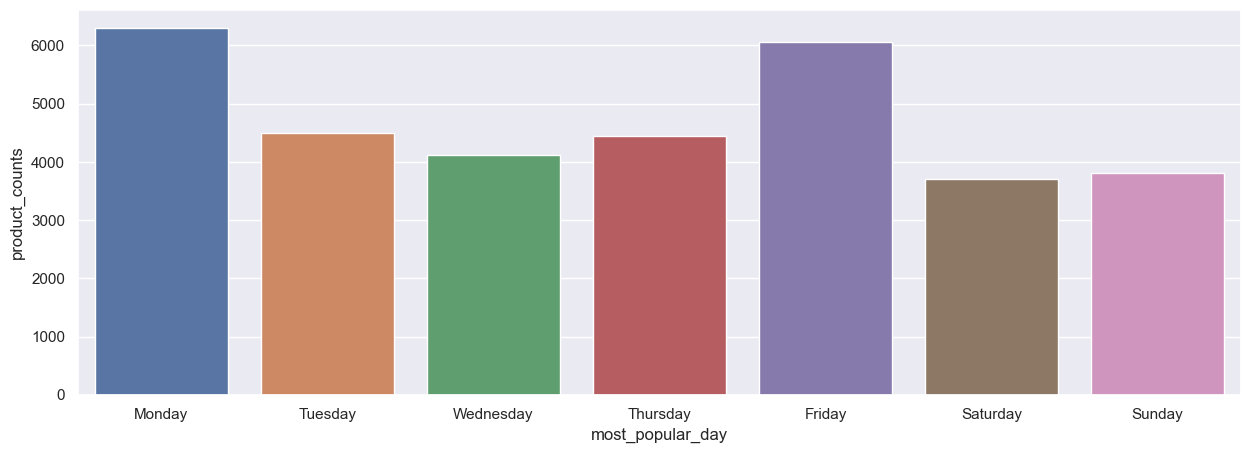

In [62]:
# распределение количества покупаемых товаров по дням

sns.set(rc={'figure.figsize': (15, 5)})
sns.barplot(data=products_to_weekday, x='most_popular_day', y='product_counts');

То есть у большинства товаров самым популярным днем приобретения являются понедельник и пятница, а непопулярными - выходные дни.

Можно посмотреть на данные под другим углом: cоздать отдельный датафрейм где покупки каждого товара разложить по дням недели, а затем аггрегировать по количеству заказа товара в конкретный день недели.  

In [63]:
products_all_weekdays = orders_items.groupby('purchase_weekday') \
                            .agg({'product_id': 'value_counts'}) \
                            .rename(columns={'product_id': 'product_counts'}) \
                            .reset_index() \
                            .rename(columns={'purchase_weekday': 'week_day'})

products_all_weekdays['week_day'] = pd.Categorical(products_all_weekdays['week_day'], categories=cats, ordered=True)
products_all_weekdays = products_all_weekdays.sort_values('week_day')

Таким образом, теперь мы можем визуализировать как часто товары покупаются в определенные дни недели.

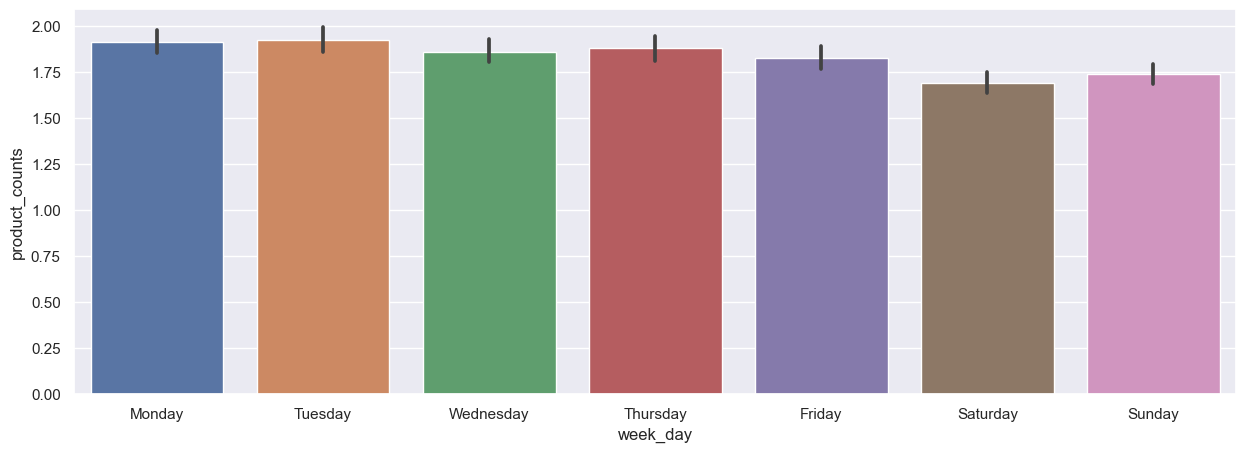

In [64]:
sns.set(rc={'figure.figsize': (15, 5)})
sns.barplot(data=products_all_weekdays, x='week_day', y='product_counts');

Кроме того, теперь можно посмотреть на эту статистику и для какого-то интересующего нас айдишника товара.

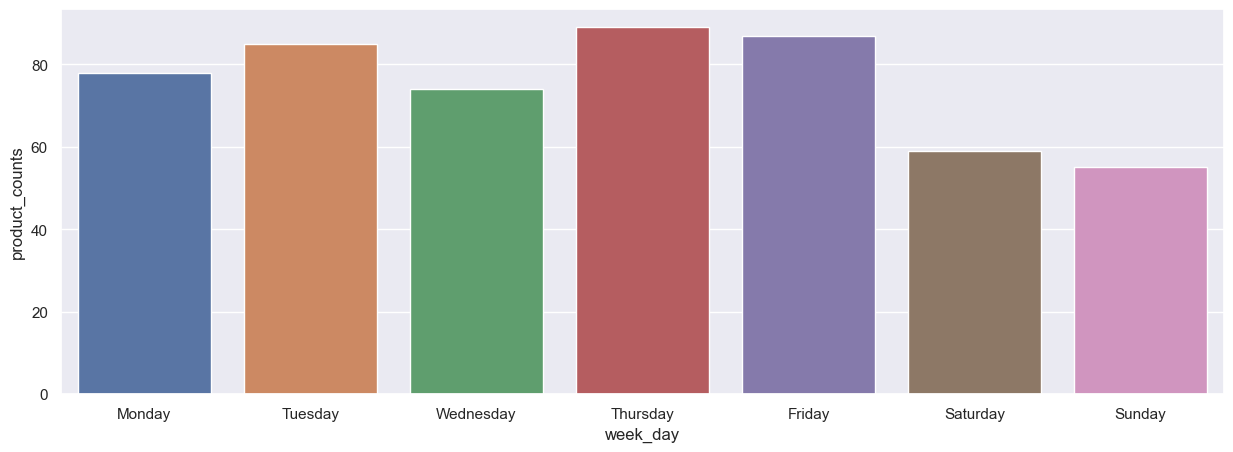

In [65]:
sns.barplot(data=products_all_weekdays[products_all_weekdays.product_id == 'aca2eb7d00ea1a7b8ebd4e68314663af'],
            x='week_day',
            y='product_counts');

Видим, что товар с номером айди `'aca2eb7d00ea1a7b8ebd4e68314663af'` чаще всего покупают по четвергам, реже всего - в воскресенье.

**Вывод**

- Каждый товар имеет индивидуальную недельную сезонность. 
- Однако, можно утверждать, что большую часть товаров предпочитают покупать по понедельникам и пятницам, выходные дни являются днями просадки по закупкам.

## 5. Анализ среднего количества покупок пользователей в неделю (по месяцам).

При анализе этого показателя будем учитывать следующие предпосылки:
    
- в месяце содержится НЕцелое число недель (например, в ноябре 2021 года 4,28 недели),
- как и ранее наиболее гарантированное подтверждение совершенной пользователем покупки считаем наличие даты в колонке `'order_approved_at'` (время подтверждения оплаты заказа) и значение `'delivered'` (доставлен пользователю) в колонке `'order_status'` (статус заказа),
- как и ранее считаем одной покупкой один чек (`order_id`).

In [66]:
# оставляем только доставленные заказы из объединения датасетов customers и orders

customers_orders = customers_orders_merged.loc[customers_orders_merged.order_approved_at.notna()] \
                                          .query('order_status == "delivered"')

customers_orders

customer_id                customer_unique_id  \
0      06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1      18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2      4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   
3      b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   
4      4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066   
...                                 ...                               ...   
99436  17ddf5dd5d51696bb3d7c6291687be6f  1a29b476fee25c95fbafc67c5ac95cf8   
99437  e7b71a9017aa05c9a7fd292d714858e8  d52a67c98be1cf6a5c84435bd38d095d   
99438  5e28dfe12db7fb50a4b2f691faecea5e  e9f50caf99f032f0bf3c55141f019d99   
99439  56b18e2166679b8a959d72dd06da27f9  73c2643a0a458b49f58cea58833b192e   
99440  274fa6071e5e17fe303b9748641082c8  84732c5050c01db9b23e19ba39899398   

       customer_zip_code_prefix          customer_city customer_state  \
0                         14409                 franca             SP   
1                          9790  sao bernardo do campo             SP   
2                          1151              sao paulo             SP   
3                          8775        mogi das cruzes             SP   
4                         13056               campinas             SP   
...                         ...                    ...            ...   
99436                      3937              sao paulo             SP   
99437                      6764        taboao da serra             SP   
99438                     60115              fortaleza             CE   
99439                     92120                 canoas             RS   
99440                      6703                  cotia             SP   

                               order_id order_status order_purchase_timestamp  \
0      00e7ee1b050b8499577073aeb2a297a1    delivered      2017-05-16 15:05:35   
1      29150127e6685892b6eab3eec79f59c7    delivered      2018-01-12 20:48:24   
2      b2059ed67ce144a36e2aa97d2c9e9ad2    delivered      2018-05-19 16:07:45   
3      951670f92359f4fe4a63112aa7306eba    delivered      2018-03-13 16:06:38   
4      6b7d50bd145f6fc7f33cebabd7e49d0f    delivered      2018-07-29 09:51:30   
...                                 ...          ...                      ...   
99436  6760e20addcf0121e9d58f2f1ff14298    delivered      2018-04-07 15:48:17   
99437  9ec0c8947d973db4f4e8dcf1fbfa8f1b    delivered      2018-04-04 08:20:22   
99438  fed4434add09a6f332ea398efd656a5c    delivered      2018-04-08 20:11:50   
99439  e31ec91cea1ecf97797787471f98a8c2    delivered      2017-11-03 21:08:33   
99440  28db69209a75e59f20ccbb5c36a20b90    delivered      2017-12-19 14:27:23   

        order_approved_at order_delivered_carrier_date  \
0     2017-05-16 15:22:12          2017-05-23 10:47:57   
1     2018-01-12 20:58:32          2018-01-15 17:14:59   
2     2018-05-20 16:19:10          2018-06-11 14:31:00   
3     2018-03-13 17:29:19          2018-03-27 23:22:42   
4     2018-07-29 10:10:09          2018-07-30 15:16:00   
...                   ...                          ...   
99436 2018-04-07 16:08:45          2018-04-11 02:08:36   
99437 2018-04-04 08:35:12          2018-04-05 18:42:35   
99438 2018-04-08 20:30:03          2018-04-09 17:52:17   
99439 2017-11-03 21:31:20          2017-11-06 18:24:41   
99440 2017-12-19 18:50:39          2017-12-21 19:17:21   

      order_delivered_customer_date order_estimated_delivery_date  
0               2017-05-25 10:35:35                    2017-06-05  
1               2018-01-29 12:41:19                    2018-02-06  
2               2018-06-14 17:58:51                    2018-06-13  
3               2018-03-28 16:04:25                    2018-04-10  
4               2018-08-09 20:55:48                    2018-08-15  
...                             ...                           ...  
99436           2018-04-13 20:06:37                    2018-04-25  
99437       

In [67]:
# количество уникальных пользователей

customers_orders.customer_unique_id.nunique()

93345

In [68]:
# количество уникальных покупок

customers_orders.order_id.nunique()

96464

Визуализируем информацию по количеству уникальных покупателей и сделанных ими заказов помесячно.

In [69]:
# преобразуем временные колонки к нужному формату

customers_orders['month'] = customers_orders["order_purchase_timestamp"].dt.month
customers_orders['year_month'] = customers_orders["order_purchase_timestamp"].dt.strftime('%Y-%m')

In [70]:
# датафрейм с уникальными покупателями за последний год

monthly_customers = customers_orders.query('year_month > "2017-08"').groupby('month', as_index=False).agg(unique_customers=('customer_unique_id', 'nunique'))

In [71]:
# датафрейм с заказами

year_monthly_orders = customers_orders.groupby('year_month', as_index=False).agg(purchases=('order_purchase_timestamp', 'nunique'))
year_monthly_customers = customers_orders.groupby('year_month', as_index=False).agg(customers=('customer_unique_id', 'nunique'))

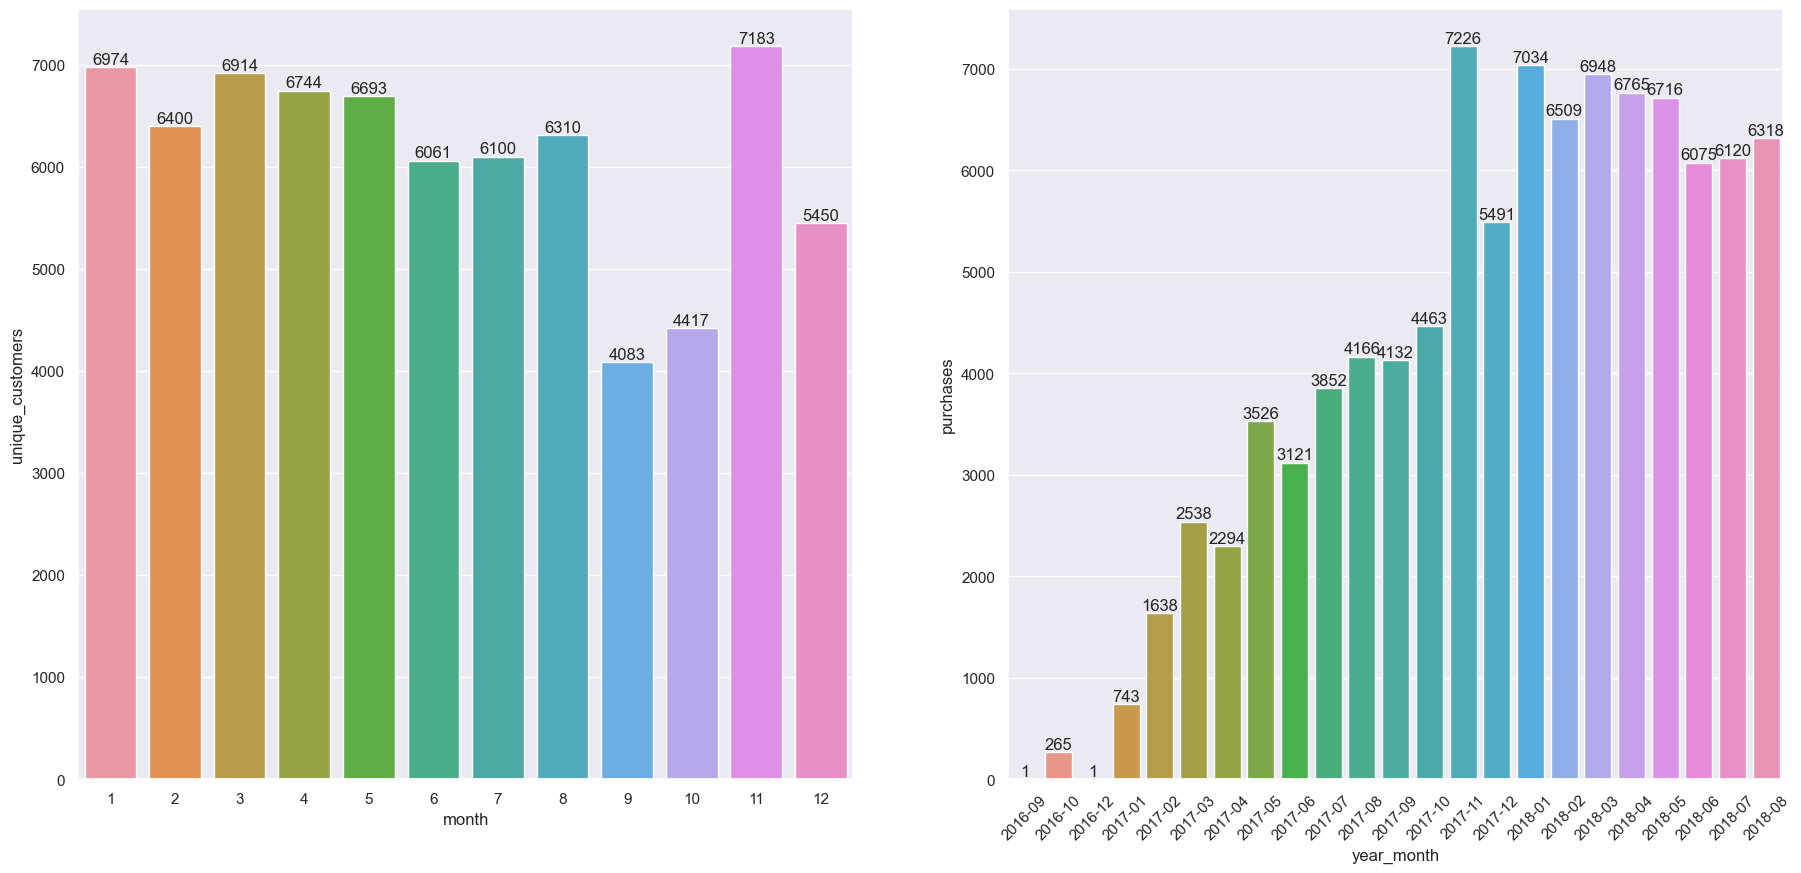

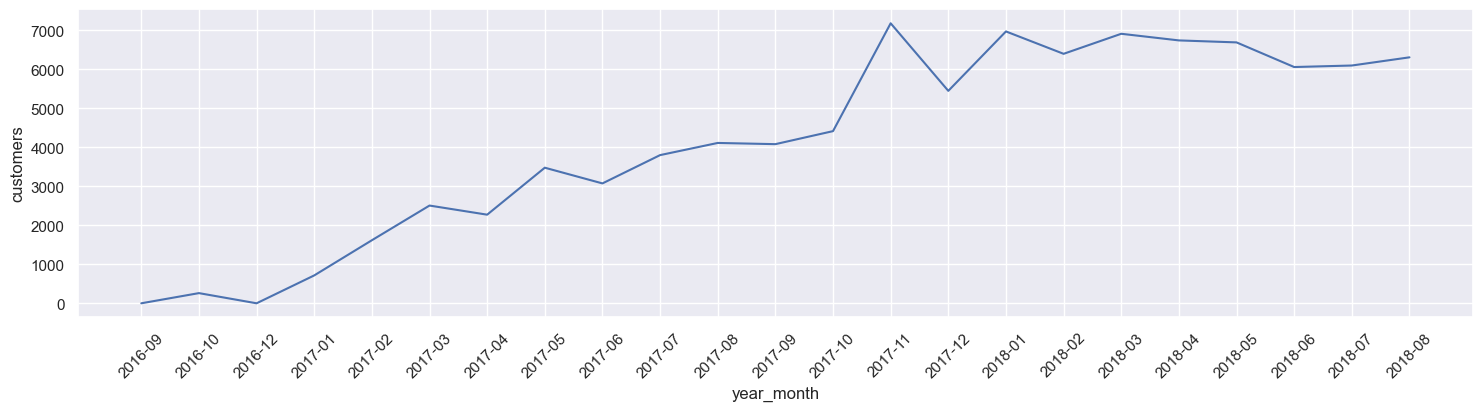

In [72]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(22, 10))

sns.barplot(data = monthly_customers, x = 'month', y = 'unique_customers', ax=ax1)

sns.barplot(data = year_monthly_orders, x = 'year_month', y = 'purchases', ax=ax2)
ax1.bar_label(ax1.containers[0])
ax2.bar_label(ax2.containers[0])
plt.xticks(rotation = 45)

fig, ax3 = plt.subplots(nrows=1, ncols=1, figsize=(18, 4))
sns.lineplot(data = year_monthly_customers, x = 'year_month', y = 'customers', ax=ax3)
plt.xticks(rotation = 45)

plt.show()

Таким образом, можно утверждать, что:
    
- количество уникальных пользователей имеет растущий тренд с пиком в районе ноября 2017 года (что в нашей доменной области, скорее всего связано с распродажей на Чёрную пятницу, когда привлекается много новых покупателей),
- за последний год количество уникальных пользователей в месяц выросло с 4083 в сентябре 2017о года до 6974 в январе 2018 (в пике),
- больше всего покупателей в ноябре (что связано с распродажей) и в начале года, далее примерно с мая тренд сменяется на нисходящий,
- тренды по покупкам пользователей повторяют такой по уникальным пользователям, в конечном итоге количество покупок, осуществляемых ежемесячно, увеличивается.

In [73]:
# cоздаем таблицу с группировкой по месяцам и пользователям и считаем для каждого количество покупок 

mean_per_week = (customers_orders                                                 
    
    # группируем по году-месяцу и пользователю
    .groupby([pd.Grouper(key="order_purchase_timestamp", freq="M"), 'customer_unique_id'])
                 
    # считаем количество (в месяц на пользователя)
    .agg({'order_purchase_timestamp': 'count'}) 
                 
     # переименовываем колонку с подсчётом
    .rename(columns={'order_purchase_timestamp': 'orders_per_month'})                     
    .reset_index()
                 
    # переименовываем колонку год-месяц           
    .rename(columns={'order_purchase_timestamp': 'year_month_order'})
                 
    # добавляем колонку количество недель в текущем месяце
    .assign(weeks_in_month = lambda x: x.year_month_order.dt.daysinmonth / 7)  
    # добавляем колонку со средним (делим количество заказов в месяц на количество недель в месяце)          
    .assign(mean_orders_per_week = lambda x: x.orders_per_month / x.weeks_in_month)      
                       
)

In [74]:
mean_per_week

year_month_order                customer_unique_id  orders_per_month  \
0           2016-09-30  830d5b7aaa3b6f1e9ad63703bec97d23                 1   
1           2016-10-31  0032c76b20340da25249092a268ce66c                 1   
2           2016-10-31  01f156677184504063bd19739f924af1                 1   
3           2016-10-31  0636d30c77f0f9cfad81f1c9b58c791f                 1   
4           2016-10-31  06bdfbbe1857c3c925ec81abfb1c9666                 1   
...                ...                               ...               ...   
95175       2018-08-31  ffc39051848c3ef2be36d1513aa3ad17                 1   
95176       2018-08-31  ffc4e1cd8aa220763480d0a18157c45d                 1   
95177       2018-08-31  ffe204b1bb8026741b839085b2fd10f2                 1   
95178       2018-08-31  ffec490ab531184a483efe2eedd68908                 1   
95179       2018-08-31  fff96bc586f78b1f070da28c4977e810                 1   

       weeks_in_month  mean_orders_per_week  
0            4.285714              0.233333  
1            4.428571              0.225806  
2            4.428571              0.225806  
3            4.428571              0.225806  
4            4.428571              0.225806  
...               ...                   ...  
95175        4.428571              0.225806  
95176        4.428571              0.225806  
95177        4.428571              0.225806  
95178        4.428571              0.225806  
95179        4.428571              0.225806  

[95180 rows x 5 columns]

Теперь в колонке `'mean_orders_per_week'` у нас есть средние значения покупок в неделю по месяцам для каждого пользователя. Мы можем визуализировать динамику покупок для любого пользователя из подборки.

In [75]:
mean_per_week[mean_per_week['customer_unique_id'] == "8d50f5eadf50201ccdcedfb9e2ac8455"]

year_month_order                customer_unique_id  orders_per_month  \
12588       2017-06-30  8d50f5eadf50201ccdcedfb9e2ac8455                 1   
16060       2017-07-31  8d50f5eadf50201ccdcedfb9e2ac8455                 2   
20055       2017-08-31  8d50f5eadf50201ccdcedfb9e2ac8455                 1   
24073       2017-09-30  8d50f5eadf50201ccdcedfb9e2ac8455                 1   
28357       2017-10-31  8d50f5eadf50201ccdcedfb9e2ac8455                 2   
34352       2017-11-30  8d50f5eadf50201ccdcedfb9e2ac8455                 1   
73713       2018-05-31  8d50f5eadf50201ccdcedfb9e2ac8455                 2   
86119       2018-07-31  8d50f5eadf50201ccdcedfb9e2ac8455                 2   
92329       2018-08-31  8d50f5eadf50201ccdcedfb9e2ac8455                 3   

       weeks_in_month  mean_orders_per_week  
12588        4.285714              0.233333  
16060        4.428571              0.451613  
20055        4.428571              0.225806  
24073        4.285714              0.233333  
28357        4.428571              0.451613  
34352        4.285714              0.233333  
73713        4.428571              0.451613  
86119        4.428571              0.451613  
92329        4.428571              0.677419

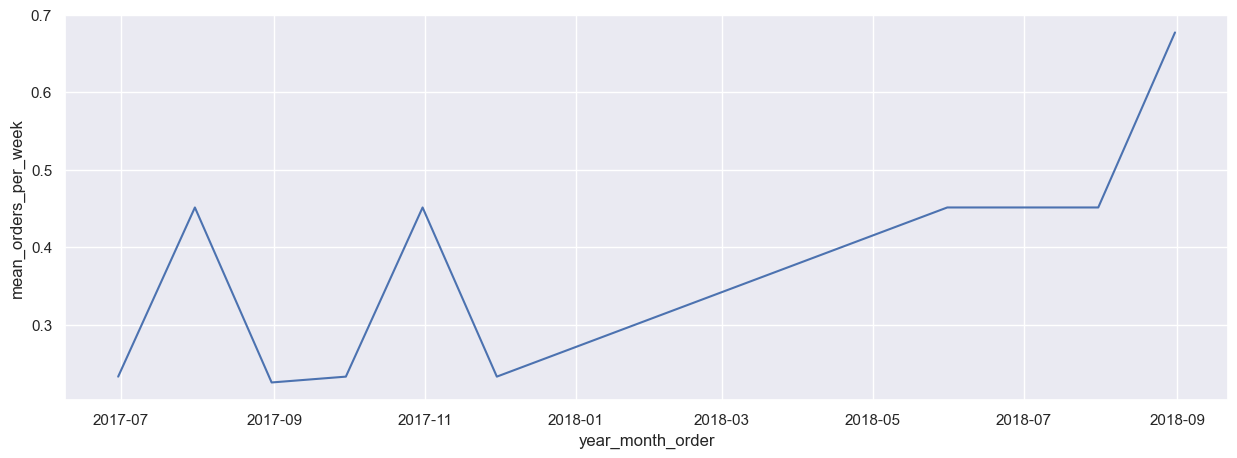

In [76]:
# график распределения среднего значения в неделю по месяцам для одного из пользователей

sns.lineplot(data=mean_per_week[mean_per_week['customer_unique_id'] == "8d50f5eadf50201ccdcedfb9e2ac8455"], 
             x='year_month_order', y='mean_orders_per_week');

In [77]:
# рассмотрим распределение значение в колонке со средними

mean_per_week['mean_orders_per_week'].value_counts()

0.225806    57020
0.233333    29085
0.250000     7852
0.451613      692
0.466667      323
0.500000      157
0.677419       25
0.700000       12
0.750000        6
1.000000        3
0.903226        2
0.933333        2
1.354839        1
Name: mean_orders_per_week, dtype: int64

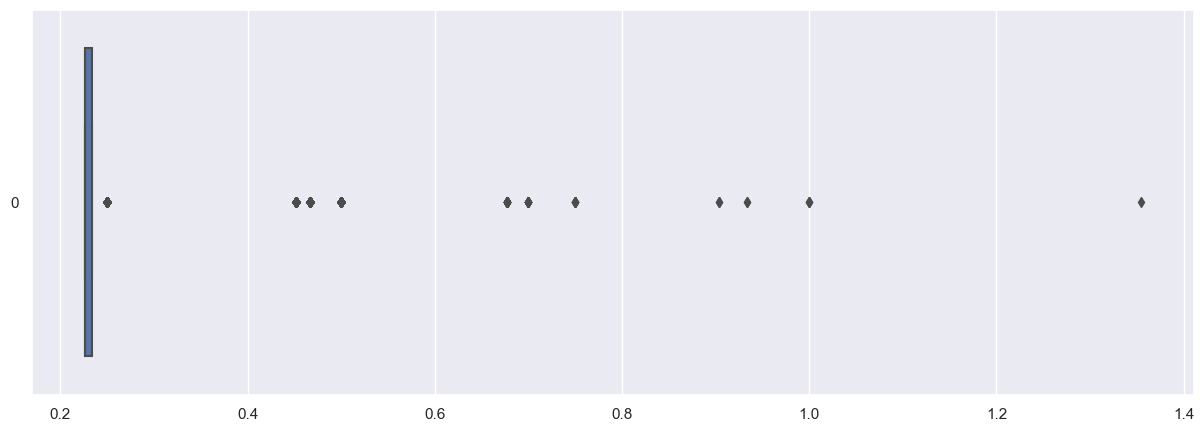

In [78]:
sns.boxplot(mean_per_week['mean_orders_per_week'], orient='h');

**Вывод**

- У подавляющего большинства пользователей в среднем менее 0,3 покупок в неделю.
- Максимальным количеством покупок в неделю является 1,35, однако, все показатели более 0,5 являются скорее выбросами и не следуют общей тенденции.

## 6. Когортный анализ аудитории. Выявление когорты с самым высоким показателем retention на 3-й месяц в период с января по декабрь.

Исследование построим следующим образом:

- `Retention` - уровень возврата пользователей, т.е. количество людей которое вернулось за покупкой после совершения первого заказа (коэффициент удержания),
- в качестве когорты принимаем месяц, в который определенное число пользователей совершило первый заказ,
- далее рассчитываем какое количество пользователей вернулось за покупкой после совершения первого заказа с периодичностью каждый месяц.

Возьмем датасет с объединенными данными по клиентам и заказам и уберем все статусы, не являющиеся покупкой - это и будет база для нашего исследования когорт.

В когортный анализ следует включить только те статусы заказов, которые относятся к завершенным заказам, то есть те, которые имеют окончательный статус после того, как заказ будет доставлен пользователю. Соответственно, в нашем случае в анализ пойдут только заказы, дл которых стоит статус `delivered`, то есть доставлен пользователю.

Остальные статусы 

- `created`, 
- `unavailable`, 
- `canceled`, 
- `approved`, 
- `invoiced`,
- `processing`, 
- `shipped`

могут быть исключены из когортного анализа, так как они отражают промежуточные этапы обработки заказа и не относятся к окончательному результату.

In [79]:
customers_orders_purchased  = customers_orders_merged.copy().query('order_status == "delivered"')

customers_orders_purchased.head()

customer_id                customer_unique_id  \
0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1  18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2  4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   
3  b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   
4  4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066   

   customer_zip_code_prefix          customer_city customer_state  \
0                     14409                 franca             SP   
1                      9790  sao bernardo do campo             SP   
2                      1151              sao paulo             SP   
3                      8775        mogi das cruzes             SP   
4                     13056               campinas             SP   

                           order_id order_status order_purchase_timestamp  \
0  00e7ee1b050b8499577073aeb2a297a1    delivered      2017-05-16 15:05:35   
1  29150127e6685892b6eab3eec79f59c7    delivered      2018-01-12 20:48:24   
2  b2059ed67ce144a36e2aa97d2c9e9ad2    delivered      2018-05-19 16:07:45   
3  951670f92359f4fe4a63112aa7306eba    delivered      2018-03-13 16:06:38   
4  6b7d50bd145f6fc7f33cebabd7e49d0f    delivered      2018-07-29 09:51:30   

    order_approved_at order_delivered_carrier_date  \
0 2017-05-16 15:22:12          2017-05-23 10:47:57   
1 2018-01-12 20:58:32          2018-01-15 17:14:59   
2 2018-05-20 16:19:10          2018-06-11 14:31:00   
3 2018-03-13 17:29:19          2018-03-27 23:22:42   
4 2018-07-29 10:10:09          2018-07-30 15:16:00   

  order_delivered_customer_date order_estimated_delivery_date  
0           2017-05-25 10:35:35                    2017-06-05  
1           2018-01-29 12:41:19                    2018-02-06  
2           2018-06-14 17:58:51                    2018-06-13  
3           2018-03-28 16:04:25                    2018-04-10  
4           2018-08-09 20:55:48                    2018-08-15

In [80]:
# количество уникальных пользователей

num_customers = customers_orders_purchased.groupby(['customer_unique_id']).order_id.nunique()

# доля пользователей сделавших более 1 заказа

mult_orders_perc = np.sum(num_customers > 1) / customers_orders_purchased.order_id.nunique()

print(f'{100 * mult_orders_perc:.2f}% пользователей сделали более одного заказа')

2.90% пользователей сделали более одного заказа


Менее 3% пользователей сделали более одного заказа, что предполагает низкие показатели `retention` в долгосрочной перспектике, однако, в сфере e-commerce это является нормой.

In [81]:
# функция для когортного анализа

def user_retention(data, customer_id, date, period='M'):
    '''
    Функция строит retention-матрицу когортного анализа (возвращает датафрейм)
    Требуются библиотеки: 
        from operator import attrgetter
        import pandas as pd
    Описание полей:
    data        - исходный датафрейм
    customer_id - колонка с id клиентов (str)
    order_date  - колонка с датами (datetime)
    period      - период разбивки (str, по умолчанию "M" - месяц)
    '''
    
    data = data.copy()
    data[date] = data[date].dt.to_period('M')      # переводим колонку дат в тип "период"
    
    # создаём когорты - таблицу с уникальными пользователями и их первой датой заказа
    users_cohorts = (
        data
            .groupby(customer_id, as_index=False)  # группируем по пользователям
            [date]                                 # выбираем колонку с датами
            .min()                                 # отбираем минимальные колонки для каждого пользователя
            .rename(columns={date: 'cohort'})      # переименовываем колонку с датами в когорты
    )
    
    
    # соединяем две таблицы для возможности последующих вычислений, сортируем и задаем соответствующие названия колонок
    cohorts_df = (
        users_cohorts                                           # датасет с когортами
            .merge(data[[customer_id, date]], on=customer_id)   # объединяем с основным датасетом по пользователям
            .sort_values('cohort')                              # сортируем по когортам
            .rename(columns={date: 'target_action_dates'})      # переименовываем колонку с датами целевых действий
    )
    
    # сгруппируем по когортам (она же дата первой покупки пользователем) и месяцам покупок 
    # посчитаем количество уникальных покупателей на каждый месяц    
    cohorts_df = (
        cohorts_df
            .groupby(['cohort', 'target_action_dates'], as_index=False)
            .agg(customer_quantity = (customer_id, 'nunique'))
    )
    
    
    # добавляем колонку периода (месяц) за все время работы данного продукта (сервиса, сайта)
    # считаем разницу между датами последующих покупок (все даты) и первой датой покупки
    cohorts_df['period_number'] = (
        cohorts_df
            .target_action_dates                  
            .sub(cohorts_df.cohort)         # вычитаем когорты из времени целевых действий
            .apply(attrgetter('n'))         # передаём атрибут номинальной единицы (переводим в целое число (количество месяцев))
    )
    
    # преобразуем данные методом "pivot" (разворачиваем таблицу)
    cohorts_pivot = cohorts_df.pivot_table(index='cohort', columns='period_number', values='customer_quantity')
    
    # размер когорты = количество пользователей в нулевой период
    cohort_size = cohorts_pivot.iloc[:, 0]
    
    # строим retention матрицу
    retention_matrix = cohorts_pivot.div(cohort_size, axis = 0)

    return retention_matrix

In [82]:
# создаём retention матрицу используя функцию

retention_matrix = user_retention(customers_orders_purchased, 'customer_unique_id', 'order_purchase_timestamp')
retention_matrix

period_number   0         1         2         3         4         5   \
cohort                                                                 
2016-09        1.0       NaN       NaN       NaN       NaN       NaN   
2016-10        1.0       NaN       NaN       NaN       NaN       NaN   
2016-12        1.0  1.000000       NaN       NaN       NaN       NaN   
2017-01        1.0  0.002789  0.002789  0.001395  0.004184  0.001395   
2017-02        1.0  0.001843  0.003071  0.001229  0.004300  0.001229   
2017-03        1.0  0.004395  0.003596  0.003995  0.003596  0.001598   
2017-04        1.0  0.006206  0.002216  0.001773  0.002660  0.002660   
2017-05        1.0  0.004636  0.004636  0.002898  0.002898  0.003187   
2017-06        1.0  0.004939  0.003951  0.004281  0.002963  0.003951   
2017-07        1.0  0.005330  0.003465  0.002399  0.002932  0.002132   
2017-08        1.0  0.006902  0.003451  0.002711  0.003451  0.005176   
2017-09        1.0  0.006993  0.005495  0.002747  0.004496  0.002248   
2017-10        1.0  0.007163  0.002542  0.000924  0.002311  0.002079   
2017-11        1.0  0.005666  0.003683  0.001700  0.001700  0.001841   
2017-12        1.0  0.002061  0.002810  0.003372  0.002623  0.002061   
2018-01        1.0  0.003362  0.003654  0.002923  0.002923  0.001608   
2018-02        1.0  0.003499  0.003976  0.003022  0.002545  0.002226   
2018-03        1.0  0.003986  0.002952  0.002952  0.001181  0.001181   
2018-04        1.0  0.005925  0.003039  0.002431  0.001367       NaN   
2018-05        1.0  0.005226  0.002613  0.001844       NaN       NaN   
2018-06        1.0  0.004253  0.002722       NaN       NaN       NaN   
2018-07        1.0  0.005211       NaN       NaN       NaN       NaN   
2018-08        1.0       NaN       NaN       NaN       NaN       NaN   

period_number        6         7         8         9         10        11  \
cohort                                                                      
2016-09             NaN       NaN       NaN       NaN       NaN       NaN   
2016-10        0.003817       NaN       NaN  0.003817       NaN  0.003817   
2016-12             NaN       NaN       NaN       NaN       NaN       NaN   
2017-01        0.004184  0.001395  0.001395       NaN  0.004184  0.001395   
2017-02        0.002457  0.001843  0.001229  0.001843  0.001229  0.003071   
2017-03        0.001598  0.003196  0.003196  0.000799  0.003596  0.001199   
2017-04        0.003546  0.003103  0.003103  0.001773  0.002660  0.000887   
2017-05        0.004057  0.001449  0.002608  0.002608  0.002608  0.003477   
2017-06        0.003622  0.002305  0.001317  0.001976  0.002963  0.003622   
2017-07        0.003198  0.001066  0.001866  0.002665  0.002132  0.002932   
2017-08        0.002958  0.002711  0.001479  0.001479  0.002465  0.001972   
2017-09        0.002248  0.002498  0.002747  0.001748  0.002498  0.000749   
2017-10        0.002079  0.003697  0.002773  0.001848  0.002079       NaN   
2017-11        0.001133  0.001841  0.001275  0.000567       NaN       NaN   
2017-12        0.001686  0.000187  0.001873       NaN       NaN       NaN   
2018-01        0.001754  0.002338       NaN       NaN       NaN       NaN   
2018-02        0.002067       NaN       NaN       NaN       NaN       NaN   
2018-03             NaN       NaN       NaN       NaN       NaN       NaN   
2018-04             NaN       NaN       NaN       NaN       NaN       NaN   
2018-05             NaN       NaN       NaN       NaN       NaN       NaN   
2018-06             NaN       NaN       NaN       NaN       NaN       NaN   
2018-07             NaN       NaN       NaN       NaN       NaN       NaN   
2018-08             NaN       NaN       NaN       NaN       NaN       NaN   

period_number        12        13        14        15        16        17  \
cohort                                                                      
2016-09             NaN       NaN       NaN       NaN       NaN       NaN   
2016-10             NaN  0.003817       Na

In [83]:
# применим форматирование отображения датафрейма
# переводим все в процентные значения
# применяем цветовую карту 

cohort_analysis = (retention_matrix
            .style
            .set_caption('User retention by cohort')            # добавляем подпись                 
            .background_gradient(cmap='icefire')                # раскрашиваем ячейки по столбцам 
            .highlight_null('white')                            # делаем белый фон для значений NaN 
            .format("{:.2%}", na_rep=""))                       # числа форматируем как проценты, NaN заменяем на пустоту 

cohort_analysis

In [84]:
# когорта с максимальным retention на третий месяц 
# в период с января по декабрь 2017 г.

print(retention_matrix.loc['2017-01':'2017-12', 3].idxmax())

2017-06


**Вывод**

В результате проведения когортного анализа пользователей было выявлено, что в период с января по декабрь 2017 года самый высокий `retention` на 3й месяц был у когорты, пришедшей в июне, он составил 0,43%.

В 2018м году средняя возвращаемость 3го месяца держится в районе 0,30%, но у нас мало данных, чтобы прогнозировать его на далеко идущую перспективу.

## 7. Построение RFM-сегментации пользователей для оценки аудитории.

RFM анализ - это маркетинговая техника, которая используетс для сегментации и количественной оценки групп покупателей, основываясь на трех показателях: 

- `R - recency` — время от последней покупки пользователя до текущей даты (как давно клиенты что-то покупали);
- `F - frequency` — суммарное количество покупок у пользователя за всё время (как часто клиенты покупают);
- `M - monetary` — суммарное количество денег, потраченных пользователем (сумма покупок за всё время).

По каждому из этих признаков мы выделяем по несколько групп (точное количество определим в процессе). Затем присваиваем каждой группе числовое обозначение от 1 до n, где n - число кластеров.

Это позволяет идентифицировать разные категории пользователей и организовать под них таргетные маркетинговые кампании.

### 7.1. Установление периода для анализа.

Установим на основании данных период, за который будем считать показатели (в днях). 

Период времени, за который проводится RFM-анализ, зависит от целей и задач, которые мы ставим перед собой. Обычно, для изучения поведения клиентов используется период от нескольких месяцев до года. Например, за год можно проанализировать, как часто покупают клиенты, какие траты они производят, и насколько активно они пользуются продуктом или услугой. Важно, чтобы выбранный период был достаточно длинным, чтобы получить репрезентативную выборку клиентов, и не слишком длинным, чтобы данные не утратили свою актуальность и ценность.

Оценим даты, чтобы понимать за какой временной промежуток нам следует считать метрики. 

In [85]:
# дата первого заказа

first_order_date = customers_orders.order_purchase_timestamp.min()
first_order_date 

Timestamp('2016-09-15 12:16:38')

In [86]:
# дата последнего заказа

last_order_date = customers_orders.order_purchase_timestamp.max()
last_order_date

Timestamp('2018-08-29 15:00:37')

In [87]:
# разница между датами последнего и первого заказов в днях

customers_orders['order_purchase_timestamp'].max() - customers_orders['order_purchase_timestamp'].min()

Timedelta('713 days 02:43:59')

Дата последнего заказа - 29 сентября 2018, более новых данных у нас нет. Разница между датами первого и последнего заказа составляет около 713 дней.

Чтобы провести анализ на максимально релевантных данных, возьмем за условную дату отсчета максимальную дату заказа в датафрейме, а период ограчиним 365 днями, которые отсчитаем назад с максимальной даты. 

In [88]:
# условня "сегодняшняя" дата

conditional_today_date =  customers_orders.order_purchase_timestamp.max()
conditional_today_date

Timestamp('2018-08-29 15:00:37')

In [89]:
# дата начала периода для RFM-анализа

start_date = conditional_today_date - pd.Timedelta(365, unit='day')
start_date

Timestamp('2017-08-29 15:00:37')

### 7.2. Подготовка данных.

Подготовим датасет для RFM-анализа, для этого смёрджим все три таблицы (они все связаны через `customer_id`).

Далее отфильтруем данные по наличию даты в колонке `"order_approved_at"` (время подтверждения оплаты заказа) и значению `"delivered"` (доставлен пользователю) в колонке `"order_status"` (статус заказа), чтобы в выборку вошли ТОЛЬКО полностью завершенные заказы.

In [90]:
customers_orders = customers.merge(orders, on='customer_id')
total_merge = customers_orders.merge(items, on='order_id')

rfm_merge = total_merge[total_merge.order_approved_at.notna()].query('order_status == "delivered"')
rfm_merge

customer_id                customer_unique_id  \
0       06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1       18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2       4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   
3       b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   
4       4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066   
...                                  ...                               ...   
112645  17ddf5dd5d51696bb3d7c6291687be6f  1a29b476fee25c95fbafc67c5ac95cf8   
112646  e7b71a9017aa05c9a7fd292d714858e8  d52a67c98be1cf6a5c84435bd38d095d   
112647  5e28dfe12db7fb50a4b2f691faecea5e  e9f50caf99f032f0bf3c55141f019d99   
112648  56b18e2166679b8a959d72dd06da27f9  73c2643a0a458b49f58cea58833b192e   
112649  274fa6071e5e17fe303b9748641082c8  84732c5050c01db9b23e19ba39899398   

        customer_zip_code_prefix          customer_city customer_state  \
0                          14409                 franca             SP   
1                           9790  sao bernardo do campo             SP   
2                           1151              sao paulo             SP   
3                           8775        mogi das cruzes             SP   
4                          13056               campinas             SP   
...                          ...                    ...            ...   
112645                      3937              sao paulo             SP   
112646                      6764        taboao da serra             SP   
112647                     60115              fortaleza             CE   
112648                     92120                 canoas             RS   
112649                      6703                  cotia             SP   

                                order_id order_status  \
0       00e7ee1b050b8499577073aeb2a297a1    delivered   
1       29150127e6685892b6eab3eec79f59c7    delivered   
2       b2059ed67ce144a36e2aa97d2c9e9ad2    delivered   
3       951670f92359f4fe4a63112aa7306eba    delivered   
4       6b7d50bd145f6fc7f33cebabd7e49d0f    delivered   
...                                  ...          ...   
112645  6760e20addcf0121e9d58f2f1ff14298    delivered   
112646  9ec0c8947d973db4f4e8dcf1fbfa8f1b    delivered   
112647  fed4434add09a6f332ea398efd656a5c    delivered   
112648  e31ec91cea1ecf97797787471f98a8c2    delivered   
112649  28db69209a75e59f20ccbb5c36a20b90    delivered   

       order_purchase_timestamp   order_approved_at  \
0           2017-05-16 15:05:35 2017-05-16 15:22:12   
1           2018-01-12 20:48:24 2018-01-12 20:58:32   
2           2018-05-19 16:07:45 2018-05-20 16:19:10   
3           2018-03-13 16:06:38 2018-03-13 17:29:19   
4           2018-07-29 09:51:30 2018-07-29 10:10:09   
...                         ...                 ...   
112645      2018-04-07 15:48:17 2018-04-07 16:08:45   
112646      2018-04-04 08:20:22 2018-04-04 08:35:12   
112647      2018-04-08 20:11:50 2018-04-08 20:30:03   
112648      2017-11-03 21:08:33 2017-11-03 21:31:20   
112649      2017-12-19 14:27:23 2017-12-19 18:50:39   

       order_delivered_carrier_date order_delivered_customer_date  \
0               2017-05-23 10:47:57           2017-05-25 10:35:35   
1               2018-01-15 17:14:59           2018-01-29 12:41:19   
2               2018-06-11 14:31:00           2018-06-14 17:58:51   
3               2018-03-27 23:22:42           2018-03-28 16:04:25   
4               2018-07-30 15:16:00           2018-08-09 20:55:48   
...                             ...                           ...   
112645          2018-04-11 02:08:36           2018-04-13 20:06:37   
112646          2018-04-05 18:42:35           2018-04-11 18:54:45   
112647          2018-04-09 17:52:17           2018-05-09 19:03:15   
112648          2017-11-06 18:24:41           2017-11-16 19:58:39   
112649          2017-12-21 19:17:21           2017-12-26 18:42:36   

       order_estimated_deliv

Посмотрим на динамику активности уникальных пользователей и количества сделанных заказов по месяцам.

In [91]:
# введем колонку с "месяц-год" заказа

rfm_merge['month_year'] = pd.to_datetime(rfm_merge.order_purchase_timestamp.dt.strftime('%Y-%m-01'))

In [92]:
px.bar(
    rfm_merge.groupby('month_year', as_index=False)['customer_unique_id'].nunique().rename(columns={'customer_unique_id':'unique_customers'}),
    x='month_year',
    y='unique_customers',
    title='Динамика месячной активности уникальных пользователей'
).show()


px.bar(
    rfm_merge.groupby('month_year', as_index=False)['order_id'].nunique().rename(columns={'order_id':'orders_count'}),
    x='month_year',
    y='orders_count',
    title='Динамика месячного количества заказов'
).show()

Для проведения RFM-сегментации аудитории нас будут интересовать следующие колонки датафрейма:

- уникальный id клиента,
- даты покупок,
- id заказа,
- цены товаров.

Из них мы найдём последнюю дату покупки, общую потраченную пользователем сумму (через суммирование цен товаров в его заказах) и количество заказов на пользователя.

In [93]:
# датафрейм для анализа за весь период времени

pre_rfm_all_years = (
    rfm_merge
        .copy()

    # сначала сгруппируем по заказам
        .groupby('order_id', as_index=False)                     
        .agg({
            'price': 'sum',                               # найдём сумму заказа
            'customer_unique_id': 'first',                # сохраним колонку пользователя, взяв первый элемент из группы
            'order_purchase_timestamp': 'max'             # оставим последнюю дату
        })
    
    # теперь группируем по пользователям
        .groupby('customer_unique_id', as_index=False)           
        .agg({
            'price': 'sum',                               # выручка с пользователя
            'order_id': 'count',                          # количество покупок
            'order_purchase_timestamp': 'max'})           # последнее время заказа
        .rename(columns={
            'price': 'total_revenue', 
            'customer_unique_id': 'customer',
            'order_id': 'purchases_quantity',
            'order_purchase_timestamp': 'last_order'
        })
        .assign(days_since_last_order = lambda x:                  # добавляем колонку с разницей между условным сегодняшним днём и последней покупкой в днях
                (
                    conditional_today_date.to_period('D') - x.last_order.dt.to_period('D')
                )
                .apply(attrgetter('n'))                   # передадим созданной колонке атрибут n, чтобы задать номинальные единицы изменения (дни)
               )
)

Так как отчётный период один год, подготовим вариант датафрэйма с такими же группировками, отфильтровав исходный датафрейм соответствующим образом.

In [94]:
# датафрем для анализа за один год

pre_rfm = (
    rfm_merge
        .copy()
        .query('order_purchase_timestamp >= @start_date') 
    
    # сначала сгруппируем по заказам
        .groupby('order_id', as_index=False)                     
        .agg({
            'price': 'sum',                               # найдём сумму заказа
            'customer_unique_id': 'first',                # сохраним колонку пользователя, взяв первый элемент из группы
            'order_purchase_timestamp': 'max'             # оставим последнюю дату
        })
    
    # теперь группируем по пользователям
        .groupby('customer_unique_id', as_index=False)           
        .agg({
            'price': 'sum',                               # выручка с пользователя
            'order_id': 'count',                          # количество покупок
            'order_purchase_timestamp': 'max'})           # последнее время заказа
        .rename(columns={
            'price': 'total_revenue', 
            'customer_unique_id': 'customer',
            'order_id': 'purchases_quantity',
            'order_purchase_timestamp': 'last_order'
        })
        .assign(days_since_last_order = lambda x:                  # добавляем колонку с разницей между условным сегодняшним днём и последней покупкой в днях
                (
                    conditional_today_date.to_period('D') - x.last_order.dt.to_period('D')
                )
                .apply(attrgetter('n'))                   # передадим созданной колонке атрибут n, чтобы задать номинальные единицы изменения (дни)
               )
)

In [95]:
pre_rfm.head()

customer  total_revenue  purchases_quantity  \
0  0000366f3b9a7992bf8c76cfdf3221e2         129.90                   1   
1  0000b849f77a49e4a4ce2b2a4ca5be3f          18.90                   1   
2  0000f6ccb0745a6a4b88665a16c9f078          25.99                   1   
3  0004aac84e0df4da2b147fca70cf8255         180.00                   1   
4  0004bd2a26a76fe21f786e4fbd80607f         154.00                   1   

           last_order  days_since_last_order  
0 2018-05-10 10:56:27                    111  
1 2018-05-07 11:11:27                    114  
2 2017-10-12 20:29:41                    321  
3 2017-11-14 19:45:42                    288  
4 2018-04-05 19:33:16                    146

Основная сложность проведения анализа — определить границы сегментов.

Чтобы понять, что есть норма для конкретно этого бизнеса, посмотрим на медианные, средние, минимальные и максимальные значения данных, а также более детально посмотрим на их распределения.

In [96]:
pre_rfm.describe()

total_revenue  purchases_quantity  days_since_last_order
count   72620.000000        72620.000000           72620.000000
mean      141.228375            1.027334             173.104475
std       212.199960            0.186237             100.068317
min         0.850000            1.000000               0.000000
25%        47.900000            1.000000              88.000000
50%        89.800000            1.000000             172.000000
75%       152.000000            1.000000             261.000000
max     13440.000000           11.000000             365.000000

- **Доход с пользователя**: 75-й процентиль 152, а максимум - 13440, к тому же среднее и медианное значения отличаются значительно. Среднюю меру здесь описывает медиана 89.8, а высокий максимум обусловлен выбросами - редкими покупками на очень большие суммы.

- **Количество покупок**: подавляющее большинство покупателей делают одну покупку, также как и в случае со средним чеком имеют место выбросы вплоть до 11 покупок.

- **Количество дней с последней покупки**: здесь картина более-менее равномерная, среднее и медиана почти равны.

### 7.3. Рассчет метрики Monetary.

`'Monetary'` представляет собой полную сумму денег, которую покупатель потратил на покупки продуктов или сервисов нашего магазина за данный период времени (в нашем случае последний год). Является одной из ключевых метрик, так как предполагается, что пользователи, которые много потратили в прошлом, способны много потратить и на будущие нужды.

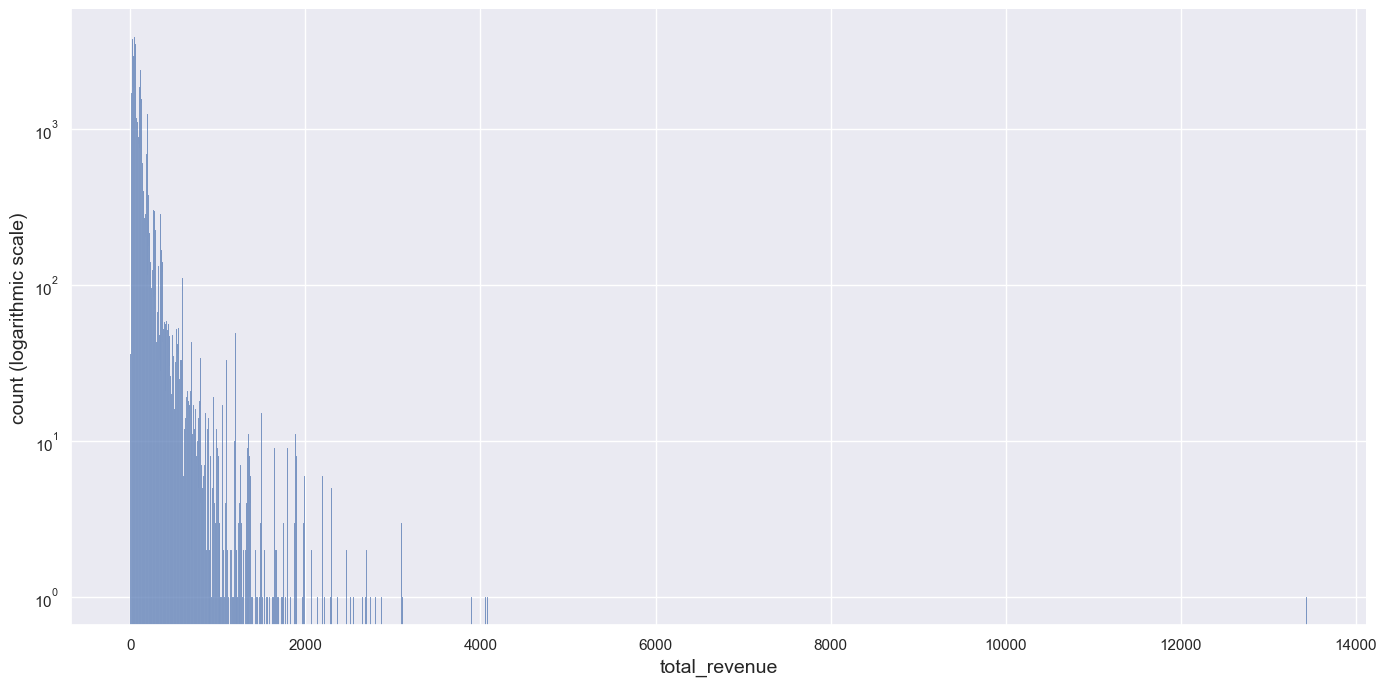

In [97]:
# распределение выручки с покупателя с логарифмической шкалой Y

sns.displot(pre_rfm.total_revenue, height=7, aspect=2, log_scale=(False, True))
plt.xlabel("total_revenue", size=14)
plt.ylabel("count (logarithmic scale)", size=14);

Распределение сильно скошено влево, что является характерной ситуацией для выручки, в нем есть одиночные выбросы, которые создают сильный хвост.

Дабы не ориентировать на выбросы при выборе диапазонов для сегментации, выделим 97.5%-перцентиль и рассмотрим данные внутри него поподробнее.

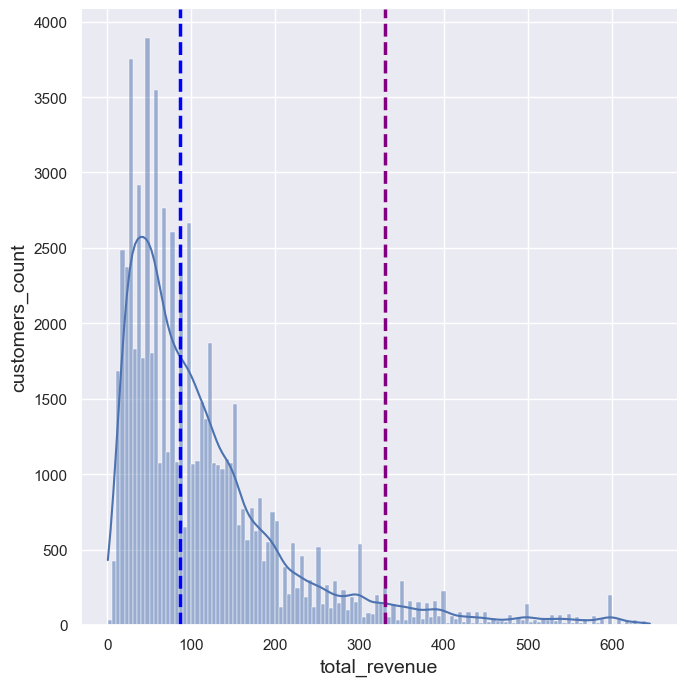

In [98]:
# распределение выручки с покупателя, левая часть более детально 

monetary_975 = pre_rfm.total_revenue.quantile(q=0.975)

# выборка по 97.5%-перцентилю (615)
monetary_lower_975 = pre_rfm.total_revenue[pre_rfm.total_revenue < monetary_975]

sns.displot(monetary_lower_975, height=7, aspect=1, kde=True)
plt.xlabel("total_revenue", size=14)
plt.ylabel("customers_count", size=14)

# определяем по этой выборке 50%-перцентиль (медиану) и 95%-перцентиль

plt.axvline(x=monetary_lower_975.quantile(q=0.5),              # синяя пунктирная линия - граница между 1 и 2 группами
            color='blue',
            ls='--', 
            lw=2.5)
plt.axvline(x=monetary_lower_975.quantile(q=0.95),             # фиолетовая пунктирная линия - граница между 2 и 3 группами
            color='purple',
            ls='--', 
            lw=2.5);

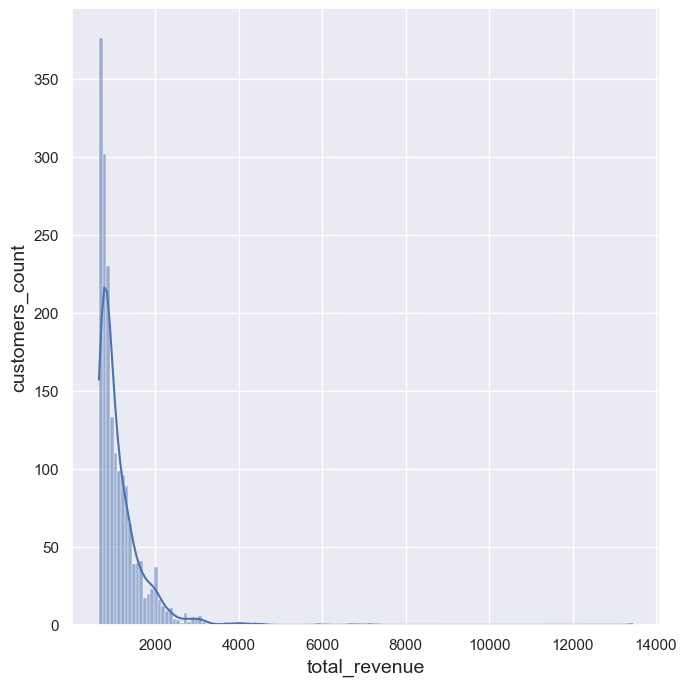

In [99]:
# часть данных, представляющая собой всего 2.5% пользователей

monetary_higher_975 = pre_rfm.total_revenue[pre_rfm.total_revenue > monetary_975]

sns.displot(monetary_higher_975, height=7, aspect=1, kde=True)
plt.xlabel("total_revenue", size=14)
plt.ylabel("customers_count", size=14);

Значения, лежащие за порогом 97.5% также характеризуются высокой степенью ненормальности, они имеют свой пик слева и сильный нисходящий тренд.

Рассмотрим каждый фрагмент данных по-отдельности, чтобы определиться с границами диапазонов.

In [100]:
# сохраним значения основных перцентилей для дальнейшей работы с ними

monetary_25 = pre_rfm.total_revenue.quantile(0.25).round(2)
monetary_50 = pre_rfm.total_revenue.quantile(0.50).round(2)
monetary_75 = pre_rfm.total_revenue.quantile(0.75).round(2)
monetary_95 = pre_rfm.total_revenue.quantile(0.95).round(2)

print(monetary_25, monetary_50 , monetary_75, monetary_95)

47.9 89.8 152.0 418.41


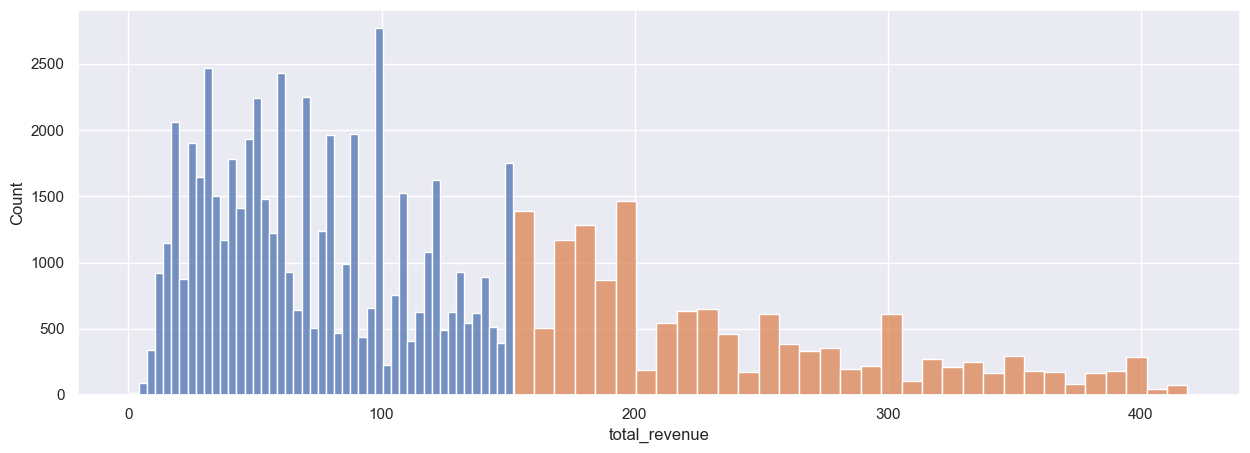

In [101]:
# визуализируем распределение по 75 и 95 перцентилям

sns.histplot(pre_rfm.query('total_revenue <= @monetary_75').total_revenue)                   # 75% пользователей
sns.histplot(pre_rfm.query('@monetary_75 < total_revenue <= @monetary_95').total_revenue);   # 20% пользователей

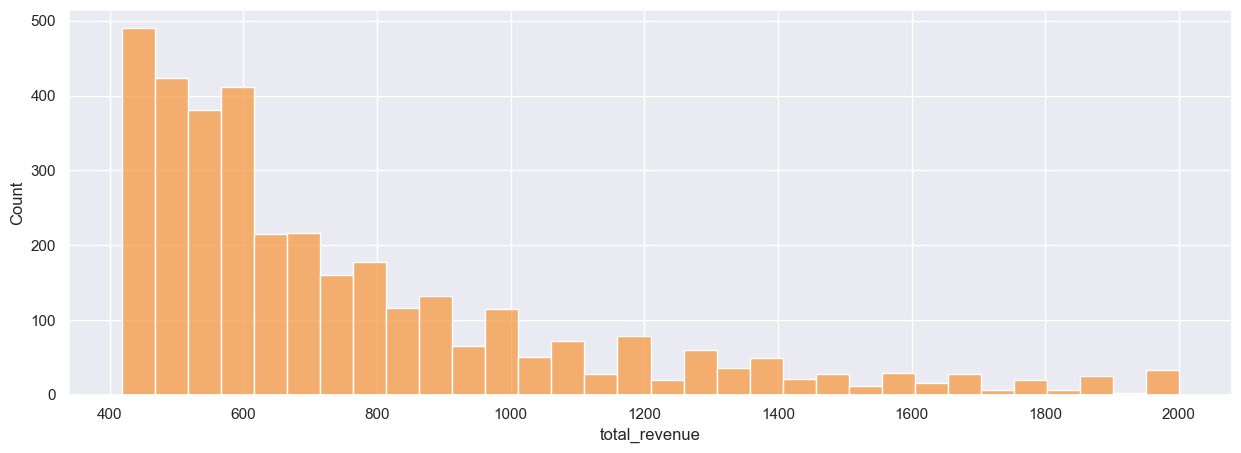

In [102]:
sns.histplot(pre_rfm.query('@monetary_95 < total_revenue <= 2000').total_revenue, color='#f79a43');  # 4.8% пользователей

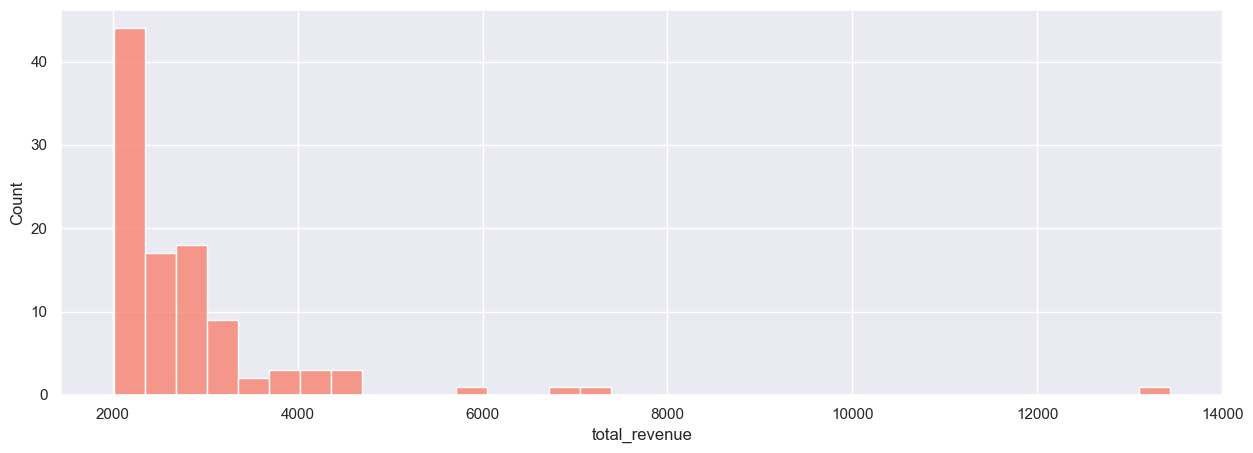

In [103]:
sns.histplot(pre_rfm.query('2000 < total_revenue').total_revenue, color='#fa7a69'); # 0.2% пользователей

Попытаемся определить примерные интервалы сегментов экспертным способом с помощью графиков. Глядя на распределение можно выделить следующие группы: 

- `Группа 1` -  от 0 до значения медианы - 90 (50% пользователей),
- `Группа 2` - свыше 90 до 95%-перцентиля 420 (45% пользователей).
- `Группа 3` - свыше 420, там где совершается небольшое число заказов с высоким показателем среднего чека (оставшиеся 5% пользователей).

### 7.4. Применение метода К-средних для определения порогов кластеров для каждой из метрик.

Помимо экспертного метода, количество кластеров для сегментации пользователей можно определить с помощью метода локтя. 

Его суть заключается в использовании алгоритма KMeans (метод k-средних), который представляет собой классическое "обучение без учителя", когда алгоритм, обучаясь на данных, сам находит в них закономерности.

Напишем функцию, которая будет осуществлять полный пайплайн для построения такого графика.

In [104]:
def optimal_cluster_number(X, n_cluster_max=7):
    '''
    функция рисует график для определения оптимального количества кластеров, который строится с помощью метода локтя 
    X - пандосовская серия
    n_clucter_max - максимальное количество кластеров
    '''
    error_rates = []
    
    for i in range(1, n_cluster_max + 1):
        model = KMeans(n_clusters = i, random_state = 42)                    # создадим экземпляр класса KMeans
        model.fit(X.values.reshape(-1, 1))                                   # преобразуем 1D массив в 2D и обучим модель 
        error_rates.append(model.inertia_)                                   # наполняем список для построения графика

    plt.plot(range(1, n_cluster_max + 1), error_rates)
    plt.xlabel("number_of_clusters", size=14)
    plt.ylabel("errors", size=14)

Находим оптимальное количество кластеров для выручки. Сначала попробуем привести колонку с выручкой к нормальному виду настолько, насколько это возможно, с помощью Box-Cox трансформации, иначе имеющиеся выбросы исказят результат.

In [105]:
# трансформируем выручку и соединим с нетрансформированной

transformed_data, best_lambda = boxcox(pre_rfm.total_revenue)
trans_revenue = pd.DataFrame(transformed_data, columns=['trans_bill'])
trans_revenue['total_revenue'] = pre_rfm.total_revenue

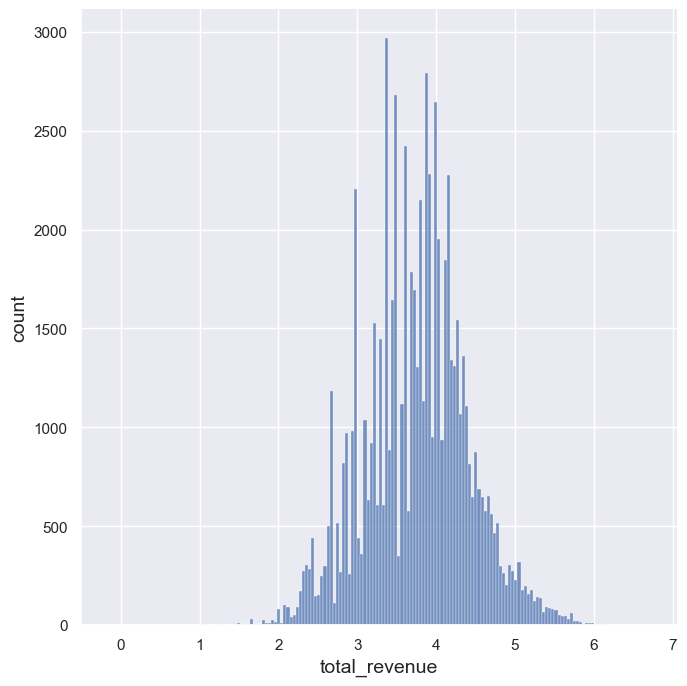

In [106]:
# распределение выручки покупателя после Box-Cox трансформации

sns.displot(trans_revenue.trans_bill, height=7, aspect=1)
plt.xlabel("total_revenue", size=14)
plt.ylabel("count", size=14);

Распределение метрики выручки выровнялось и приняло колоколообразную форму, близкую к нормальной.

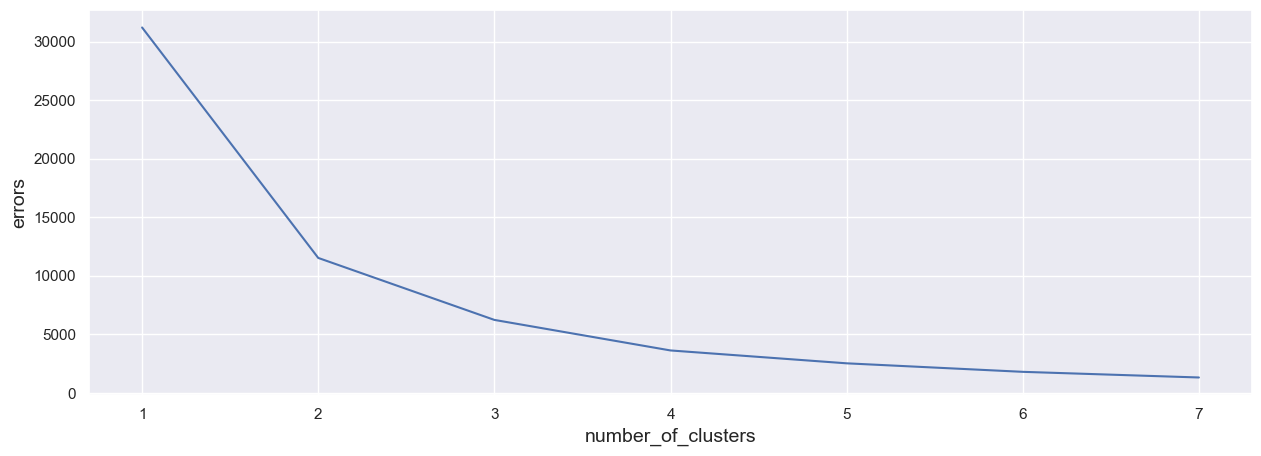

In [107]:
# найдем оптимальное количество кластеров

optimal_cluster_number(trans_revenue.trans_bill)

Оптимальным количеством кластеров можно считать 3, так как после этого порога ошибки перестают резко падать, тенденция уменьшения становится более плавной.

Теперь мы можем написать функцию для определения границ.

In [108]:
def get_borders(X, n_clusters):
    '''
    функция возвращает список границ кластеров
    принимает на вход:
        X - пандосовская серия
        n_clusters - количество кластеров
    '''
    model = KMeans(n_clusters=n_clusters, random_state = 0)     # создадим экземпляр класса KMeans
    model.fit(X.values.reshape(-1, 1))                           # преобразуем 1D массив в 2D и обучим модель 
    clusters = model.labels_                                    # кластеры   

    df = X.to_frame()                                           # переведём серию в датафрейм
    df['clusters'] = clusters                                   # добавим колонку с кластерами

    borders = [df.iloc[:, 0].min()]                             # добавим минимальное значение в список
    
    for i in range(n_clusters):
        border = df.query('clusters == @i').iloc[:, 0].max()    # отбираем максимальные значения при определённых значениях clusters
        borders.append(border)                                  # добавляем в список
    
    return sorted(borders)                                      # возвращаем сортированный список границ

In [109]:
# границы трансформированного прайса

m_borders_trans = get_borders(trans_revenue.trans_bill, 3)
m_borders_trans

[-0.16355438866052094, 3.3998947986075234, 4.212921021492634, 6.71051550980702]

In [110]:
# переведём границы трансформированного прайса в нетрансформированные

m_borders = []
for i in m_borders_trans:
    m_borders.append(trans_revenue[trans_revenue.trans_bill == i].total_revenue.values[0])

In [111]:
# границы интервалов Monetary

m_borders

[0.85, 52.0, 165.48, 13440.0]

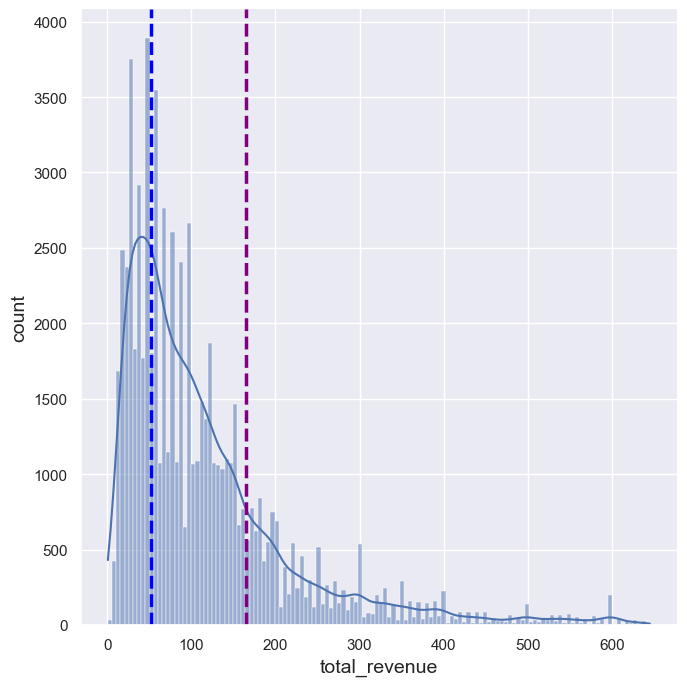

In [183]:
# распределение выручки от покупателя, с нанесёнными границами (левая часть более детально)

sns.displot(pre_rfm.total_revenue[pre_rfm.total_revenue < monetary_975], height=7, aspect=1, kde=True)
plt.xlabel("total_revenue", size=14)
plt.ylabel("сount", size=14)

plt.axvline(x=m_borders[1],              # синяя пунктирная линия - граница между 1 и 2 группами
            color='blue',
            ls='--', 
            lw=2.5)
plt.axvline(x=m_borders[2],             # фиолетовая пунктирная линия - граница между 2 и 3 группами
            color='purple',
            ls='--', 
            lw=2.5);

**Вывод**

Так как распределение выручки имеет сильную скошенную влево форму, а также большое количество выбросов (высокие суммы заказов, сделанных единственный раз), то определение границ сегментов представляет собой нетривиальную задачу.

Решить ее можно либо с помощью экспертного мнения (через анализ графиков и квартилей), либо посредством алгоритма k-Means и метода локтя.

Назначим рейтинги (номера кластеров) для колонки с метрикой `Monetary` с помощью оценки по методу локтя, для этого передадим параметры границ в функцию, которая классифицирует по ним датафрейм.

In [195]:
# назначаем рейтинг для Monetary

m_labels = (1, 2, 3)
m_score_bins = m_borders

m_score = (
    pd.cut(pre_rfm.total_revenue, 
                   bins = m_score_bins, 
                   labels = m_labels, 
                   right=True,
                   include_lowest = True)
)

### 7.5. Рассчет метрики Frequency.

`Frequency` является метрикой количества покупок пользователя или его взаимодействия с брендом в течение определенного промежутка времени. Являетс одним из ключевых показателей, так как показывает, насколько глубоко покупатель вовлечен в продукт/бренд/сервис. Более высокие показатели отражают высокую степень лояльности, так как пользователи, которые сделали покупку хоть раз, вероятнее всего вернутся снова.

In [114]:
# доля пользователей, сделавших только один заказ

single_order_perc = (
    pre_rfm.purchases_quantity.value_counts()[1]
    /
    pre_rfm.purchases_quantity.count()
)
print(f'{100 * single_order_perc:.2f}% пользователей сделали только один заказ.')

97.51% пользователей сделали только один заказ.


In [115]:
pre_rfm.purchases_quantity.value_counts()

1     70810
2      1688
3        95
4        17
5         5
7         3
9         1
11        1
Name: purchases_quantity, dtype: int64

Наши данные показывают, что всего 2,5% пользователей возвращаются и делают повторный заказ. Для e-commerce это частая ситуация, но эти данные следует учесть при кластеризации пользователей.

Оценим распределение признака.

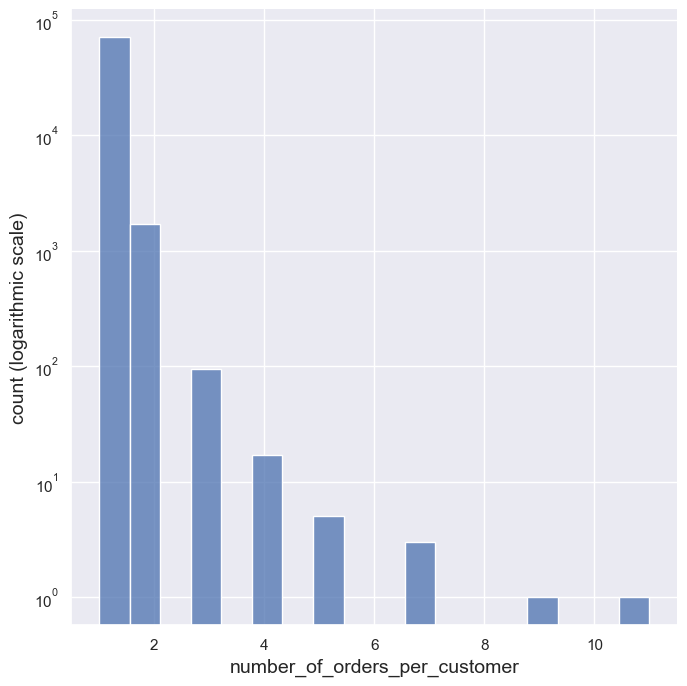

In [185]:
# распределение количества заказов покупателя с логарифмической шкалой Y

sns.displot(pre_rfm.purchases_quantity, height=7, aspect=1, log_scale=(False, True))
plt.xlabel("number_of_orders_per_customer", size=14)
plt.ylabel("сount (logarithmic scale)", size=14);

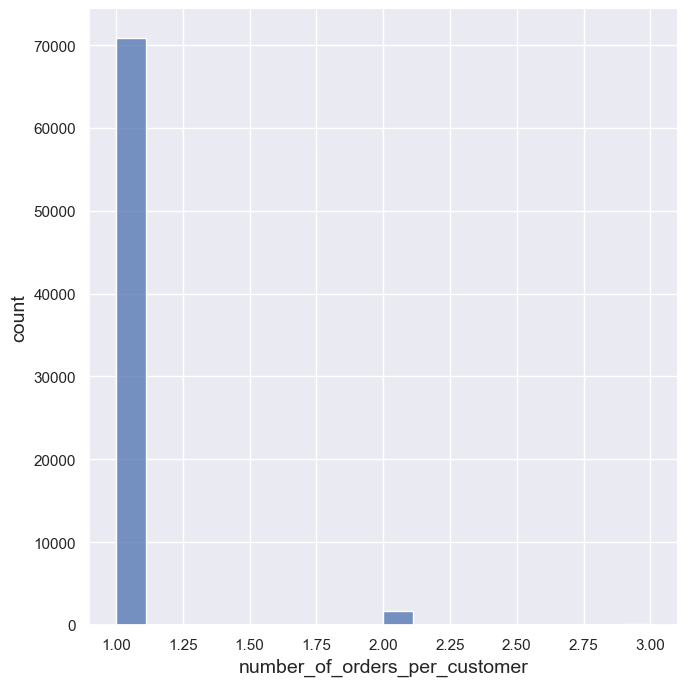

In [187]:
# распределение количества заказов на покупателя с количеством покупок <= 3

sns.displot(pre_rfm.purchases_quantity[pre_rfm.purchases_quantity <= 3], height=7)
plt.xlabel("number_of_orders_per_customer", size=14)
plt.ylabel("count", size=14);

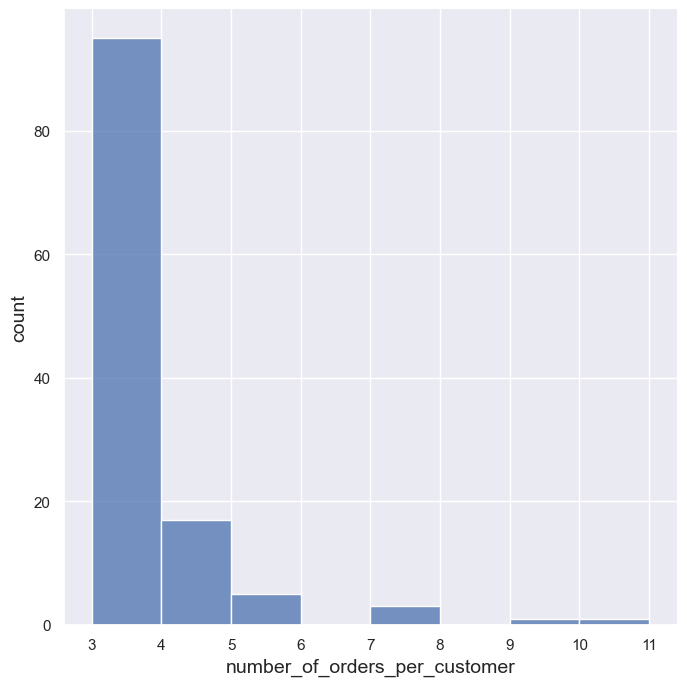

In [188]:
# распределение количества заказов на покупателя с количеством покупок >= 3

sns.displot(pre_rfm.purchases_quantity[pre_rfm.purchases_quantity >= 3], height=7)
plt.xlabel("number_of_orders_per_customer", size=14)
plt.ylabel("count", size=14);

Аналогичным образом, сначала попытаемся определить интервалы, интерпретируя графики.

Глядя на цифры и распределения видим, что общую массу покупателей можно разделить на 3 группы по характерным "ступеням" - резким перепадам, показывающим своеобразный переход на новый уровень лояльности к магазину.

Преобладают покупатели с количеством заказов равным 1 - 70516 (97.52%). Эту часть покупателей определим в группу №1. Число покупателей, сделавших только 2 покупки - 1676 - группа №2. В третью группу возьмём оставшихся с числом покупок 3 и более.

Итак:

- `Группа 1` - только один заказ.
- `Группа 2` - только два заказа.
- `Группа 3` - 3 и более заказов.

Далее воспользуемся кластеризацией методом k-средних и уточним выбранные границы.
Находим оптимальное количество кластеров для количества покупок с помощью k-means и метода локтя. В данном случае не требуются какие-либо преобразования распределения.

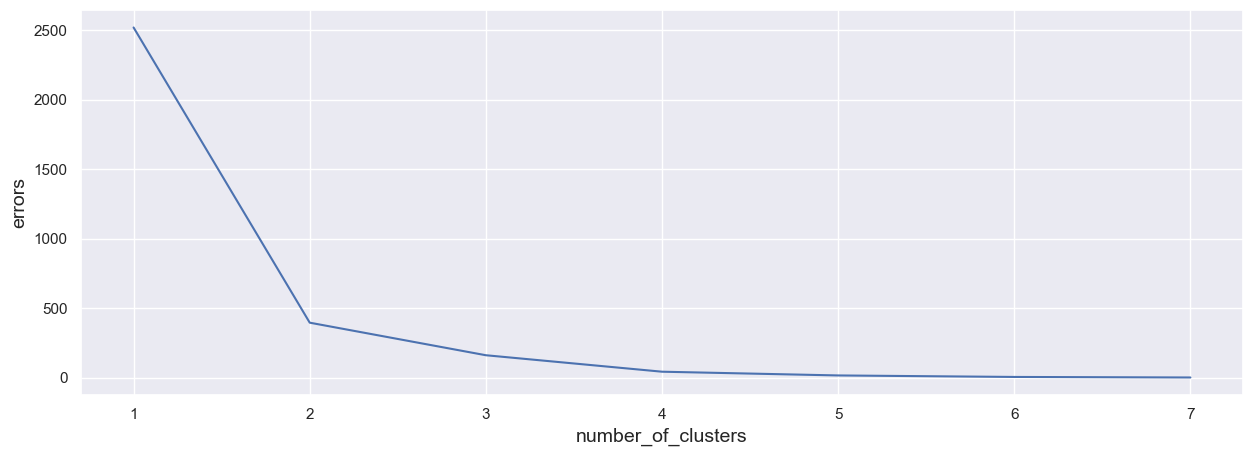

In [119]:
# оптимальное количество кластеров для метрики Frequency

optimal_cluster_number(pre_rfm.purchases_quantity)

Оптимальным количеством кластеров поставим 3 - после этой границы ошибки почти не падают.

На основе ранее созданной функции найдём интервалы разбивки на кластеры для колонки `purchases_quantity`.

In [189]:
# интервалы для Frequency

f_borders = get_borders(pre_rfm.purchases_quantity, 3)

# присвоим первому (нулевому) элементу значение 0, вместо 1, чтобы cut() мог обработать этот список

f_borders[0] = 0          
f_borders

[0, 1, 2, 11]

В данном случае наши выводы сходятся как руководствуясь методом k-средних, так и визуальной оценкой.

Передадим получившийся диапазон в функцию разбивки.

In [196]:
# назначаем рейтинг для Frequency

f_labels = (1, 2, 3)
f_score_bins = f_borders

f_score = (
    pd.cut(pre_rfm.purchases_quantity, 
                   bins=f_score_bins, 
                   labels = f_labels, 
                   right=True, 
                   include_lowest=True)
          )

### 7.6. Рассчет метрики Recency.

`Recency` определяет то количество времени, которое прошло с момента последнего взаимодействия пользователя с продуктом/сервисом/брендом, что включается в себя последнюю покупку или визит на сайт или использование приложения и тд. В нашем случае отражает, сколько дней назад пользователь совершил свою последнюю покупку. Является одной из ключевых метрик, так как покупатели, которые недавно провзаимодействовали с сервисом, горздо более расположены ответить и на новые маркетинговые кампании, что делает их максимально полезными для бизнеса.

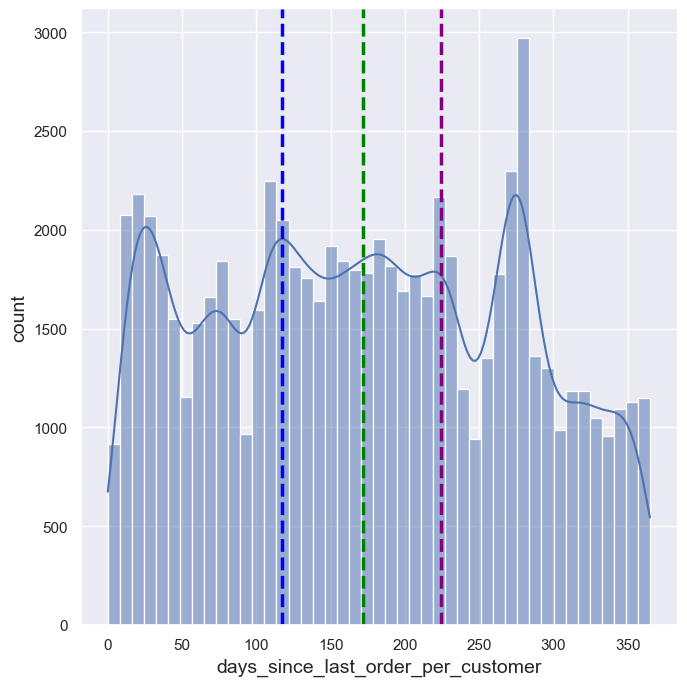

In [191]:
# распределение колонки давности последней покупки

sns.displot(pre_rfm.days_since_last_order, height=7, aspect=1, kde=True)
plt.xlabel("days_since_last_order_per_customer", size=14)
plt.ylabel("count", size=14)

plt.axvline(x=pre_rfm.days_since_last_order.median(),               # зелёная пунктирная линия - медиана
            color='green',
            ls='--', 
            lw=2.5)
plt.axvline(x=pre_rfm.days_since_last_order.quantile(q=0.33),       # синяя пунктирная линия - 33-й процентиль
            color='blue',
            ls='--', 
            lw=2.5)
plt.axvline(x=pre_rfm.days_since_last_order.quantile(q=0.66),       # фиолетовая пунктирная линия - 66-й процентиль
            color='purple',
            ls='--', 
            lw=2.5);

In [123]:
# 33-й и 66-й процентили количества дней от последней покупки

pre_rfm.days_since_last_order.quantile(q=[0.33, 0.66])

0.33    117.0
0.66    224.0
Name: days_since_last_order, dtype: float64

Анализ графиков показывает, что при таком распределении имеет смысл взять равные части по количеству пользователей, соответствующих 33-му и 66-му процентилю.

- `Группа 3` - от 0 до 117 дней (недавние),
- `Группа 2` - от 118 до 224 дней (относительно недавние),
- `Группа 1` - от 224 дней и более (давние).

Также воспользуемся кластеризацией методом k-средних для уточнения границ кластеров.
Находим оптимальное количество кластеров для количества дней с помощью k-means и метода локтя.

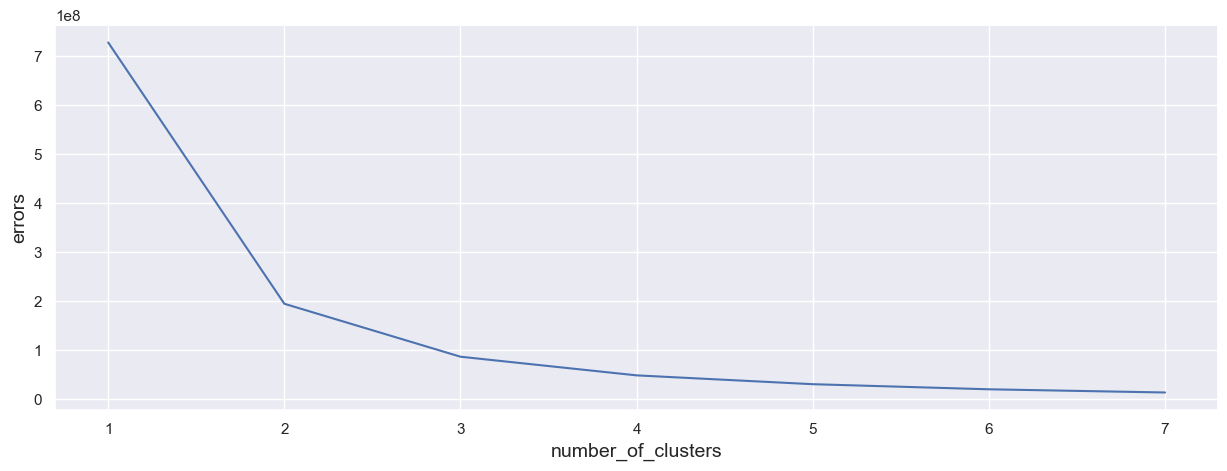

In [124]:
# оптимальное количество кластеров для Recency

optimal_cluster_number(pre_rfm.days_since_last_order)

Остановимся на 3 кластерах, характер падения ошибок похож на график для `frequency`.

На основе ранее созданной функции найдём интервалы разбивки на кластеры для колонки с количеством дней, прошедших с последней покупки.

In [192]:
# границы разбивки для Recency

r_borders = get_borders(pre_rfm.days_since_last_order, 3)
r_borders

[0, 120, 238, 365]

Наблюдаются небольшие расхождения между машинной кластеризацией и кластеризацией на основе анализа графика распределения, однако, ничего критичного не обнаружено.

In [197]:
# назначаем рейтинг для Recency

r_labels = (3, 2, 1)
r_score_bins = r_borders

r_score = (
    pd.cut(pre_rfm.days_since_last_order, 
                   bins=r_score_bins, 
                   labels = r_labels, 
                   right=True, 
                   include_lowest=True)
          )

### 7.7. Объединение и анализ результатов.

Итак, пришло время создать общий датафрейм, добавив в него рейтинги по метрикам, чтобы получить колонки с `recency`, `frequency` и `monetary`.

In [198]:
rfm_kmeans = (
    pre_rfm
        .copy()
        .drop('last_order', axis=1)
        .assign(recency   = r_score,
                frequency = f_score,
                monetary  = m_score)
)

In [199]:
rfm_kmeans.head()

customer  total_revenue  purchases_quantity  \
0  0000366f3b9a7992bf8c76cfdf3221e2         129.90                   1   
1  0000b849f77a49e4a4ce2b2a4ca5be3f          18.90                   1   
2  0000f6ccb0745a6a4b88665a16c9f078          25.99                   1   
3  0004aac84e0df4da2b147fca70cf8255         180.00                   1   
4  0004bd2a26a76fe21f786e4fbd80607f         154.00                   1   

   days_since_last_order recency frequency monetary  
0                    111       3         1        2  
1                    114       3         1        1  
2                    321       1         1        1  
3                    288       1         1        3  
4                    146       2         1        2

Визуализируем количество пользователей по кластерам по каждой метрике.

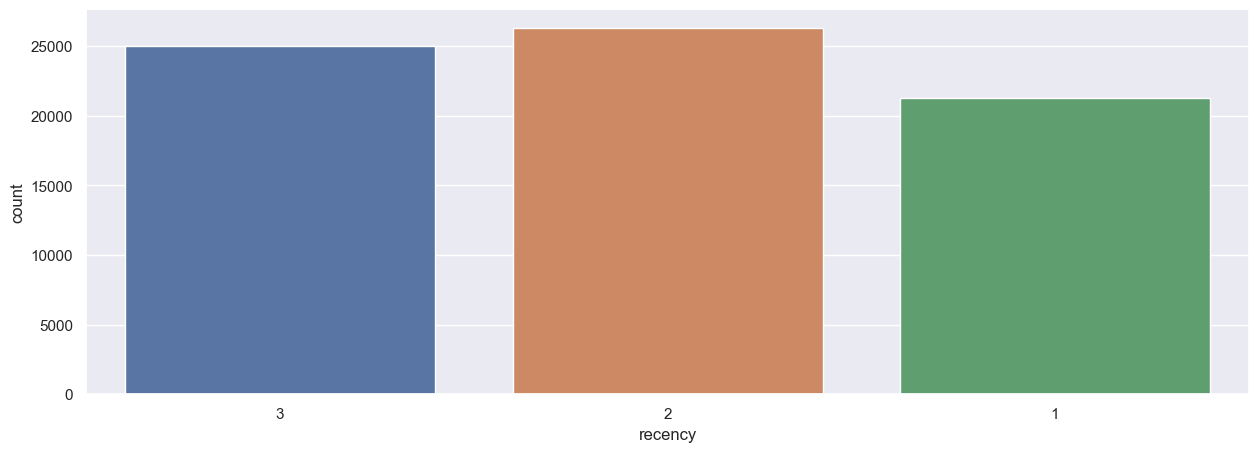

In [200]:
sns.countplot(data=rfm_kmeans, x='recency');

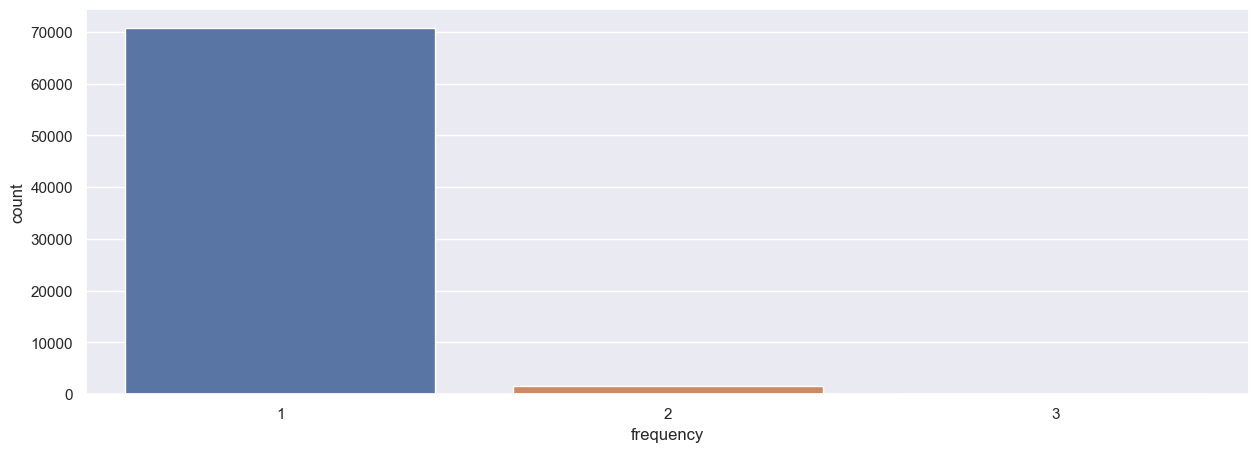

In [201]:
sns.countplot(data=rfm_kmeans, x='frequency');

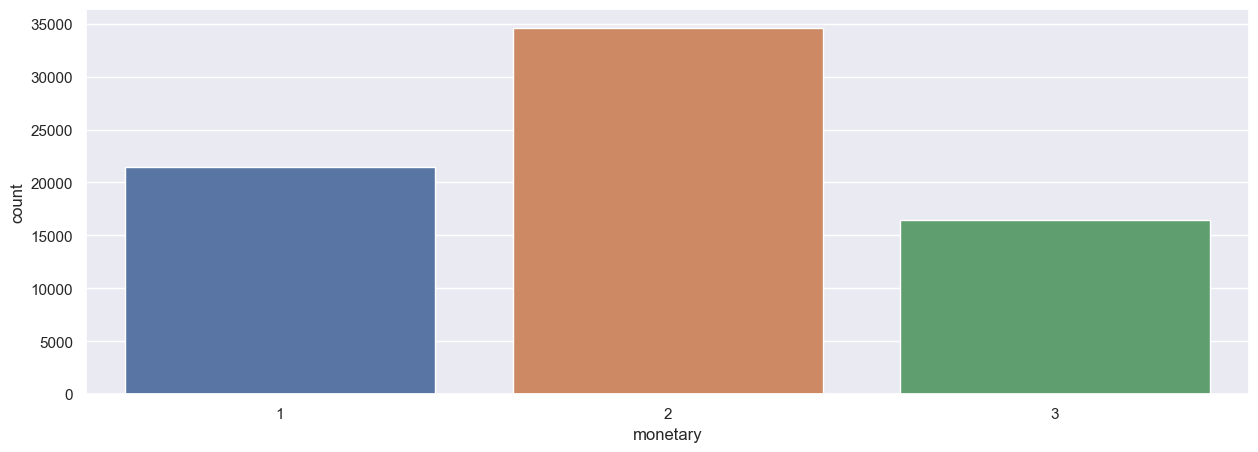

In [202]:
sns.countplot(data=rfm_kmeans, x='monetary');

**Вывод**

Пользователи не всегда равномерно распределены по кластерам:
    
- по метрике `Recency` преобладают пользователи из группы 2, т.е. относительно недавние со сроком последнего заказа от 118 до 224 дней, меньше всего давних пользователей из группы 1, которые сделали последний заказ от 224 дней и более;
- по метрике `Frequency` очень сильный перекос в сторону пользователей, совершивших только 1 заказ, остальные группы почти не представлены (как мы помним, это всего около 2,5% от всего количества пользователей);
- по метрике `Monetary` преобладает группа 2 с суммарной выручкой 52-165 (это почти половина всех пользователей), остальные сегменты мало отличаются.

Выведем средние значения метрик по кластерам и изобразим их в одной таблице.

In [132]:
# среднее Recency по кластерам для k-means

avg_recency_kmeans = (
    rfm_kmeans
        .pivot_table(index='recency', values='days_since_last_order')
        .reset_index()
        .rename(columns={'recency': 'cluster',
                        'days_since_last_order': 'recency'})
)

In [133]:
# среднее Frequency по кластерам для k-means

avg_frequency_kmeans = (
    rfm_kmeans
        .pivot_table(index='frequency', values='purchases_quantity')
        .reset_index()
        .rename(columns={'frequency': 'cluster',
                        'purchases_quantity': 'frequency'})
)

In [134]:
# среднее Monetary по кластерам для k-means

avg_monetary_kmeans = (
    rfm_kmeans
        .pivot_table(index='monetary', values='total_revenue')
        .reset_index()
        .rename(columns={'monetary': 'cluster',
                        'total_revenue': 'monetary'})
)

In [135]:
# сводная таблица средних значений recency, frequency и monetary по кластерам

avg_rfm_kmeans = (
    avg_recency_kmeans
        .merge(avg_frequency_kmeans, on='cluster')
        .merge(avg_monetary_kmeans, on='cluster')
        .sort_values('cluster')
        .reset_index(drop=True)
)

In [136]:
avg_rfm_kmeans

cluster     recency  frequency    monetary
0       1  296.586435   1.000000   32.434217
1       2  179.859509   2.000000   99.261150
2       3   60.969538   3.434426  371.149079

### 7.8. Использование RFMizer-скрипта для сегментации.

Чтобы понять объективность и адекватность выбранного пути, воспользуемся готовым решением, разработанным Александром Приходько (скрипт `RFMizer`) для RFM-анализа в качестве своеобразной проверки и сравним результаты.

In [138]:
#!pip install --user pyyaml future

Подготовим CSV-файл для rfm-анализа с помощью скрипта [RFMizer](https://github.com/Slony/rfmizer). Этот файл не лимитируем по времени, т.к. в конфигурационном файле есть возможность указать необходимый период. Плюс, данный скрипт дополнительно использует ещё один период "за границами" первого, чтобы выделить тех, кто покупал раньше, но перестал сейчас.

In [139]:
# датафрейм для RFM-анализа с помощью скрипта RFMizer

rfmizer_df = (
    rfm_merge
        .groupby('order_id')
        .agg({'order_purchase_timestamp': 'max', 'customer_unique_id': 'first', 'price': 'sum'})  
        .rename(columns={'order_purchase_timestamp': 'order_date',      # переименуем колонки как просит скрипт
                        'customer_unique_id': 'user_id',
                        'price': 'order_value'})
)

# переведём в формат дат, чтобы корректро записалось в CSV и считалось скриптом
rfmizer_df['order_date'] = rfmizer_df['order_date'].dt.date    
rfmizer_df.head()

order_date  \
order_id                                       
00010242fe8c5a6d1ba2dd792cb16214  2017-09-13   
00018f77f2f0320c557190d7a144bdd3  2017-04-26   
000229ec398224ef6ca0657da4fc703e  2018-01-14   
00024acbcdf0a6daa1e931b038114c75  2018-08-08   
00042b26cf59d7ce69dfabb4e55b4fd9  2017-02-04   

                                                           user_id  \
order_id                                                             
00010242fe8c5a6d1ba2dd792cb16214  871766c5855e863f6eccc05f988b23cb   
00018f77f2f0320c557190d7a144bdd3  eb28e67c4c0b83846050ddfb8a35d051   
000229ec398224ef6ca0657da4fc703e  3818d81c6709e39d06b2738a8d3a2474   
00024acbcdf0a6daa1e931b038114c75  af861d436cfc08b2c2ddefd0ba074622   
00042b26cf59d7ce69dfabb4e55b4fd9  64b576fb70d441e8f1b2d7d446e483c5   

                                  order_value  
order_id                                       
00010242fe8c5a6d1ba2dd792cb16214        58.90  
00018f77f2f0320c557190d7a144bdd3       239.90  
000229ec398224ef6ca0657da4fc703e       199.00  
00024acbcdf0a6daa1e931b038114c75        12.99  
00042b26cf59d7ce69dfabb4e55b4fd9       199.90

In [140]:
# сохраним в CSV-файл для передачи скрипту

rfmizer_df.to_csv('rfmizer_df.csv', encoding='utf-8', sep=',', index = False)

__*config.yaml*__ файл скрипта имеет следующую конфигурацию:
```
input_columns:  
  - order_date
  - user_id
  - order_value
segments_count:  
  recency: 3  
  frequency: 3  
  monetary: 3  
rfmizer:  
  look_back_period: 365 # earliest date for RFMizer (number of days)  
  output_columns:  
    user_id: user_id  
    recency: recency  
    frequency: frequency  
    monetary: monetary  
predictor:  
  prediction_period: 182 # lookback window for RFMestimator (number of days)
output_path: .
output_file_prefix: rfm-3-3-3-365-182
```

После обработки __*rfmizer_df.to_csv*__ скриптом откроем результирующие файлы.  

In [141]:
# файл с границами групп

borders = pd.read_csv('rfm-3-3-3-365-182_borders.csv')
borders

dimension  segment  border
0  frequency        1    2.00
1  frequency        2    3.00
2   monetary        1   57.95
3   monetary        2  125.02
4    recency        1 -225.00
5    recency        2 -116.00

Можно отметить следующее:

- `Recency` (давность последнего заказа) : в первом варианте - 117 и 224, в проверочном - 116 и 225;
- `Frequency` (частота покупок) : границы полностью совпадают с расчитанными ранее;
- `Monetary` (выручка) : в варианте, расчитанном с помощью k-means, границы были 52.0 и 165.48, в решении скрипта - 57.95 и 125.02, соответственно.
  
Таким образом, значения границ получились достаточно близкими.

Прочитаем файл результата RFM-анализа.

In [142]:
mapping = pd.read_csv('rfm-3-3-3-365-182_mapping.csv')
mapping.head()

user_id  frequency  monetary  recency
0  871766c5855e863f6eccc05f988b23cb          1         2        1
1  eb28e67c4c0b83846050ddfb8a35d051          1         1        1
2  3818d81c6709e39d06b2738a8d3a2474          1         3        1
3  af861d436cfc08b2c2ddefd0ba074622          1         1        3
4  64b576fb70d441e8f1b2d7d446e483c5          0         0        0

Нулевой кластер - это пользователи, у которых нет заказов за отчётный период, но есть более старые заказы.

Визуализируем количество пользователей по кластерам по каждой метрике.

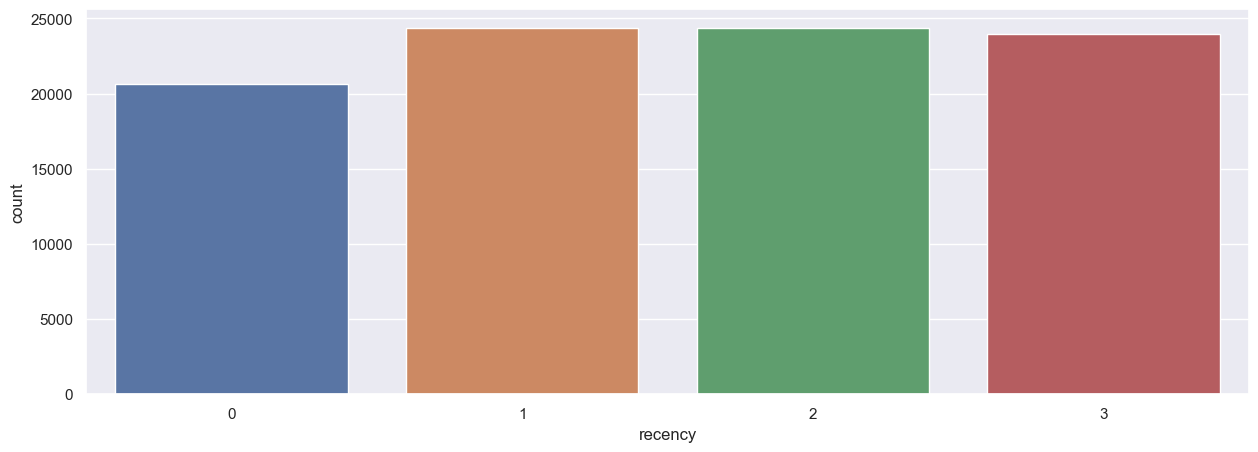

In [146]:
# визуализация Recency по кластерам

sns.countplot(data=mapping, x='recency');

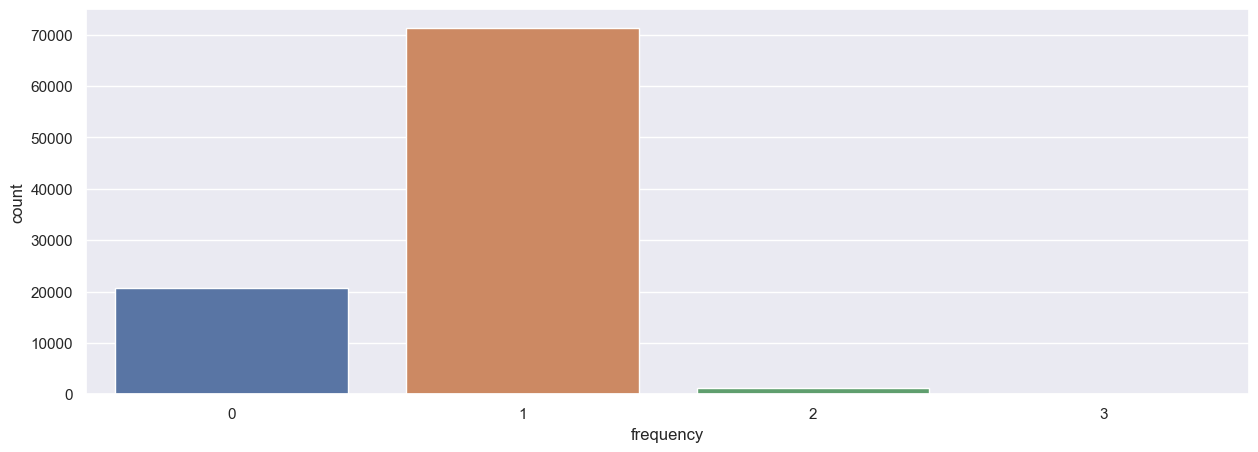

In [143]:
# визуализация Frequency по кластерам

sns.countplot(data=mapping, x='frequency');

In [144]:
mapping.frequency.value_counts()

1    71401
0    20667
2     1194
3       83
Name: frequency, dtype: int64

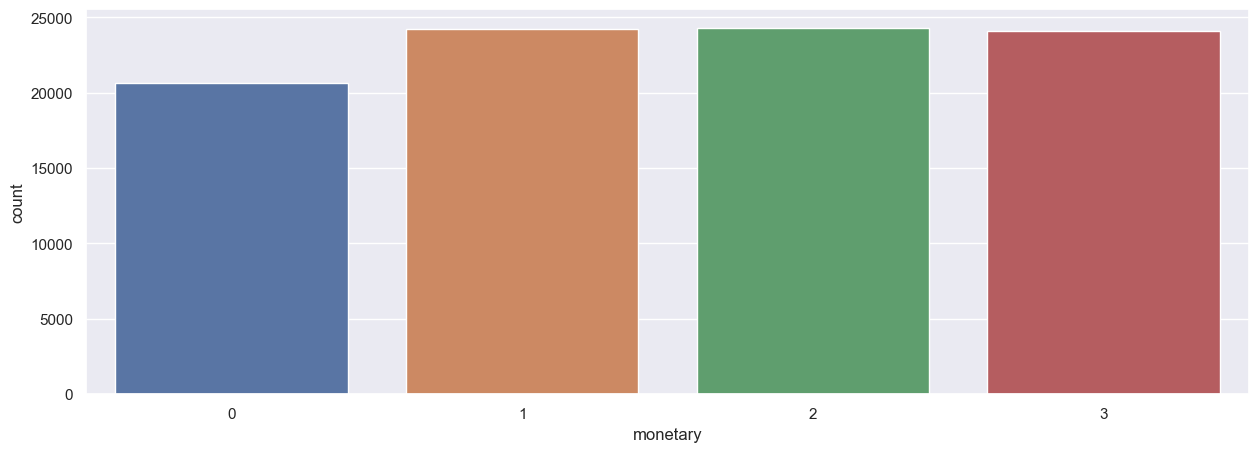

In [145]:
# визуализация Monetary по кластерам

sns.countplot(data=mapping, x='monetary');

**Вывод**

Пользователи не всегда равномерно распределены по кластерам:
    
- по метрике `Recency` распределение кластеров почти равномерное,
- по метрике `Frequency` очень сильный перекос в сторону пользователей, совершивших только 1 заказ;
- по метрике `Monetary` сегменты также выравниваются.

Объединим датафрэймы с кластерами (**mapping**) и с агрегированными данными по пользователям (**pre_rfm_all_years**).

In [147]:
# переименуем колонку с пользователями

mapping.rename(columns={'user_id': 'customer'}, inplace=True)

In [148]:
# объединяем датафреймы

rfm_rfmizer = pre_rfm_all_years.merge(mapping, on='customer')

In [149]:
# уберём колонку со временем последней покупки

rfm_rfmizer.drop('last_order', axis=1, inplace=True)

In [150]:
# финальный датафрейм

rfm_rfmizer.head()

customer  total_revenue  purchases_quantity  \
0  0000366f3b9a7992bf8c76cfdf3221e2         129.90                   1   
1  0000b849f77a49e4a4ce2b2a4ca5be3f          18.90                   1   
2  0000f46a3911fa3c0805444483337064          69.00                   1   
3  0000f6ccb0745a6a4b88665a16c9f078          25.99                   1   
4  0004aac84e0df4da2b147fca70cf8255         180.00                   1   

   days_since_last_order  frequency  monetary  recency  
0                    111          1         3        3  
1                    114          1         1        3  
2                    537          0         0        0  
3                    321          1         1        1  
4                    288          1         3        1

In [151]:
# среднее значение Recency по кластерам

avg_recency = (
    rfm_rfmizer
        .groupby('recency', as_index=False)
        .agg({'days_since_last_order': 'mean'})
        .rename(columns={'recency': 'cluster', 'days_since_last_order': 'recency'})
)

In [152]:
# среднее значение Frequency по кластерам

avg_frequency = (
    rfm_rfmizer
        .groupby('frequency', as_index=False)
        .agg({'purchases_quantity': 'mean'})
        .rename(columns={'frequency': 'cluster', 'purchases_quantity': 'frequency'})
)

In [153]:
# среднее значение Monetary по кластерам

avg_monetary= (
    rfm_rfmizer
        .groupby('monetary', as_index=False)
        .agg({'total_revenue': 'mean'})
        .rename(columns={'monetary': 'cluster', 'total_revenue': 'monetary'})
)

Покажем средние значения метрик по кластерам одной таблицей.

In [154]:
# объединяем три датафрейма в один

avg_rfm_rfmizer = avg_recency.merge(avg_frequency, on='cluster').merge(avg_monetary, on='cluster')
avg_rfm_rfmizer

cluster     recency  frequency    monetary
0        0  463.116659   1.025983  139.164275
1        1  288.735387   1.015042   36.260989
2        2  170.752634   2.063652   91.896198
3        3   58.397427   3.867470  299.961565

Сравним средние значения метрик для двух вариантов расчёта.

In [155]:
# объединим результаты расчётов с помощью скрипта и ручного для удобного сравнения

rfm_comparison_table = (
    avg_rfm_rfmizer
        .rename(columns={'recency' : 'R_rfmizer',
                        'frequency': 'F_rfmizer',
                        'monetary' : 'M_rfmizer'})
        .merge(avg_rfm_kmeans
                   .rename(columns={'recency'  : 'R_kmeans',
                                    'frequency': 'F_kmeans',
                                    'monetary' : 'M_kmeans'}),
                   on='cluster')

# найдём разницу между аналогичными метриками в процентах
    
        .assign(delta_R_perc = lambda x: x.R_rfmizer.sub(x.R_kmeans).mul(100).div(x.R_kmeans).round(2),
                delta_F_perc = lambda y: y.F_rfmizer.sub(y.F_kmeans).mul(100).div(y.F_kmeans).round(2),
                delta_M_perc = lambda z: z.M_rfmizer.sub(z.M_kmeans).mul(100).div(z.M_kmeans).round(2))
)

# установим порядок колонок

rfm_comparison_table =(
    rfm_comparison_table[['cluster', 'R_rfmizer', 'R_kmeans', 'delta_R_perc',
                       'F_rfmizer', 'F_kmeans', 'delta_F_perc',
                       'M_rfmizer', 'M_kmeans', 'delta_M_perc']]
)

rfm_comparison_table

cluster   R_rfmizer    R_kmeans  delta_R_perc  F_rfmizer  F_kmeans  \
0       1  288.735387  296.586435         -2.65   1.015042  1.000000   
1       2  170.752634  179.859509         -5.06   2.063652  2.000000   
2       3   58.397427   60.969538         -4.22   3.867470  3.434426   

   delta_F_perc   M_rfmizer    M_kmeans  delta_M_perc  
0          1.50   36.260989   32.434217         11.80  
1          3.18   91.896198   99.261150         -7.42  
2         12.61  299.961565  371.149079        -19.18

**Вывод**

Наиболее значительные отличия получились только при расчёте `Monetary`, что связано с большими отличиями в границах кластеров данной метрики при k-means кластеризации и расчёте с помощью скрипта. 

В целом можно сказать, что разработанный метод кластеризации методом k-средних даёт приемлемые результаты.

### 7.9. Расчет метрики RFM для каждого кластера.

In [156]:
avg_rfm_kmeans

cluster     recency  frequency    monetary
0       1  296.586435   1.000000   32.434217
1       2  179.859509   2.000000   99.261150
2       3   60.969538   3.434426  371.149079

In [157]:
# добавляем колонку RFM

rfm_kmeans['RFM'] = rfm_kmeans.apply(lambda x: str(x.recency) + str(x.frequency) + str(x.monetary), axis=1)

In [212]:
rfm_kmeans.head()

customer  total_revenue  purchases_quantity  \
0  0000366f3b9a7992bf8c76cfdf3221e2         129.90                   1   
1  0000b849f77a49e4a4ce2b2a4ca5be3f          18.90                   1   
2  0000f6ccb0745a6a4b88665a16c9f078          25.99                   1   
3  0004aac84e0df4da2b147fca70cf8255         180.00                   1   
4  0004bd2a26a76fe21f786e4fbd80607f         154.00                   1   

   days_since_last_order recency frequency monetary  
0                    111       3         1        2  
1                    114       3         1        1  
2                    321       1         1        1  
3                    288       1         1        3  
4                    146       2         1        2

Посмотрим на количество покупателей по результирующим сегментам.

In [159]:
# количество пользователей по каждому сегменту

customer_count = (
            rfm_kmeans
                .groupby('RFM', as_index=False)
                .agg({'customer': 'count'})
                .rename(columns={'customer': 'num_of_customers'})
)

Следующая таблица отражает сегменты и средние значения `recency`, `frequency` и `monetary` для них, а также количество пользователей по каждому сегменту.

In [160]:
rfm_mean = (
    
    rfm_kmeans
        .groupby('RFM', as_index=False)
        .agg({'days_since_last_order':      'mean',
             'purchases_quantity': 'mean',
             'total_revenue':           'mean'})
        
        # переименуем колонки
        .rename(columns={'days_since_last_order':      'recency_mean',
                        'purchases_quantity': 'frequency_mean',
                        'total_revenue':           'monetary_mean'})

        # добавим количество пользователей по сегментам
        .merge(customer_count, on='RFM')
)

In [206]:
rfm_mean

RFM  recency_mean  frequency_mean  monetary_mean  num_of_customers
0   111    295.544729        1.000000      32.726625              6137
1   112    296.727056        1.000000      97.393490             10079
2   113    297.854167        1.000000     372.740863              4656
3   121    298.705882        2.000000      42.150588                17
4   122    295.413793        2.000000     107.270115               174
5   123    292.688442        2.000000     396.226231               199
6   132    321.000000        3.000000     132.845000                 2
7   133    293.916667        3.250000     410.511667                12
8   211    181.327286        1.000000      32.241337              7938
9   212    179.337502        1.000000     100.052783             12154
10  213    178.970281        1.000000     358.967079              5552
11  221    174.406250        2.000000      38.524687                32
12  222    180.261224        2.000000     111.558041               245
13  223    180.494505        2.000000     353.954753               364
14  232    163.923077        3.000000     116.510000                13
15  233    169.612903        3.612903     419.863548                31
16  311     59.226449        1.000000      32.327824              7335
17  312     61.600239        1.000000      99.380875             11692
18  313     61.938105        1.000000     380.030178              5267
19  321     58.166667        2.000000      37.664000                30
20  322     61.860806        2.000000     110.454176               273
21  323     61.214689        2.000000     372.347062               354
22  332     41.625000        3.000000     105.438750                 8
23  333     64.875000        3.553571     590.937679                56

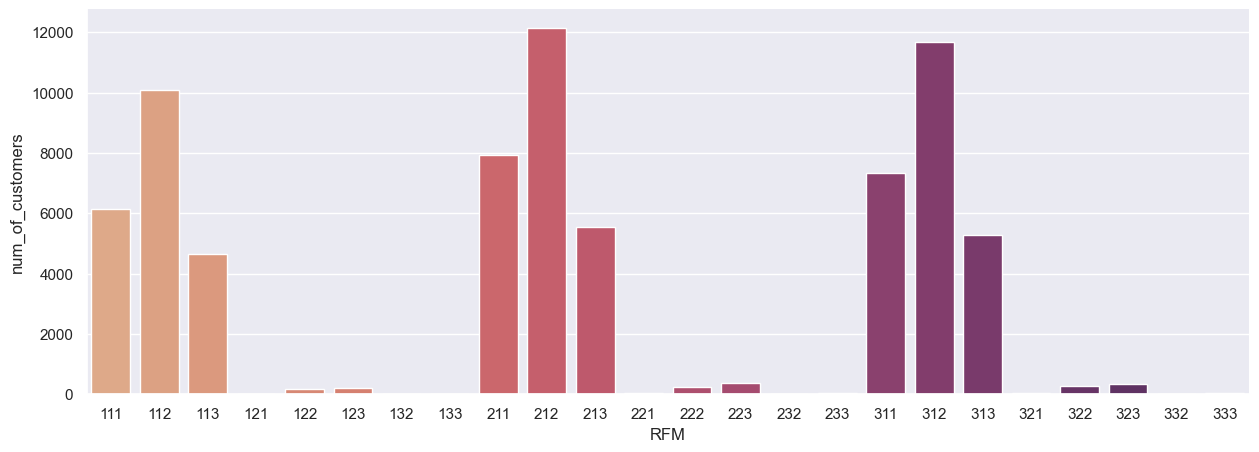

In [208]:
# выбираем палитру
sns.color_palette("flare", as_cmap=True)

sns.barplot(data=rfm_mean, x='RFM', y='num_of_customers', palette="flare")
sns.despine()

Визуализируем сегментацию пользователей по зависимости метрик `Recency` и `Frequency`, чтобы оценить их состояние лояльности и готовности к новым покупкам в ближайшее время.

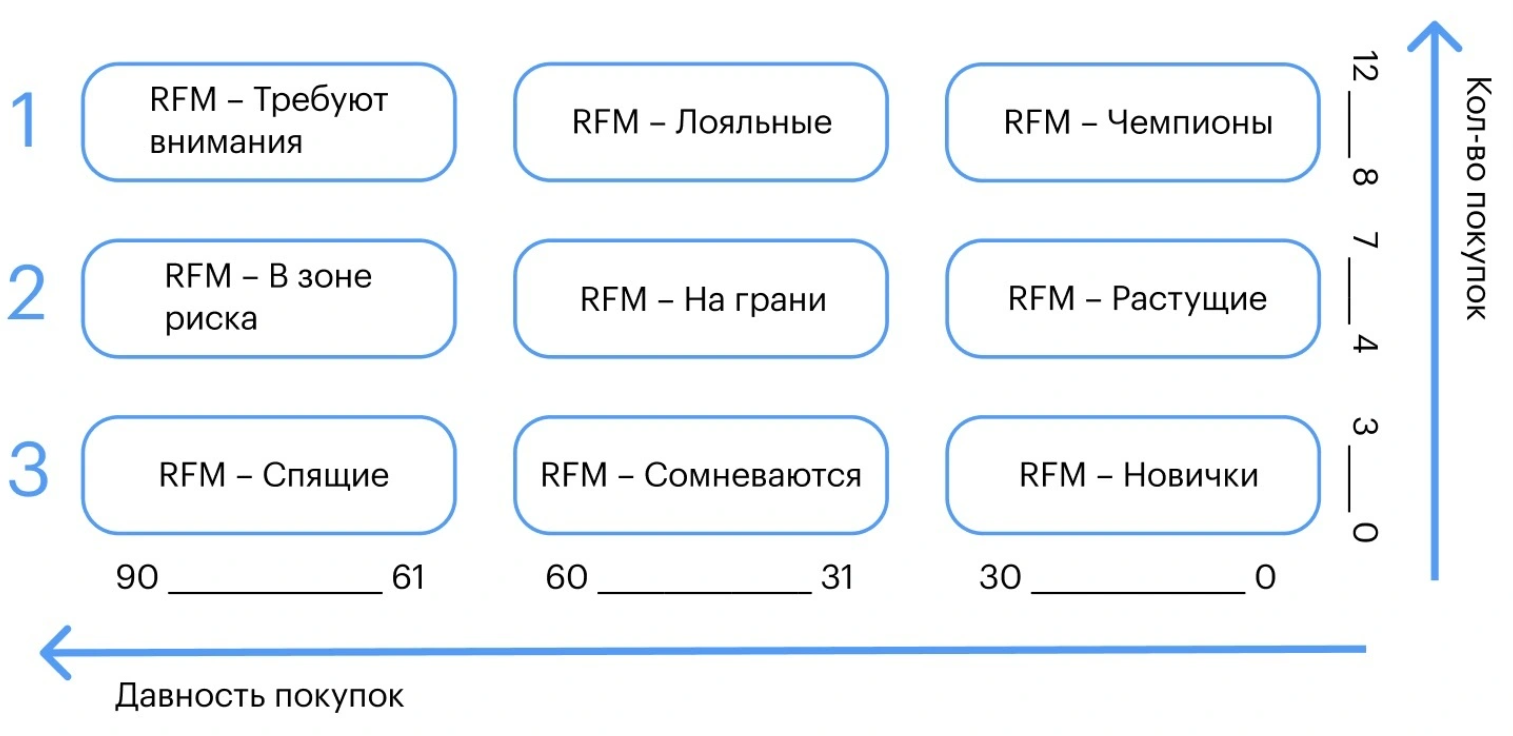

In [215]:
# зададим девять сегментов на основе метрик Recency и Frequency, привязывать метрику Monetary не будем

seg_map = {
    
    r'11': 'Спящие', 
    r'12': 'В зоне риска', 
    r'13': 'Требуют внимания', 
    r'21': 'Сомневаются',
    r'22': 'На грани',
    r'23': 'Лояльные', 
    r'31': 'Новички', 
    r'32': 'Растущие', 
    r'33': 'Чемпионы' 
}

In [216]:
# создаем колонку с названием сегмента для каждого уникального пользователя

rfm_kmeans['segment'] = rfm_kmeans['recency'].astype(str) + rfm_kmeans['frequency'].astype(str)
rfm_kmeans['segment'] = rfm_kmeans['segment'].replace(seg_map, regex=True)

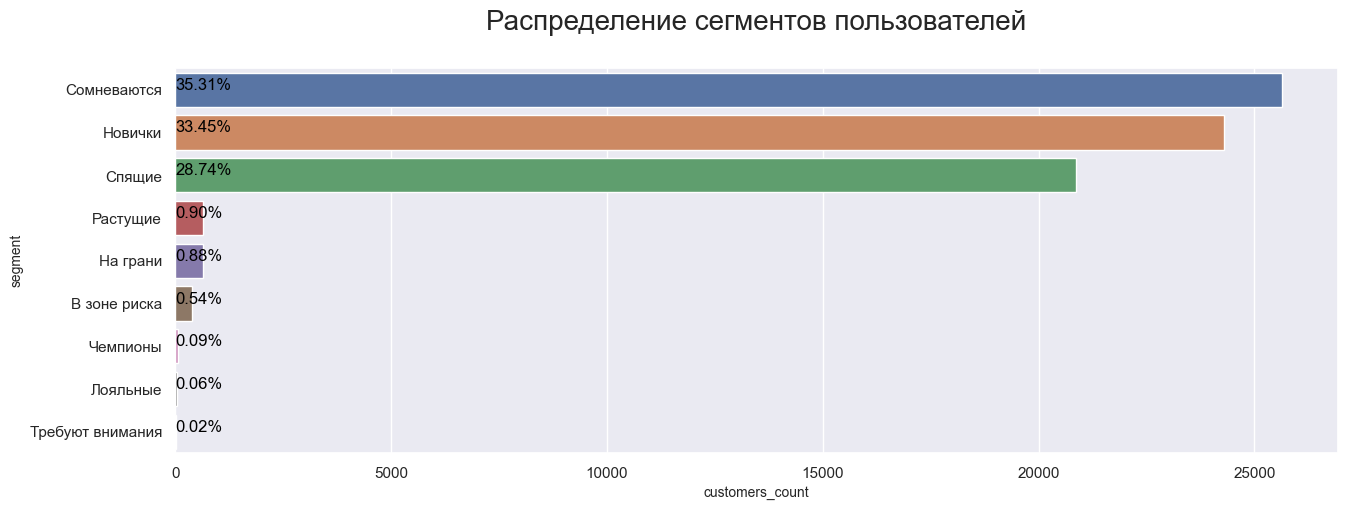

In [278]:
# визуализируем результат разбиения на сегменты и процента от всех пользователей

sns.barplot(x=rfm_kmeans.segment.value_counts().reset_index()['segment'], 
            y=rfm_kmeans.segment.value_counts().reset_index()['index'])

for i, val in enumerate(rfm_kmeans.segment.value_counts(normalize=True).values):
    plt.text(val, i, f'{val*100:.2f}%', color='black', ha="left")

plt.xlabel('customers_count', fontsize=10)
plt.ylabel('segment', fontsize=10)
plt.title('Распределение сегментов пользователей\n', fontsize=20);

**Вывод**

По результатам RFM-анализа за последний год были выявлены следующие закономерности:

- Большинство пользователей относится к типу "Сомневающиеся" (около 35%), то есть они сделали одну покупку около 6 месяцев назад и с тех пор не возвращались, однако, их еще возможно их реабилитировать. 

- На втором месте "Новички" (около 33% пользователей), то есть покупатели, сделавшие пока 1 покупку, но за последние 2-3 месяца, то есть представляют наиболее потенциально активную категорию.

- Третья по численности категория это "Спящие" (около 29%), то есть пользователи сделавшие всего 1 покупку более 10 месяцев назад, которые, скорее всего, полностью потеряны для нас.

- Далее идут почти одинаковые по численности группы "Растущие" и "На грани" (примерно по 0,9% каждая), которых объединяет то, что они сделали 2 покупки 3-6 месяцев назад, и определенно являются заинтересованными в нашем сервисе.

- Пользователи из категории "В зоне риска" (их всего 0.55%) отличаются давностью покупок более 10 месяцев, однако, они сделали более 1 покупки, возможно, правильно подобранная активность подстегнет их интерес.

- "Чемпионы" и "Лояльные", то есть те, кто делал 2-3 покупки за последние 2-3 месяца суммарно представляют всего 0.15% нашей пользовательской аудитории, и нашей целью, несомненно, является "толкать" все остальные сегменты в эту сторону, устраивая различные маркетинговые активности.

- "Требующие внимания" составляют всего 0.02%, они сделали более 2х покупок, но это было достаточно давно, следует напомнить им о себе и постараться возобновить интерес. 

Теперь эти данные можно передать отделу маркетинга для проработки CRM стратегий и рекламных кампаний для каждой категории, чтобы взаимодействовать с ней оптимальным и наиболее эффективным образом.

### 7.10. Альтернативный способ проведения анализа с разбиением на 5 сегментов.

Ранее проводя анализ мы руководствовались только исследованием данных за последний год и разбивали нашу аудиторию на 3 сегмента по каждой метрике.

Что если попробовать взять аудиторию за все время и провести анализ с разбиением на 5 сегментов по каждому скору? Главной проблемой является то, что в таком случае мы создаем 125 (5x5x5) пользовательских сегментов, что не позволяет эффективно извлекать закономерности и кластеризовать клиентов, мы не можем просто создать 125 персонализированных маркетинговых кампаний.

На помощь приходит такой метод оценки сегментов как [`bloomreach segmentation model`](https://documentation.bloomreach.com/engagement/docs/rfm-segmentation), который содержит 11 пользовательских сегментов, представленных на картинке ниже.

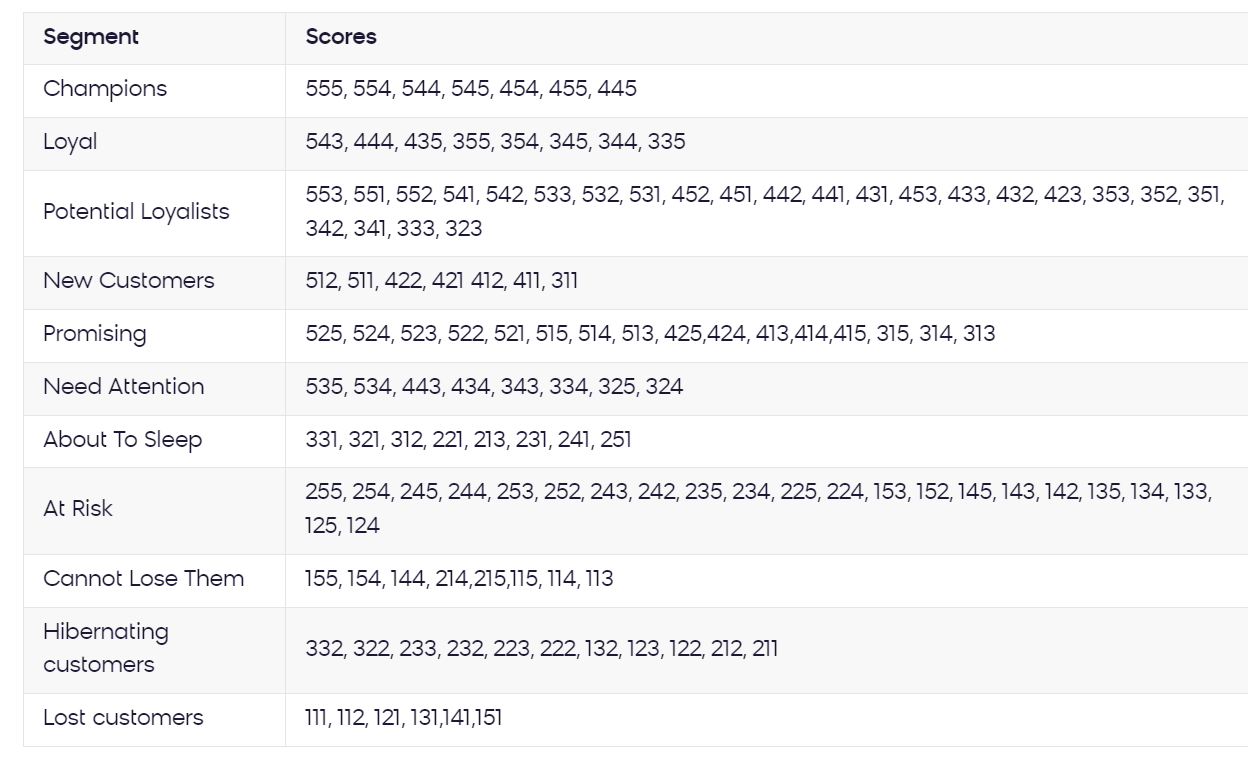

Попробуем обработать данные иначе и получить оценку аудитории по этой модели, возможно, это поможет получить новые инсайты.

Ранее мы уже создавали готовый датафрейм для анализа за весь период времени, поэтому теперь можем просто воспользоваться им.

In [226]:
pre_rfm_all_years 

customer  total_revenue  purchases_quantity  \
0      0000366f3b9a7992bf8c76cfdf3221e2         129.90                   1   
1      0000b849f77a49e4a4ce2b2a4ca5be3f          18.90                   1   
2      0000f46a3911fa3c0805444483337064          69.00                   1   
3      0000f6ccb0745a6a4b88665a16c9f078          25.99                   1   
4      0004aac84e0df4da2b147fca70cf8255         180.00                   1   
...                                 ...            ...                 ...   
93340  fffcf5a5ff07b0908bd4e2dbc735a684        1570.00                   1   
93341  fffea47cd6d3cc0a88bd621562a9d061          64.89                   1   
93342  ffff371b4d645b6ecea244b27531430a          89.90                   1   
93343  ffff5962728ec6157033ef9805bacc48         115.00                   1   
93344  ffffd2657e2aad2907e67c3e9daecbeb          56.99                   1   

               last_order  days_since_last_order  
0     2018-05-10 10:56:27                    111  
1     2018-05-07 11:11:27                    114  
2     2017-03-10 21:05:03                    537  
3     2017-10-12 20:29:41                    321  
4     2017-11-14 19:45:42                    288  
...                   ...                    ...  
93340 2017-06-08 21:00:36                    447  
93341 2017-12-10 20:07:56                    262  
93342 2017-02-07 15:49:16                    568  
93343 2018-05-02 15:17:41                    119  
93344 2017-05-02 20:18:45                    484  

[93345 rows x 5 columns]

Как мы помним, большую сложность для оценки границ сегментов для нас представляли выбросы в колонках с количеством покупок и суммарной выручкой. Посмотрим сохраняется ли такая проблема и на датасете за все время наблюдений.

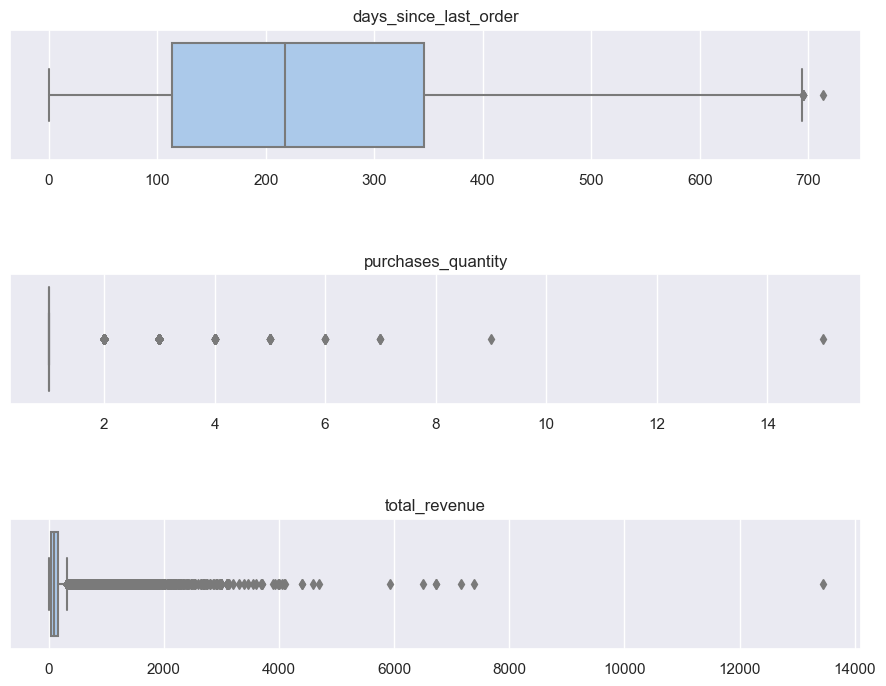

In [234]:
features = ['days_since_last_order', 'purchases_quantity', 'total_revenue']

plt.figure(figsize = (10, 8))

for n, feature in enumerate(features, 1):
    
    plt.subplot(3, 1, n)
    sns.boxplot(x=pre_rfm_all_years[feature], palette = 'pastel').set(xlabel = None)
    plt.title(f'{feature}')
    
plt.tight_layout(pad = 4)

Да, как и в прошлый раз мы видим большое количество выбросов в этих колонках. и теперь можем попробовать избавиться от них и посмотреть на результат.

Для того чтобы удалить выбросы применим классический подход отсечения всех данных, которые не входят в полуторный межквартильный размх с каждой стороны. Оценим количество выбросов.

In [236]:
def num_outlier(df_in, col_name):
    '''функция принимаем датафрейм и названия колонок и возвращает количество выбросов в них'''
    
    q1 = df_in[col_name].quantile(0.05)
    q3 = df_in[col_name].quantile(0.95)
    
    iqr = q3 - q1 # межквартильный размах
    
    fence_low  = q1 - 1.5*iqr
    fence_high = q3 + 1.5*iqr
    
    df_out = df_in.loc[(df_in[col_name] < fence_low) | (df_in[col_name] > fence_high)]  
    return print(" Количество выбросов в колонке {}: ".format(col_name), len(df_out))

In [238]:
for column in features:
    num_outlier(pre_rfm_all_years, column)

 Количество выбросов в колонке days_since_last_order:  0
 Количество выбросов в колонке purchases_quantity:  2800
 Количество выбросов в колонке total_revenue:  912


Применим функцию удаления выбросов, но только из колонок с количество дней с последней покупки и суммарной суммы покупок.

In [239]:
def remove_outlier(df_in, col_name):
    '''функция принимаем датафрейм и названия колонок и удаляет из них выбросы по значениям квартилей'''
    
    q1 = df_in[col_name].quantile(0.05)
    q3 = df_in[col_name].quantile(0.95)
    
    iqr = q3 - q1     
    fence_low  = q1 - 1.5*iqr
    fence_high = q3 + 1.5*iqr
    
    index_outliers= df_in.loc[(df_in[col_name] < fence_low) | (df_in[col_name] > fence_high)].index
    df_out = pd.DataFrame(df_in.drop(index_outliers.to_list(), axis=0, inplace=True))
    
    print("Выбросы в колонке {} были удалены".format(col_name))
    return df_out

In [240]:
for column in ['days_since_last_order', 'total_revenue']:
    remove_outlier(pre_rfm_all_years, column)

Выбросы в колонке days_since_last_order были удалены
Выбросы в колонке total_revenue были удалены


Теперь мы готовы поделить все значения по 5 категориям. Для этого применим функцию квантильной дискретизации `pd.qcut`, которая делит значения по границам квантилей, что в нашем случае очень удобно и позволяет исключить их визуальный осмотр и подбор границ сегментов.

In [171]:
#other_rfm = other_rfm.set_index('customer')

In [242]:
# сохраним копию датафрейма

rfm_all_years = pre_rfm_all_years.copy()

In [ ]:
rfm_all_years["recency_score"] = pd.qcut(rfm_all_years['days_since_last_order'], 5, labels=[5, 4, 3, 2, 1])
rfm_all_years["monetary_score"] = pd.qcut(rfm_all_years['total_revenue'], 5, labels=[1, 2, 3, 4, 5])

Как было замечено ранее, значения в колонке с количеством покупок сильно сконцентрированы около значения 1. Это означает, что если без предобработки поделить ее на равные категории, то окажется так, что покупатели с единичным значение числа покупок попадут в разные категории.

In [245]:
rfm_all_years['purchases_quantity'].value_counts(normalize=True)*100

1     97.036773
2      2.731708
3      0.186081
4      0.025965
5      0.008655
6      0.005409
7      0.003246
9      0.001082
15     0.001082
Name: purchases_quantity, dtype: float64

Предобработаем эту колонку, чтобы деление прошло оптимально.

In [246]:
def parse_values(x):
    switch = {
        1: 1,
        2: 2,
        3: 3,
        4: 4
    }
    return switch.get(x, 5)

In [247]:
# применим функцию к колонке

rfm_all_years['frequency_score'] = rfm_all_years['purchases_quantity'].apply(parse_values)

Кластеры можно попробовать визуализировать данные, разбитые на 5 кластеров по каждой метрике, с помощью алгоритма k-means и scatterplot.

In [417]:
def cluster_individual(data, column, invert=False):
    '''функция принимает датафрейм и колонку
       возвращает график scatterplot со значениями колонки, кластеризованными по методу k-means на 5 кластеров
    '''
    
    #--------> Sort Clusters by yasirroni
    #--------> https://github.com/yasirroni/sorted_cluster
    #--------> Copyright (c) 2020 Muhammad Yasirroni

    data = data
    columnName = str(column)
    className = "class_" + columnName
    X = data[column]
    X = pd.DataFrame(X)

    #определяем модель k-means, используя правило локтя
    kmeans_kwargs = {
        "n_clusters": 5,
        "init": "random",
        "n_init": 10,
        "max_iter": 300,
        "random_state": 1,
    }

    # сортируем кластеры
    def sorted_cluster(x, model=None):
        if model == None:
            model = KMeans()
        model = sorted_cluster_centers_(model, x)
        model = sorted_labels_(model, x)
        return model

    def sorted_cluster_centers_(model, x):
        model.fit(x)
        new_centroids = []
        magnitude = []
        for center in model.cluster_centers_:
            magnitude.append(np.sqrt(center.dot(center)))
        idx_argsort = np.argsort(magnitude)
        model.cluster_centers_ = model.cluster_centers_[idx_argsort]
        return model

    def sorted_labels_(sorted_model, x):
        sorted_model.labels_ = sorted_model.predict(x)
        return sorted_model

    # финальная модель
    km = KMeans(**kmeans_kwargs).fit(X)

    # приваиваем кластеры к каждой колонке
    cluster = sorted_cluster(X, km)
    X[className] = cluster.predict(X)

    # визуализируем результаты кластеризации используя модель
    plt.figure(figsize=(15, 3))
    plt.title('Results of clustering')

    sns.scatterplot(x=X[columnName], y=X.index, hue=X[className], s=20, linewidth=0.1)
    
    # соединяем кластеризацию с изначальным датасетом
    data[className] = X[className] + 1

    if invert:
        data[className] = data[className].map({5:1,
                                            4:2,
                                            3:3,
                                            2:4,
                                            1:5})

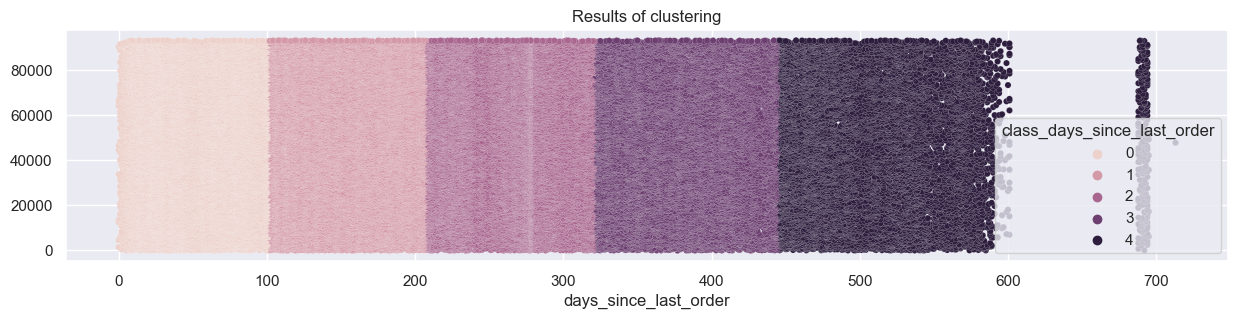

In [418]:
cluster_individual(pre_rfm_all_years, 'days_since_last_order')

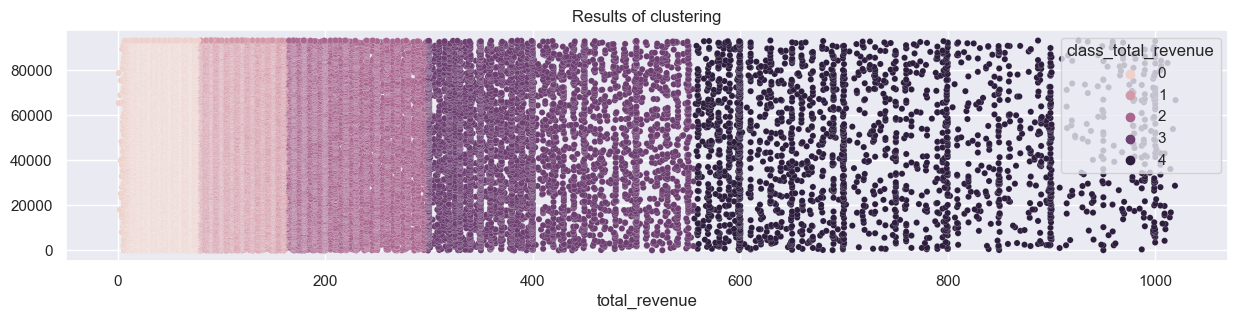

In [419]:
cluster_individual(pre_rfm_all_years, 'total_revenue')

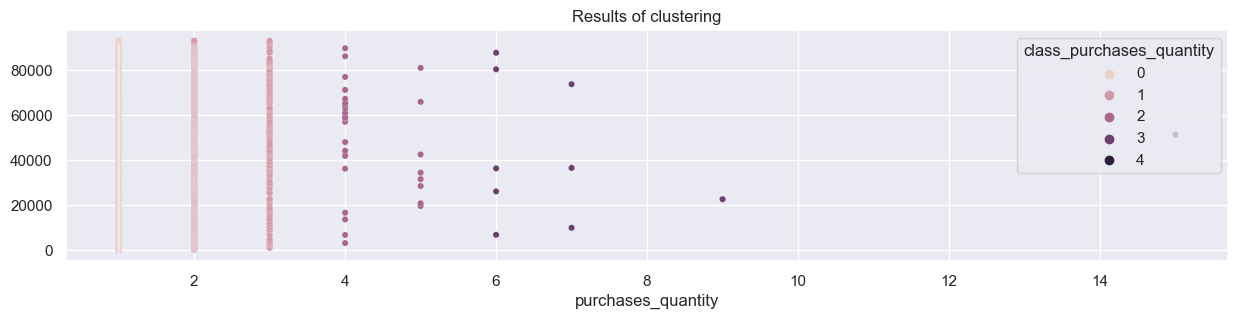

In [420]:
cluster_individual(pre_rfm_all_years, 'purchases_quantity', invert=True)

Теперь у нас есть скор по каждому парамету и мы можем объединить их в 3x-значный идентификатор сегмента пользователя.

In [249]:
rfm_all_years['RFM'] = rfm_all_years.recency_score.astype(str) + rfm_all_years.frequency_score.astype(str) + rfm_all_years.monetary_score.astype(str)
rfm_all_years.head()

customer  total_revenue  purchases_quantity  \
0  0000366f3b9a7992bf8c76cfdf3221e2         129.90                   1   
1  0000b849f77a49e4a4ce2b2a4ca5be3f          18.90                   1   
2  0000f46a3911fa3c0805444483337064          69.00                   1   
3  0000f6ccb0745a6a4b88665a16c9f078          25.99                   1   
4  0004aac84e0df4da2b147fca70cf8255         180.00                   1   

           last_order  days_since_last_order recency_score monetary_score  \
0 2018-05-10 10:56:27                    111             4              4   
1 2018-05-07 11:11:27                    114             4              1   
2 2017-03-10 21:05:03                    537             1              2   
3 2017-10-12 20:29:41                    321             2              1   
4 2017-11-14 19:45:42                    288             2              5   

   frequency_score  RFM  
0                1  414  
1                1  411  
2                1  112  
3                1  211  
4                1  215

Примени к данным словарь с описаниями категорий пользователей.

In [250]:
# создаем словарь с описанием скоров и названий сегментов

segments = {
    
    r'111|112|121|131|141|151': 'Lost customers',
    r'332|322|233|232|223|222|132|123|122|212|211': 'Hibernating customers', 
    r'155|154|144|214|215|115|114|113': 'Cannot Lose Them',
    r'255|254|245|244|253|252|243|242|235|234|225|224|153|152|145|143|142|135|134|133|125|124': 'At Risk',
    r'331|321|312|221|213|231|241|251': 'About To Sleep',
    r'535|534|443|434|343|334|325|324': 'Need Attention',
    r'525|524|523|522|521|515|514|513|425|424|413|414|415|315|314|313': 'Promising',
    r'512|511|422|421|412|411|311': 'New Customers',
    r'553|551|552|541|542|533|532|531|452|451|442|441|431|453|433|432|423|353|352|351|342|341|333|323': 'Potential Loyalist',
    r'543|444|435|355|354|345|344|335': 'Loyal',
    r'555|554|544|545|454|455|445': 'Champions'

}

In [251]:
# применим его к датафрейму и поместим названия в отдельную колонку segment

rfm_all_years['segment'] = rfm_all_years['recency_score'].astype(str) + rfm_all_years['frequency_score'].astype(str) + rfm_all_years['monetary_score'].astype(str)
rfm_all_years['segment'] = rfm_all_years['segment'].replace(segments, regex=True)
rfm_all_years.head()

customer  total_revenue  purchases_quantity  \
0  0000366f3b9a7992bf8c76cfdf3221e2         129.90                   1   
1  0000b849f77a49e4a4ce2b2a4ca5be3f          18.90                   1   
2  0000f46a3911fa3c0805444483337064          69.00                   1   
3  0000f6ccb0745a6a4b88665a16c9f078          25.99                   1   
4  0004aac84e0df4da2b147fca70cf8255         180.00                   1   

           last_order  days_since_last_order recency_score monetary_score  \
0 2018-05-10 10:56:27                    111             4              4   
1 2018-05-07 11:11:27                    114             4              1   
2 2017-03-10 21:05:03                    537             1              2   
3 2017-10-12 20:29:41                    321             2              1   
4 2017-11-14 19:45:42                    288             2              5   

   frequency_score  RFM                segment  
0                1  414              Promising  
1                1  411          New Customers  
2                1  112         Lost customers  
3                1  211  Hibernating customers  
4                1  215       Cannot Lose Them

In [253]:
# проверим какие уникальные названия содержатся в сегментах

rfm_all_years['segment'].unique()

array(['Promising', 'New Customers', 'Lost customers',
       'Hibernating customers', 'Cannot Lose Them', 'About To Sleep',
       'Need Attention', 'At Risk', 'Loyal', 'Potential Loyalist',
       'Champions'], dtype=object)

Теперь, когда мы знаем, в какому сегменту принадлежит каждый из пользователей, мы можем более глубоко проанализировать паттерны их поведения. Для этого полезно будет также получить и полную статистику в разрезе каждого сегмента.

In [255]:
rfm_stats = rfm_all_years[['segment', 'days_since_last_order', 'purchases_quantity', 'total_revenue']] \
                         .groupby('segment').agg(['mean','median', 'min', 'max', 'count'])
rfm_stats

days_since_last_order                          \
                                       mean median  min  max  count   
segment                                                               
About To Sleep                   269.787953  271.0  178  382   6956   
At Risk                          382.176387  367.0  269  691    703   
Cannot Lose Them                 410.896184  408.0  269  713  17088   
Champions                         91.034483   89.0    6  177     29   
Hibernating customers            317.924031  313.0  179  592   7661   
Lost customers                   473.251203  466.0  383  695   7687   
Loyal                            171.175439  165.0   94  268     57   
Need Attention                   204.300813  210.0    1  268    492   
New Customers                    117.099924  115.0    0  268  18484   
Potential Loyalist               170.967949  174.0    2  268    156   
Promising                        132.932065  132.0    0  268  33120   

                      purchases_quantity                       total_revenue  \
                                    mean median min max  count          mean   
segment                                                                        
About To Sleep                  1.002444    1.0   1   2   6956     70.744034   
At Risk                         2.093883    2.0   2   6    703    271.578748   
Cannot Lose Them                1.000000    1.0   1   1  17088    205.745859   
Champions                       5.034483    4.0   4  15     29    518.324138   
Hibernating customers           1.036027    1.0   1   3   7661     41.562245   
Lost customers                  1.002992    1.0   1   4   7687     39.274898   
Loyal                           3.298246    3.0   3   9     57    432.804561   
Need Attention                  2.101626    2.0   2   3    492    268.123313   
New Customers                   1.002976    1.0   1   2  18484     36.328336   
Potential Loyalist              2.070513    2.0   2   3    156     89.193013   
Promising                       1.028412    1.0   1   2  33120    182.668282   

                                                       
                       median     min      max  count  
segment                                                
About To Sleep          69.90   11.98   109.03   6956  
At Risk                219.10   58.40   979.89    703  
Cannot Lose Them       149.99   69.36  1014.60  17088  
Champions              494.48  200.28   994.80     29  
Hibernating customers   41.40    2.29   108.97   7661  
Lost customers          39.80    3.90    69.00   7687  
Loyal                  374.15  179.07  1000.85     57  
Need Attention         220.00  109.63   965.80    492  
New Customers           34.90    0.85    69.00  18484  
Potential Loyalist      89.37   62.98   108.99    156  
Promising              135.00   20.00  1019.49  33120

Теперь мы имеем возможность детально рассмотреть все статистики пользователей. 

Для удобства вычислим процент пользователей каждого сегмента к общему числу пользователей и визуализируем группы с помощью графика. 

In [256]:
rfm_stats['ratio'] = (100* rfm_stats['total_revenue']["count"] / rfm_stats['total_revenue']["count"].sum()).round(2)
rfm_stats

days_since_last_order                          \
                                       mean median  min  max  count   
segment                                                               
About To Sleep                   269.787953  271.0  178  382   6956   
At Risk                          382.176387  367.0  269  691    703   
Cannot Lose Them                 410.896184  408.0  269  713  17088   
Champions                         91.034483   89.0    6  177     29   
Hibernating customers            317.924031  313.0  179  592   7661   
Lost customers                   473.251203  466.0  383  695   7687   
Loyal                            171.175439  165.0   94  268     57   
Need Attention                   204.300813  210.0    1  268    492   
New Customers                    117.099924  115.0    0  268  18484   
Potential Loyalist               170.967949  174.0    2  268    156   
Promising                        132.932065  132.0    0  268  33120   

                      purchases_quantity                       total_revenue  \
                                    mean median min max  count          mean   
segment                                                                        
About To Sleep                  1.002444    1.0   1   2   6956     70.744034   
At Risk                         2.093883    2.0   2   6    703    271.578748   
Cannot Lose Them                1.000000    1.0   1   1  17088    205.745859   
Champions                       5.034483    4.0   4  15     29    518.324138   
Hibernating customers           1.036027    1.0   1   3   7661     41.562245   
Lost customers                  1.002992    1.0   1   4   7687     39.274898   
Loyal                           3.298246    3.0   3   9     57    432.804561   
Need Attention                  2.101626    2.0   2   3    492    268.123313   
New Customers                   1.002976    1.0   1   2  18484     36.328336   
Potential Loyalist              2.070513    2.0   2   3    156     89.193013   
Promising                       1.028412    1.0   1   2  33120    182.668282   

                                                       ratio  
                       median     min      max  count         
segment                                                       
About To Sleep          69.90   11.98   109.03   6956   7.53  
At Risk                219.10   58.40   979.89    703   0.76  
Cannot Lose Them       149.99   69.36  1014.60  17088  18.49  
Champions              494.48  200.28   994.80     29   0.03  
Hibernating customers   41.40    2.29   108.97   7661   8.29  
Lost customers          39.80    3.90    69.00   7687   8.32  
Loyal                  374.15  179.07  1000.85     57   0.06  
Need Attention         220.00  109.63   965.80    492   0.53  
New Customers           34.90    0.85    69.00  18484  20.00  
Potential Loyalist      89.37   62.98   108.99    156   0.17  
Promising              135.00   20.00  1019.49  33120  35.83

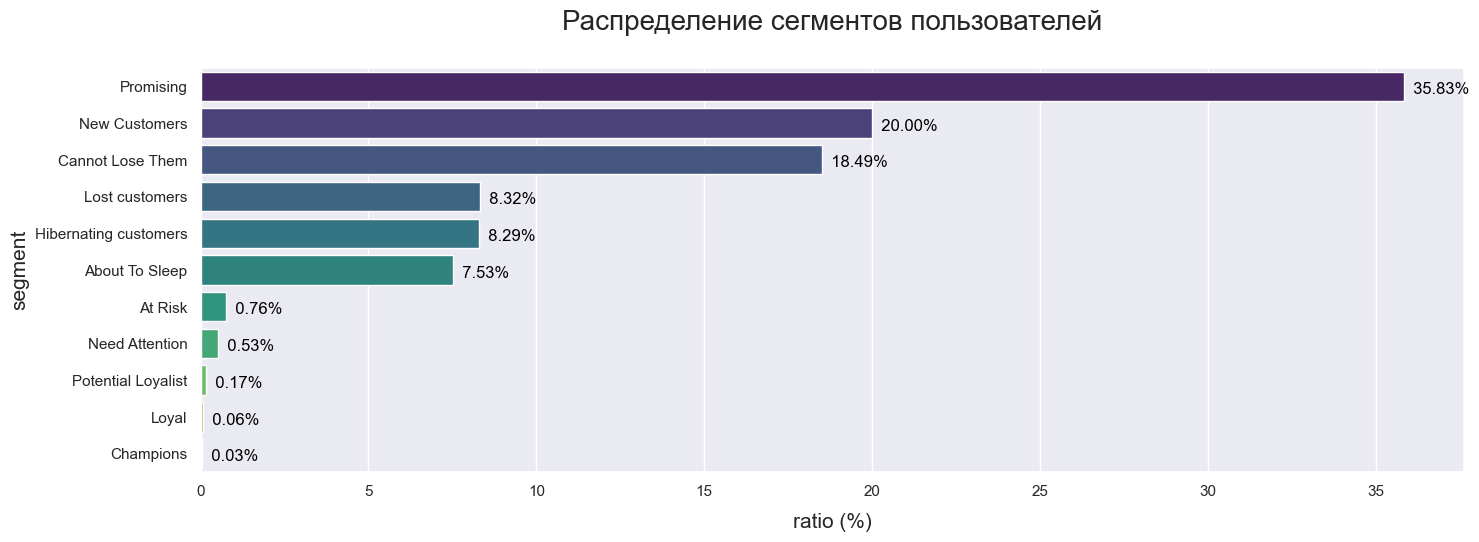

In [273]:
# визуализируем результат разбиения на сегменты и процента от всех пользователей

rfm_stats_sorted = rfm_stats.sort_values(by='ratio', ascending=False)

sns.barplot(x='ratio', 
            y=rfm_stats_sorted.index, 
            data = rfm_stats_sorted,
            palette="viridis")

for i, v in enumerate(rfm_stats_sorted['ratio']): 
    plt.text(v, i+.20,"  {:.2f}".format(v)+"%", color='black', ha="left")
  
plt.xlabel('ratio (%)', fontsize=15, labelpad = 10)
plt.ylabel('segment', fontsize=15)
plt.tight_layout()
plt.title('Распределение сегментов пользователей\n', fontsize=20);

Можно изобрзить сегменты и с помощью графика типа `mosaic`.

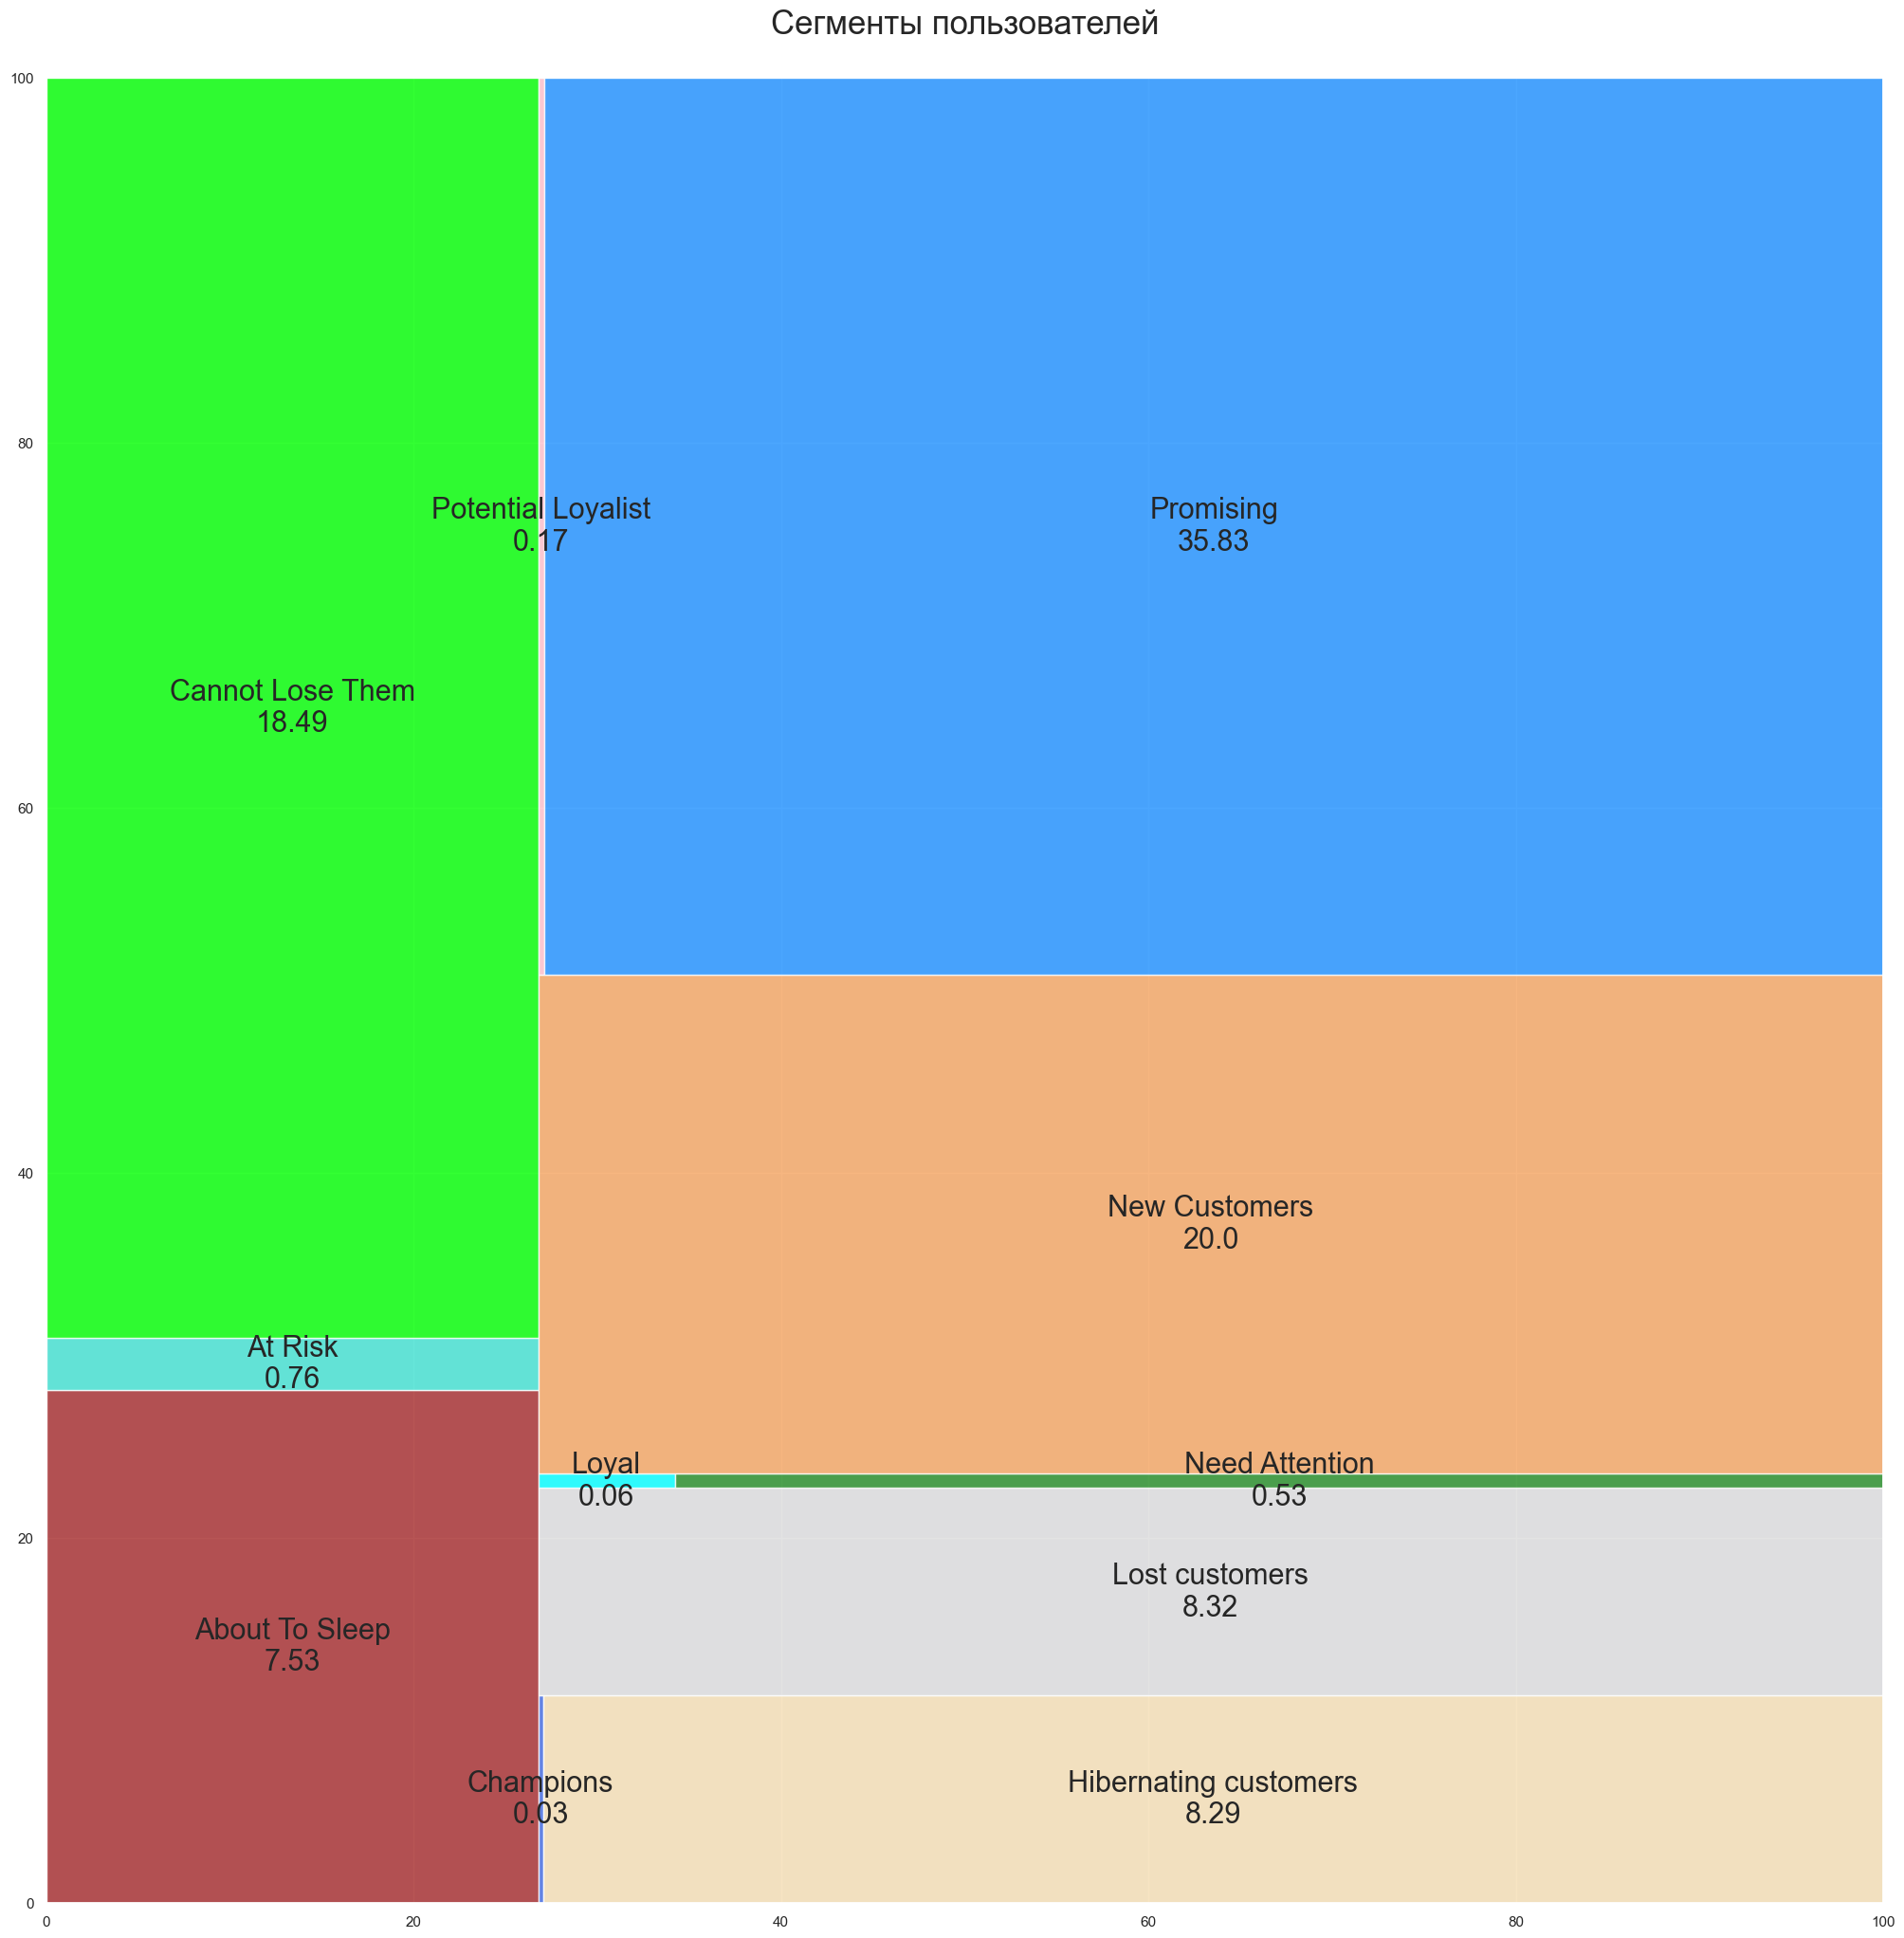

In [421]:
# задаем цвета
colors = ['brown','turquoise','lime','royalblue','wheat','gainsboro','aqua','forestgreen','sandybrown','pink','dodgerblue']

plotSeg = (100* rfm_stats['days_since_last_order']["count"] / rfm_stats['days_since_last_order']["count"]\
           .sum()).round(2)#.sort_values(ascending=False)
#plotSeg = rfm_stats['days_since_last_order']['count'].sort_values(ascending=False) 
plotSegIndex = plotSeg.reset_index()

# создаем список лейблов для сегментов
lbl = [plotSegIndex['segment'][i] + "\n" + str(plotSeg[i]) for i in range(len(plotSeg))]

# определяем размеры графика
fig, ax = plt.subplots(1, figsize = (25, 25))
plt.rc('font', size=22) 
plt.title('Сегменты пользователей\n', fontsize=25)

squarify.plot(sizes= plotSeg,
        color = colors,
        pad = False,
        label= lbl,
        alpha = .8)

plt.show()

Помимо инструкции для разбиения на сегменты, [руководство](https://documentation.bloomreach.com/engagement/docs/rfm-segmentation) также снабжает нас полезными советами по возобновлению активности разных пользователей, что может помочь маркетологам в построении эффективных маркетинговых активностей и кампаний.

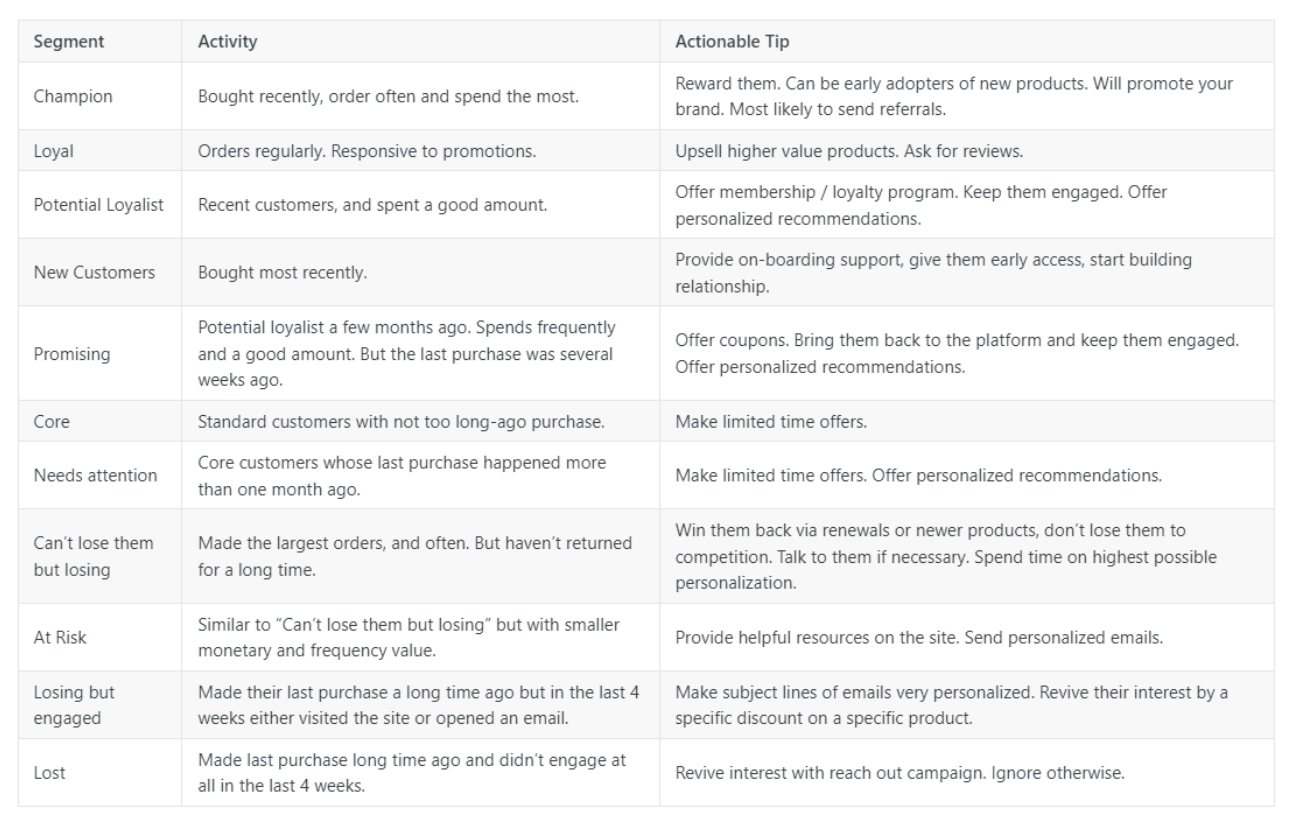

**Вывод**

RFM-анализ на 11 сегментов привел нас к следующим закономерностям:

- Большая часть наших пользователей принадлежит сегменту "Promising" (почти 36%). Такие пользователи являются потенциально лояльными: они тратят достаточно много и часто, однако, у них есть провал по метрике `recency`. Для вовлечения можно предложить им купоны и построить персонализированые рекомендации.

- На втором месте по численности находится сегмент "New customers" (20% от общего количества). Иначе говоря это новички, то есть те, кто сделал свою последнюю покупку недавно - именно `recency` их сильная сторона, остальные метрики могут быть в провале. Для них должна хорошо сработать on-boarding поддержка или дать ранний доступ к новой функциональности, приоритетно построить с ними крепкие отношения.

- Замыкает топ-3 сегментов "Cannot lose them" с почти 19% пользователей: это клиенты, которые делали крупные заказы и делали их часто, но мы давненько не видели их на платформе. Эту категорию мы должны отвоевать обратно, для этого можно использовать обновления или более новые версии полюбившихся им продуктов, обязательно подключать наивысшую степень персонализации или даже поговорить с ними, если необходимо.

- Следующая тройка "Lost customers", "Hibernating customers" и "About To Sleep" имеют по 7,5%-8,5% всей пользовательской аудитории. И если "Lost customers" характризуются самыми низкими значениями по метрике `recency` и скорее всего потерны для нас окончательно (хотя можно попробовать сделать для них reach-out кампанию), то "Hibernating" и "About To Sleep" обладают широкой вариативность параметров `frequency` и `monetary` при неплохом `recency`, то есть за них можно и нужно бороться, а точнее просто "оживить" их спрос - ограниченными по времени предложениями, дать специальный дисконт, в конце концов, настойчиво напомнить о себе персонализированной email-рассылкой.
       
- Особого внимания к себе требуют две следующие категории "At Risk" (0,76%) и "Need Attention" (0,53%). Обычно они характеризуются довольно хорошими показателями `frequency` и `monetary` (что сближает их с "Cannot lose them", но там эти показатели несколько выше), а вот по `recency` либо только начинают падение, либо их последний заказ состоялся уже довольно давно, что должно нас насторожить. Как и прежде, должны помочь персонализированные рекомендации и рассылки, а также ограниченные по времени предложения.
       
- "Potential Loyalist" (0,17%) это немногочисленная но очень перспективная категория, так как это покупатели, которые сделали свой заказ совсем недавно и он был на хорошую сумму. Это означает, что если суметь подхватить пользователя сейчас, то есть все шансы, что он станет постоянным и лояльным; или наоборот разочаруется в сервисе и нам придется прилагать в дальнейшем больше усилий по переводу его "наверх" по метрикам. Поэтому здесь нужно особо тщательно прорабатывать персонализированные рекомендации, предложить им членство или программу лояльности, которая будет держат их вовлеченными и довольными.

- "Loyal" и "Champions" образуют самые немногочиленные категории - всего 0,06% и 0,03% от всего числа пользователей соответственно. Однако, это наши самые главные, самые лояльные покупатели - они покупают регулярно, часто, тратят суммы гораздо выше средних. Именно в эти сегменты мы хотели бы провести всех наших покупателей, но по факту для маркетплейсов и вообще e-commerce характерны низкие показатели в этих группах, таковы особенности этого рынка. "Champions" нужно ценить больше всего - через систему наград и поощрений, раздавать реферальные ссылки и продукты на тест, чтобы они продвигали наш бренд, а "Loyal" можно предлагать более дорогие товары и поощрять оставлять отзывы для привлечения внимания новичков.